##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Word embeddings

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/word_embeddings">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/word_embeddings.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial introduces word embeddings. It contains complete code to train word embeddings from scratch on a small dataset, and to visualize these embeddings using the [Embedding Projector](http://projector.tensorflow.org) (shown in the image below).

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1" alt="Screenshot of the embedding projector" width="400"/>

## Representing text as numbers

Machine learning models take vectors (arrays of numbers) as input. When working with text, the first thing we must do come up with a strategy to convert strings to numbers (or to "vectorize" the text) before feeding it to the model. In this section, we will look at three strategies for doing so.

### One-hot encodings

As a first idea, we might "one-hot" encode each word in our vocabulary. Consider the sentence "The cat sat on the mat". The vocabulary (or unique words) in this sentence is (cat, mat, on, sat, the). To represent each word, we will create a zero vector with length equal to the vocabulary, then place a one in the index that corresponds to the word. This approach is shown in the following diagram.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/one-hot.png?raw=1" alt="Diagram of one-hot encodings" width="400" />

To create a vector that contains the encoding of the sentence, we could then concatenate the one-hot vectors for each word.

Key point: This approach is inefficient. A one-hot encoded vector is sparse (meaning, most indicices are zero). Imagine we have 10,000 words in the vocabulary. To one-hot encode each word, we would create a vector where 99.99% of the elements are zero.

### Encode each word with a unique number

A second approach we might try is to encode each word using a unique number. Continuing the example above, we could assign 1 to "cat", 2 to "mat", and so on. We could then encode the sentence "The cat sat on the mat" as a dense vector like [5, 1, 4, 3, 5, 2]. This appoach is efficient. Instead of a sparse vector, we now have a dense one (where all elements are full).

There are two downsides to this approach, however:

* The integer-encoding is arbitrary (it does not capture any relationship between words).

* An integer-encoding can be challenging for a model to interpret. A linear classifier, for example, learns a single weight for each feature. Because there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful.

### Word embeddings

Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, we do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding2.png?raw=1" alt="Diagram of an embedding" width="400"/>

Above is a diagram for a word embedding. Each word is represented as a 4-dimensional vector of floating point values. Another way to think of an embedding is as "lookup table". After these weights have been learned, we can encode each word by looking up the dense vector it corresponds to in the table.

## Setup

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  !pip install -q tf-nightly
except Exception:
  pass
import tensorflow as tf

ERROR: tensorflow 2.1.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.


In [3]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

## Using the Embedding layer

Keras makes it easy to use word embeddings. Let's take a look at the [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.



In [4]:
embedding_layer = layers.Embedding(1000, 5)



When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem your model is trained on).

If you pass an integer to an embedding layer, the result replaces each integer with the vector from the embedding table:

In [5]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[ 0.0252972 ,  0.00931629,  0.01379389,  0.03321191,  0.02750739],
       [ 0.00016246, -0.04685146, -0.00657048, -0.00264494, -0.03389832],
       [ 0.02179284,  0.02167055,  0.02554654,  0.03210088,  0.04411702]],
      dtype=float32)

For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15).

The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis. Pass it a `(2, 3)` input batch and the output is `(2, 3, N)`


In [6]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

When given a batch of sequences as input, an embedding layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. To convert from this sequence of variable length to a fixed representation there are a variety of standard approaches. You could use an RNN, Attention, or pooling layer before passing it to a Dense layer. This tutorial uses pooling because it's simplest. The [Text Classification with an RNN](text_classification_rnn.ipynb) tutorial is a good next step.

## Learning embeddings from scratch

In this tutorial you will train a sentiment classifier on IMDB movie reviews. In the process, the model will learn embeddings from scratch. We will use to a preprocessed dataset.

To load a text dataset from scratch see the  [Loading text tutorial](../load_data/text.ipynb).

In [7]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

Get the encoder (`tfds.features.text.SubwordTextEncoder`), and have a quick look at the vocabulary. 

The "\_" in the vocabulary represent spaces. Note how the vocabulary includes whole words (ending with "\_") and partial words which it can use to build larger words:

In [8]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

Movie reviews can be different lengths. We will use the `padded_batch` method to standardize the lengths of the reviews.

In [9]:
train_data

<PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>

In [10]:
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=([None],[]))
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes=([None],[]))

Note: As of **TensorFlow 2.2** the padded_shapes argument is no longer required. The default behavior is to pad all axes to the longest in the batch.

In [11]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

As imported, the text of reviews is integer-encoded (each integer represents a specific word or word-part in the vocabulary).

Note the trailing zeros, because the batch is padded to the longest example.

In [12]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[ 274,    4, 2743, ...,    0,    0,    0],
       [ 274,  181, 6510, ...,    0,    0,    0],
       [ 274, 2732, 1289, ...,    0,    0,    0],
       ...,
       [  12,  641,    7, ...,    0,    0,    0],
       [1397, 1425,  568, ...,    0,    0,    0],
       [  12,   81,  580, ...,    0,    0,    0]])

### Create a simple model

We will use the [Keras Sequential API](../../guide/keras) to define our model. In this case it is a "Continuous bag of words" style model.

* Next the Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.

* Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

* This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.

* The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability (or confidence level) that the review is positive.

Caution: This model doesn't use masking, so the zero-padding is used as part of the input, so the padding length may affect the output.  To fix this, see the [masking and padding guide](../../guide/keras/masking_and_padding).

In [13]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


### Compile and train the model

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10


   1/2500 [..............................] - ETA: 0s - loss: 0.6943 - accuracy: 0.5000

  13/2500 [..............................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5077

  26/2500 [..............................] - ETA: 9s - loss: 0.6934 - accuracy: 0.5038

  40/2500 [..............................] - ETA: 9s - loss: 0.6931 - accuracy: 0.5200

  53/2500 [..............................] - ETA: 9s - loss: 0.6934 - accuracy: 0.5019

  66/2500 [..............................] - ETA: 9s - loss: 0.6934 - accuracy: 0.5000

  80/2500 [..............................] - ETA: 9s - loss: 0.6934 - accuracy: 0.4975

  94/2500 [>.............................] - ETA: 9s - loss: 0.6933 - accuracy: 0.4915

 108/2500 [>.............................] - ETA: 9s - loss: 0.6933 - accuracy: 0.5065

 121/2500 [>.............................] - ETA: 9s - loss: 0.6933 - accuracy: 0.5017

 134/2500 [>.............................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5000

 147/2500 [>.............................] - ETA: 9s - loss: 0.6933 - accuracy: 0.4918

 160/2500 [>.............................] - ETA: 9s - loss: 0.6932 - accuracy: 0.4944

 173/2500 [=>............................] - ETA: 9s - loss: 0.6932 - accuracy: 0.4954

 187/2500 [=>............................] - ETA: 8s - loss: 0.6932 - accuracy: 0.4957

 200/2500 [=>............................] - ETA: 8s - loss: 0.6931 - accuracy: 0.4950

 214/2500 [=>............................] - ETA: 8s - loss: 0.6931 - accuracy: 0.4953

 227/2500 [=>............................] - ETA: 8s - loss: 0.6930 - accuracy: 0.4969

 240/2500 [=>............................] - ETA: 8s - loss: 0.6928 - accuracy: 0.5004

 253/2500 [==>...........................] - ETA: 8s - loss: 0.6927 - accuracy: 0.4992

 266/2500 [==>...........................] - ETA: 8s - loss: 0.6926 - accuracy: 0.4970

 280/2500 [==>...........................] - ETA: 8s - loss: 0.6926 - accuracy: 0.4971

 293/2500 [==>...........................] - ETA: 8s - loss: 0.6924 - accuracy: 0.4980

 306/2500 [==>...........................] - ETA: 8s - loss: 0.6923 - accuracy: 0.4951

 319/2500 [==>...........................] - ETA: 8s - loss: 0.6922 - accuracy: 0.4934

 332/2500 [==>...........................] - ETA: 8s - loss: 0.6921 - accuracy: 0.4952

 345/2500 [===>..........................] - ETA: 8s - loss: 0.6920 - accuracy: 0.4948

 357/2500 [===>..........................] - ETA: 8s - loss: 0.6918 - accuracy: 0.4950

 370/2500 [===>..........................] - ETA: 8s - loss: 0.6917 - accuracy: 0.4919

 383/2500 [===>..........................] - ETA: 8s - loss: 0.6915 - accuracy: 0.4919

 396/2500 [===>..........................] - ETA: 8s - loss: 0.6914 - accuracy: 0.4932

 409/2500 [===>..........................] - ETA: 8s - loss: 0.6912 - accuracy: 0.4951

 423/2500 [====>.........................] - ETA: 8s - loss: 0.6910 - accuracy: 0.4953

 436/2500 [====>.........................] - ETA: 8s - loss: 0.6908 - accuracy: 0.4956

 449/2500 [====>.........................] - ETA: 8s - loss: 0.6906 - accuracy: 0.4955

 463/2500 [====>.........................] - ETA: 7s - loss: 0.6902 - accuracy: 0.4940

 477/2500 [====>.........................] - ETA: 7s - loss: 0.6899 - accuracy: 0.4943

 491/2500 [====>.........................] - ETA: 7s - loss: 0.6895 - accuracy: 0.4955

 504/2500 [=====>........................] - ETA: 7s - loss: 0.6891 - accuracy: 0.4970

 517/2500 [=====>........................] - ETA: 7s - loss: 0.6888 - accuracy: 0.4975

 530/2500 [=====>........................] - ETA: 7s - loss: 0.6882 - accuracy: 0.4996

 543/2500 [=====>........................] - ETA: 7s - loss: 0.6881 - accuracy: 0.4983

 556/2500 [=====>........................] - ETA: 7s - loss: 0.6878 - accuracy: 0.4982

 569/2500 [=====>........................] - ETA: 7s - loss: 0.6874 - accuracy: 0.4988

 582/2500 [=====>........................] - ETA: 7s - loss: 0.6870 - accuracy: 0.4979

 595/2500 [======>.......................] - ETA: 7s - loss: 0.6864 - accuracy: 0.4985

 608/2500 [======>.......................] - ETA: 7s - loss: 0.6858 - accuracy: 0.4982

 621/2500 [======>.......................] - ETA: 7s - loss: 0.6855 - accuracy: 0.4973

 634/2500 [======>.......................] - ETA: 7s - loss: 0.6847 - accuracy: 0.4967

 647/2500 [======>.......................] - ETA: 7s - loss: 0.6843 - accuracy: 0.4978

 660/2500 [======>.......................] - ETA: 7s - loss: 0.6839 - accuracy: 0.4976

 673/2500 [=======>......................] - ETA: 7s - loss: 0.6831 - accuracy: 0.4985

 686/2500 [=======>......................] - ETA: 7s - loss: 0.6823 - accuracy: 0.4991

 698/2500 [=======>......................] - ETA: 7s - loss: 0.6815 - accuracy: 0.4994

 711/2500 [=======>......................] - ETA: 7s - loss: 0.6802 - accuracy: 0.4999

 725/2500 [=======>......................] - ETA: 6s - loss: 0.6793 - accuracy: 0.5004

 739/2500 [=======>......................] - ETA: 6s - loss: 0.6781 - accuracy: 0.4996

 752/2500 [========>.....................] - ETA: 6s - loss: 0.6774 - accuracy: 0.5008

 765/2500 [========>.....................] - ETA: 6s - loss: 0.6767 - accuracy: 0.5008

 778/2500 [========>.....................] - ETA: 6s - loss: 0.6760 - accuracy: 0.5014

 792/2500 [========>.....................] - ETA: 6s - loss: 0.6749 - accuracy: 0.5028

 806/2500 [========>.....................] - ETA: 6s - loss: 0.6741 - accuracy: 0.5024

 820/2500 [========>.....................] - ETA: 6s - loss: 0.6726 - accuracy: 0.5040

 833/2500 [========>.....................] - ETA: 6s - loss: 0.6717 - accuracy: 0.5040

 846/2500 [=========>....................] - ETA: 6s - loss: 0.6705 - accuracy: 0.5047

 859/2500 [=========>....................] - ETA: 6s - loss: 0.6696 - accuracy: 0.5052

 872/2500 [=========>....................] - ETA: 6s - loss: 0.6686 - accuracy: 0.5055

 886/2500 [=========>....................] - ETA: 6s - loss: 0.6676 - accuracy: 0.5089

 900/2500 [=========>....................] - ETA: 6s - loss: 0.6661 - accuracy: 0.5107

 914/2500 [=========>....................] - ETA: 6s - loss: 0.6647 - accuracy: 0.5119

 928/2500 [==========>...................] - ETA: 6s - loss: 0.6627 - accuracy: 0.5141

 941/2500 [==========>...................] - ETA: 6s - loss: 0.6612 - accuracy: 0.5157

 954/2500 [==========>...................] - ETA: 6s - loss: 0.6599 - accuracy: 0.5169

 967/2500 [==========>...................] - ETA: 5s - loss: 0.6580 - accuracy: 0.5207

 980/2500 [==========>...................] - ETA: 5s - loss: 0.6563 - accuracy: 0.5232

 993/2500 [==========>...................] - ETA: 5s - loss: 0.6543 - accuracy: 0.5253

1006/2500 [===========>..................] - ETA: 5s - loss: 0.6530 - accuracy: 0.5259

1020/2500 [===========>..................] - ETA: 5s - loss: 0.6513 - accuracy: 0.5291

1034/2500 [===========>..................] - ETA: 5s - loss: 0.6493 - accuracy: 0.5323

1048/2500 [===========>..................] - ETA: 5s - loss: 0.6473 - accuracy: 0.5344

1062/2500 [===========>..................] - ETA: 5s - loss: 0.6456 - accuracy: 0.5369

1075/2500 [===========>..................] - ETA: 5s - loss: 0.6438 - accuracy: 0.5398

1088/2500 [============>.................] - ETA: 5s - loss: 0.6429 - accuracy: 0.5413

1101/2500 [============>.................] - ETA: 5s - loss: 0.6409 - accuracy: 0.5431

1114/2500 [============>.................] - ETA: 5s - loss: 0.6391 - accuracy: 0.5454

1127/2500 [============>.................] - ETA: 5s - loss: 0.6372 - accuracy: 0.5489

1140/2500 [============>.................] - ETA: 5s - loss: 0.6360 - accuracy: 0.5497

1153/2500 [============>.................] - ETA: 5s - loss: 0.6351 - accuracy: 0.5511

1167/2500 [=============>................] - ETA: 5s - loss: 0.6331 - accuracy: 0.5536

1181/2500 [=============>................] - ETA: 5s - loss: 0.6319 - accuracy: 0.5550

1195/2500 [=============>................] - ETA: 5s - loss: 0.6302 - accuracy: 0.5568

1209/2500 [=============>................] - ETA: 5s - loss: 0.6290 - accuracy: 0.5581

1222/2500 [=============>................] - ETA: 4s - loss: 0.6270 - accuracy: 0.5609

1235/2500 [=============>................] - ETA: 4s - loss: 0.6253 - accuracy: 0.5623

1249/2500 [=============>................] - ETA: 4s - loss: 0.6234 - accuracy: 0.5644

1262/2500 [==============>...............] - ETA: 4s - loss: 0.6221 - accuracy: 0.5662

1275/2500 [==============>...............] - ETA: 4s - loss: 0.6207 - accuracy: 0.5681

1289/2500 [==============>...............] - ETA: 4s - loss: 0.6190 - accuracy: 0.5701

1303/2500 [==============>...............] - ETA: 4s - loss: 0.6175 - accuracy: 0.5719

1316/2500 [==============>...............] - ETA: 4s - loss: 0.6158 - accuracy: 0.5739

1330/2500 [==============>...............] - ETA: 4s - loss: 0.6139 - accuracy: 0.5753

1343/2500 [===============>..............] - ETA: 4s - loss: 0.6126 - accuracy: 0.5777

1356/2500 [===============>..............] - ETA: 4s - loss: 0.6112 - accuracy: 0.5790

1369/2500 [===============>..............] - ETA: 4s - loss: 0.6099 - accuracy: 0.5810

1383/2500 [===============>..............] - ETA: 4s - loss: 0.6093 - accuracy: 0.5824

1396/2500 [===============>..............] - ETA: 4s - loss: 0.6080 - accuracy: 0.5841

1409/2500 [===============>..............] - ETA: 4s - loss: 0.6064 - accuracy: 0.5858

1423/2500 [================>.............] - ETA: 4s - loss: 0.6047 - accuracy: 0.5878

1436/2500 [================>.............] - ETA: 4s - loss: 0.6032 - accuracy: 0.5894

1449/2500 [================>.............] - ETA: 4s - loss: 0.6016 - accuracy: 0.5908

1462/2500 [================>.............] - ETA: 4s - loss: 0.6002 - accuracy: 0.5927

1475/2500 [================>.............] - ETA: 3s - loss: 0.5985 - accuracy: 0.5945

1489/2500 [================>.............] - ETA: 3s - loss: 0.5975 - accuracy: 0.5954

1502/2500 [=================>............] - ETA: 3s - loss: 0.5957 - accuracy: 0.5971

1516/2500 [=================>............] - ETA: 3s - loss: 0.5942 - accuracy: 0.5993

1530/2500 [=================>............] - ETA: 3s - loss: 0.5925 - accuracy: 0.6012

1543/2500 [=================>............] - ETA: 3s - loss: 0.5914 - accuracy: 0.6027

1557/2500 [=================>............] - ETA: 3s - loss: 0.5900 - accuracy: 0.6040

1570/2500 [=================>............] - ETA: 3s - loss: 0.5883 - accuracy: 0.6059

1583/2500 [=================>............] - ETA: 3s - loss: 0.5869 - accuracy: 0.6075

1597/2500 [==================>...........] - ETA: 3s - loss: 0.5854 - accuracy: 0.6091

1610/2500 [==================>...........] - ETA: 3s - loss: 0.5846 - accuracy: 0.6107

1624/2500 [==================>...........] - ETA: 3s - loss: 0.5830 - accuracy: 0.6123

1637/2500 [==================>...........] - ETA: 3s - loss: 0.5816 - accuracy: 0.6138

1650/2500 [==================>...........] - ETA: 3s - loss: 0.5804 - accuracy: 0.6153

1663/2500 [==================>...........] - ETA: 3s - loss: 0.5787 - accuracy: 0.6164

1677/2500 [===================>..........] - ETA: 3s - loss: 0.5776 - accuracy: 0.6181

1690/2500 [===================>..........] - ETA: 3s - loss: 0.5760 - accuracy: 0.6194

1703/2500 [===================>..........] - ETA: 3s - loss: 0.5747 - accuracy: 0.6209

1716/2500 [===================>..........] - ETA: 3s - loss: 0.5735 - accuracy: 0.6222

1729/2500 [===================>..........] - ETA: 2s - loss: 0.5723 - accuracy: 0.6231

1743/2500 [===================>..........] - ETA: 2s - loss: 0.5713 - accuracy: 0.6248

1757/2500 [====================>.........] - ETA: 2s - loss: 0.5699 - accuracy: 0.6266

1770/2500 [====================>.........] - ETA: 2s - loss: 0.5690 - accuracy: 0.6276

1783/2500 [====================>.........] - ETA: 2s - loss: 0.5680 - accuracy: 0.6288

1796/2500 [====================>.........] - ETA: 2s - loss: 0.5667 - accuracy: 0.6301

1809/2500 [====================>.........] - ETA: 2s - loss: 0.5653 - accuracy: 0.6316

1822/2500 [====================>.........] - ETA: 2s - loss: 0.5639 - accuracy: 0.6331

1836/2500 [=====================>........] - ETA: 2s - loss: 0.5627 - accuracy: 0.6345

1849/2500 [=====================>........] - ETA: 2s - loss: 0.5618 - accuracy: 0.6354

1862/2500 [=====================>........] - ETA: 2s - loss: 0.5609 - accuracy: 0.6366

1876/2500 [=====================>........] - ETA: 2s - loss: 0.5596 - accuracy: 0.6377

1890/2500 [=====================>........] - ETA: 2s - loss: 0.5580 - accuracy: 0.6393

1903/2500 [=====================>........] - ETA: 2s - loss: 0.5570 - accuracy: 0.6405

1917/2500 [======================>.......] - ETA: 2s - loss: 0.5558 - accuracy: 0.6420

1931/2500 [======================>.......] - ETA: 2s - loss: 0.5549 - accuracy: 0.6429

1945/2500 [======================>.......] - ETA: 2s - loss: 0.5534 - accuracy: 0.6443

1958/2500 [======================>.......] - ETA: 2s - loss: 0.5524 - accuracy: 0.6457

1971/2500 [======================>.......] - ETA: 2s - loss: 0.5514 - accuracy: 0.6469

1984/2500 [======================>.......] - ETA: 2s - loss: 0.5505 - accuracy: 0.6479

1996/2500 [======================>.......] - ETA: 1s - loss: 0.5493 - accuracy: 0.6491

2010/2500 [=======================>......] - ETA: 1s - loss: 0.5483 - accuracy: 0.6500

2024/2500 [=======================>......] - ETA: 1s - loss: 0.5474 - accuracy: 0.6514

2038/2500 [=======================>......] - ETA: 1s - loss: 0.5456 - accuracy: 0.6530

2051/2500 [=======================>......] - ETA: 1s - loss: 0.5442 - accuracy: 0.6543

2065/2500 [=======================>......] - ETA: 1s - loss: 0.5429 - accuracy: 0.6560

2079/2500 [=======================>......] - ETA: 1s - loss: 0.5417 - accuracy: 0.6572

2092/2500 [========================>.....] - ETA: 1s - loss: 0.5411 - accuracy: 0.6581

2105/2500 [========================>.....] - ETA: 1s - loss: 0.5401 - accuracy: 0.6591

2118/2500 [========================>.....] - ETA: 1s - loss: 0.5392 - accuracy: 0.6602

2131/2500 [========================>.....] - ETA: 1s - loss: 0.5377 - accuracy: 0.6616

2145/2500 [========================>.....] - ETA: 1s - loss: 0.5369 - accuracy: 0.6625

2158/2500 [========================>.....] - ETA: 1s - loss: 0.5356 - accuracy: 0.6636

2172/2500 [=========================>....] - ETA: 1s - loss: 0.5345 - accuracy: 0.6648

2185/2500 [=========================>....] - ETA: 1s - loss: 0.5334 - accuracy: 0.6657

2199/2500 [=========================>....] - ETA: 1s - loss: 0.5325 - accuracy: 0.6666

2213/2500 [=========================>....] - ETA: 1s - loss: 0.5314 - accuracy: 0.6674

2226/2500 [=========================>....] - ETA: 1s - loss: 0.5300 - accuracy: 0.6689

2239/2500 [=========================>....] - ETA: 1s - loss: 0.5292 - accuracy: 0.6700

2253/2500 [==========================>...] - ETA: 0s - loss: 0.5281 - accuracy: 0.6711

2266/2500 [==========================>...] - ETA: 0s - loss: 0.5272 - accuracy: 0.6721

2280/2500 [==========================>...] - ETA: 0s - loss: 0.5263 - accuracy: 0.6729

2294/2500 [==========================>...] - ETA: 0s - loss: 0.5250 - accuracy: 0.6741

2308/2500 [==========================>...] - ETA: 0s - loss: 0.5239 - accuracy: 0.6753

2322/2500 [==========================>...] - ETA: 0s - loss: 0.5230 - accuracy: 0.6760

2336/2500 [===========================>..] - ETA: 0s - loss: 0.5218 - accuracy: 0.6771

2349/2500 [===========================>..] - ETA: 0s - loss: 0.5212 - accuracy: 0.6781

2363/2500 [===========================>..] - ETA: 0s - loss: 0.5206 - accuracy: 0.6784

2377/2500 [===========================>..] - ETA: 0s - loss: 0.5194 - accuracy: 0.6796

2390/2500 [===========================>..] - ETA: 0s - loss: 0.5184 - accuracy: 0.6808

2404/2500 [===========================>..] - ETA: 0s - loss: 0.5175 - accuracy: 0.6814

2418/2500 [============================>.] - ETA: 0s - loss: 0.5164 - accuracy: 0.6823

2432/2500 [============================>.] - ETA: 0s - loss: 0.5158 - accuracy: 0.6830

2446/2500 [============================>.] - ETA: 0s - loss: 0.5150 - accuracy: 0.6838

2460/2500 [============================>.] - ETA: 0s - loss: 0.5144 - accuracy: 0.6844

2475/2500 [============================>.] - ETA: 0s - loss: 0.5134 - accuracy: 0.6856

2489/2500 [============================>.] - ETA: 0s - loss: 0.5126 - accuracy: 0.6868

2500/2500 [==============================] - 10s 4ms/step - loss: 0.5120 - accuracy: 0.6870 - val_loss: 0.3633 - val_accuracy: 0.8200


Epoch 2/10
   1/2500 [..............................] - ETA: 0s - loss: 0.4116 - accuracy: 0.8000

  14/2500 [..............................] - ETA: 9s - loss: 0.3600 - accuracy: 0.8571

  27/2500 [..............................] - ETA: 9s - loss: 0.3317 - accuracy: 0.8889

  41/2500 [..............................] - ETA: 9s - loss: 0.3702 - accuracy: 0.8634

  55/2500 [..............................] - ETA: 9s - loss: 0.3634 - accuracy: 0.8582

  68/2500 [..............................] - ETA: 9s - loss: 0.3577 - accuracy: 0.8529

  82/2500 [..............................] - ETA: 9s - loss: 0.3543 - accuracy: 0.8537

  96/2500 [>.............................] - ETA: 9s - loss: 0.3510 - accuracy: 0.8490

 109/2500 [>.............................] - ETA: 9s - loss: 0.3476 - accuracy: 0.8459

 123/2500 [>.............................] - ETA: 9s - loss: 0.3419 - accuracy: 0.8537

 137/2500 [>.............................] - ETA: 9s - loss: 0.3403 - accuracy: 0.8489

 150/2500 [>.............................] - ETA: 9s - loss: 0.3387 - accuracy: 0.8473

 162/2500 [>.............................] - ETA: 9s - loss: 0.3408 - accuracy: 0.8488

 176/2500 [=>............................] - ETA: 8s - loss: 0.3389 - accuracy: 0.8438

 189/2500 [=>............................] - ETA: 8s - loss: 0.3343 - accuracy: 0.8481

 202/2500 [=>............................] - ETA: 8s - loss: 0.3303 - accuracy: 0.8520

 215/2500 [=>............................] - ETA: 8s - loss: 0.3319 - accuracy: 0.8540

 228/2500 [=>............................] - ETA: 8s - loss: 0.3281 - accuracy: 0.8548

 242/2500 [=>............................] - ETA: 8s - loss: 0.3271 - accuracy: 0.8562

 255/2500 [==>...........................] - ETA: 8s - loss: 0.3274 - accuracy: 0.8553

 268/2500 [==>...........................] - ETA: 8s - loss: 0.3290 - accuracy: 0.8560

 281/2500 [==>...........................] - ETA: 8s - loss: 0.3281 - accuracy: 0.8569

 295/2500 [==>...........................] - ETA: 8s - loss: 0.3259 - accuracy: 0.8573

 308/2500 [==>...........................] - ETA: 8s - loss: 0.3259 - accuracy: 0.8578

 321/2500 [==>...........................] - ETA: 8s - loss: 0.3256 - accuracy: 0.8583

 335/2500 [===>..........................] - ETA: 8s - loss: 0.3269 - accuracy: 0.8585

 349/2500 [===>..........................] - ETA: 8s - loss: 0.3245 - accuracy: 0.8590

 362/2500 [===>..........................] - ETA: 8s - loss: 0.3220 - accuracy: 0.8586

 376/2500 [===>..........................] - ETA: 8s - loss: 0.3256 - accuracy: 0.8572

 389/2500 [===>..........................] - ETA: 8s - loss: 0.3262 - accuracy: 0.8586

 403/2500 [===>..........................] - ETA: 8s - loss: 0.3262 - accuracy: 0.8591

 417/2500 [====>.........................] - ETA: 8s - loss: 0.3264 - accuracy: 0.8590

 430/2500 [====>.........................] - ETA: 7s - loss: 0.3256 - accuracy: 0.8598

 444/2500 [====>.........................] - ETA: 7s - loss: 0.3247 - accuracy: 0.8608

 457/2500 [====>.........................] - ETA: 7s - loss: 0.3251 - accuracy: 0.8611

 471/2500 [====>.........................] - ETA: 7s - loss: 0.3255 - accuracy: 0.8601

 485/2500 [====>.........................] - ETA: 7s - loss: 0.3237 - accuracy: 0.8621

 498/2500 [====>.........................] - ETA: 7s - loss: 0.3233 - accuracy: 0.8616

 512/2500 [=====>........................] - ETA: 7s - loss: 0.3235 - accuracy: 0.8625

 526/2500 [=====>........................] - ETA: 7s - loss: 0.3223 - accuracy: 0.8629

 539/2500 [=====>........................] - ETA: 7s - loss: 0.3205 - accuracy: 0.8640

 553/2500 [=====>........................] - ETA: 7s - loss: 0.3214 - accuracy: 0.8622

 567/2500 [=====>........................] - ETA: 7s - loss: 0.3200 - accuracy: 0.8640

 581/2500 [=====>........................] - ETA: 7s - loss: 0.3212 - accuracy: 0.8635

 595/2500 [======>.......................] - ETA: 7s - loss: 0.3203 - accuracy: 0.8640

 609/2500 [======>.......................] - ETA: 7s - loss: 0.3212 - accuracy: 0.8632

 622/2500 [======>.......................] - ETA: 7s - loss: 0.3224 - accuracy: 0.8629

 635/2500 [======>.......................] - ETA: 7s - loss: 0.3214 - accuracy: 0.8638

 649/2500 [======>.......................] - ETA: 7s - loss: 0.3205 - accuracy: 0.8641

 663/2500 [======>.......................] - ETA: 7s - loss: 0.3185 - accuracy: 0.8652

 677/2500 [=======>......................] - ETA: 7s - loss: 0.3168 - accuracy: 0.8660

 691/2500 [=======>......................] - ETA: 6s - loss: 0.3154 - accuracy: 0.8670

 704/2500 [=======>......................] - ETA: 6s - loss: 0.3154 - accuracy: 0.8669

 717/2500 [=======>......................] - ETA: 6s - loss: 0.3169 - accuracy: 0.8660

 730/2500 [=======>......................] - ETA: 6s - loss: 0.3168 - accuracy: 0.8663

 743/2500 [=======>......................] - ETA: 6s - loss: 0.3169 - accuracy: 0.8657

 757/2500 [========>.....................] - ETA: 6s - loss: 0.3176 - accuracy: 0.8655

 770/2500 [========>.....................] - ETA: 6s - loss: 0.3175 - accuracy: 0.8662

 783/2500 [========>.....................] - ETA: 6s - loss: 0.3168 - accuracy: 0.8660

 796/2500 [========>.....................] - ETA: 6s - loss: 0.3171 - accuracy: 0.8657

 810/2500 [========>.....................] - ETA: 6s - loss: 0.3158 - accuracy: 0.8669

 823/2500 [========>.....................] - ETA: 6s - loss: 0.3152 - accuracy: 0.8673

 836/2500 [=========>....................] - ETA: 6s - loss: 0.3147 - accuracy: 0.8675

 849/2500 [=========>....................] - ETA: 6s - loss: 0.3146 - accuracy: 0.8676

 863/2500 [=========>....................] - ETA: 6s - loss: 0.3137 - accuracy: 0.8673

 876/2500 [=========>....................] - ETA: 6s - loss: 0.3132 - accuracy: 0.8678

 889/2500 [=========>....................] - ETA: 6s - loss: 0.3126 - accuracy: 0.8681

 902/2500 [=========>....................] - ETA: 6s - loss: 0.3123 - accuracy: 0.8686

 915/2500 [=========>....................] - ETA: 6s - loss: 0.3117 - accuracy: 0.8690

 928/2500 [==========>...................] - ETA: 6s - loss: 0.3115 - accuracy: 0.8695

 941/2500 [==========>...................] - ETA: 6s - loss: 0.3107 - accuracy: 0.8700

 955/2500 [==========>...................] - ETA: 5s - loss: 0.3097 - accuracy: 0.8708

 968/2500 [==========>...................] - ETA: 5s - loss: 0.3100 - accuracy: 0.8709

 982/2500 [==========>...................] - ETA: 5s - loss: 0.3098 - accuracy: 0.8710

 995/2500 [==========>...................] - ETA: 5s - loss: 0.3096 - accuracy: 0.8710

1008/2500 [===========>..................] - ETA: 5s - loss: 0.3094 - accuracy: 0.8712

1022/2500 [===========>..................] - ETA: 5s - loss: 0.3086 - accuracy: 0.8715

1036/2500 [===========>..................] - ETA: 5s - loss: 0.3083 - accuracy: 0.8718

1050/2500 [===========>..................] - ETA: 5s - loss: 0.3074 - accuracy: 0.8722

1064/2500 [===========>..................] - ETA: 5s - loss: 0.3071 - accuracy: 0.8725

1078/2500 [===========>..................] - ETA: 5s - loss: 0.3066 - accuracy: 0.8725

1091/2500 [============>.................] - ETA: 5s - loss: 0.3061 - accuracy: 0.8730

1104/2500 [============>.................] - ETA: 5s - loss: 0.3057 - accuracy: 0.8732

1117/2500 [============>.................] - ETA: 5s - loss: 0.3049 - accuracy: 0.8732

1130/2500 [============>.................] - ETA: 5s - loss: 0.3047 - accuracy: 0.8733

1143/2500 [============>.................] - ETA: 5s - loss: 0.3056 - accuracy: 0.8731

1156/2500 [============>.................] - ETA: 5s - loss: 0.3049 - accuracy: 0.8737

1170/2500 [=============>................] - ETA: 5s - loss: 0.3045 - accuracy: 0.8735

1183/2500 [=============>................] - ETA: 5s - loss: 0.3031 - accuracy: 0.8739

1194/2500 [=============>................] - ETA: 5s - loss: 0.3036 - accuracy: 0.8740

1204/2500 [=============>................] - ETA: 5s - loss: 0.3029 - accuracy: 0.8743

1217/2500 [=============>................] - ETA: 4s - loss: 0.3028 - accuracy: 0.8742

1230/2500 [=============>................] - ETA: 4s - loss: 0.3025 - accuracy: 0.8744

1243/2500 [=============>................] - ETA: 4s - loss: 0.3030 - accuracy: 0.8741

1256/2500 [==============>...............] - ETA: 4s - loss: 0.3027 - accuracy: 0.8742

1269/2500 [==============>...............] - ETA: 4s - loss: 0.3021 - accuracy: 0.8743

1281/2500 [==============>...............] - ETA: 4s - loss: 0.3018 - accuracy: 0.8742

1293/2500 [==============>...............] - ETA: 4s - loss: 0.3014 - accuracy: 0.8745

1306/2500 [==============>...............] - ETA: 4s - loss: 0.3008 - accuracy: 0.8748

1319/2500 [==============>...............] - ETA: 4s - loss: 0.3010 - accuracy: 0.8745

1332/2500 [==============>...............] - ETA: 4s - loss: 0.3006 - accuracy: 0.8747

1345/2500 [===============>..............] - ETA: 4s - loss: 0.3008 - accuracy: 0.8743

1359/2500 [===============>..............] - ETA: 4s - loss: 0.2997 - accuracy: 0.8747

1372/2500 [===============>..............] - ETA: 4s - loss: 0.3000 - accuracy: 0.8746

1385/2500 [===============>..............] - ETA: 4s - loss: 0.2995 - accuracy: 0.8749

1398/2500 [===============>..............] - ETA: 4s - loss: 0.2992 - accuracy: 0.8750

1411/2500 [===============>..............] - ETA: 4s - loss: 0.2986 - accuracy: 0.8752

1424/2500 [================>.............] - ETA: 4s - loss: 0.2980 - accuracy: 0.8753

1437/2500 [================>.............] - ETA: 4s - loss: 0.2976 - accuracy: 0.8756

1450/2500 [================>.............] - ETA: 4s - loss: 0.2971 - accuracy: 0.8759

1463/2500 [================>.............] - ETA: 4s - loss: 0.2970 - accuracy: 0.8763

1476/2500 [================>.............] - ETA: 3s - loss: 0.2969 - accuracy: 0.8764

1488/2500 [================>.............] - ETA: 3s - loss: 0.2969 - accuracy: 0.8765

1499/2500 [================>.............] - ETA: 3s - loss: 0.2966 - accuracy: 0.8767

1510/2500 [=================>............] - ETA: 3s - loss: 0.2962 - accuracy: 0.8769

1522/2500 [=================>............] - ETA: 3s - loss: 0.2957 - accuracy: 0.8769

1535/2500 [=================>............] - ETA: 3s - loss: 0.2955 - accuracy: 0.8769

1548/2500 [=================>............] - ETA: 3s - loss: 0.2952 - accuracy: 0.8768

1561/2500 [=================>............] - ETA: 3s - loss: 0.2953 - accuracy: 0.8772

1574/2500 [=================>............] - ETA: 3s - loss: 0.2952 - accuracy: 0.8771

1587/2500 [==================>...........] - ETA: 3s - loss: 0.2949 - accuracy: 0.8775

1600/2500 [==================>...........] - ETA: 3s - loss: 0.2947 - accuracy: 0.8778

1613/2500 [==================>...........] - ETA: 3s - loss: 0.2941 - accuracy: 0.8782

1625/2500 [==================>...........] - ETA: 3s - loss: 0.2941 - accuracy: 0.8785

1637/2500 [==================>...........] - ETA: 3s - loss: 0.2941 - accuracy: 0.8784

1650/2500 [==================>...........] - ETA: 3s - loss: 0.2943 - accuracy: 0.8784

1663/2500 [==================>...........] - ETA: 3s - loss: 0.2943 - accuracy: 0.8784

1676/2500 [===================>..........] - ETA: 3s - loss: 0.2938 - accuracy: 0.8786

1689/2500 [===================>..........] - ETA: 3s - loss: 0.2940 - accuracy: 0.8786

1702/2500 [===================>..........] - ETA: 3s - loss: 0.2939 - accuracy: 0.8784

1715/2500 [===================>..........] - ETA: 3s - loss: 0.2939 - accuracy: 0.8785

1728/2500 [===================>..........] - ETA: 3s - loss: 0.2946 - accuracy: 0.8781

1741/2500 [===================>..........] - ETA: 2s - loss: 0.2939 - accuracy: 0.8783

1755/2500 [====================>.........] - ETA: 2s - loss: 0.2938 - accuracy: 0.8785

1768/2500 [====================>.........] - ETA: 2s - loss: 0.2945 - accuracy: 0.8777

1781/2500 [====================>.........] - ETA: 2s - loss: 0.2946 - accuracy: 0.8775

1794/2500 [====================>.........] - ETA: 2s - loss: 0.2947 - accuracy: 0.8776

1808/2500 [====================>.........] - ETA: 2s - loss: 0.2948 - accuracy: 0.8777

1821/2500 [====================>.........] - ETA: 2s - loss: 0.2950 - accuracy: 0.8778

1834/2500 [=====================>........] - ETA: 2s - loss: 0.2952 - accuracy: 0.8776

1847/2500 [=====================>........] - ETA: 2s - loss: 0.2949 - accuracy: 0.8778

1860/2500 [=====================>........] - ETA: 2s - loss: 0.2947 - accuracy: 0.8782

1873/2500 [=====================>........] - ETA: 2s - loss: 0.2943 - accuracy: 0.8784

1886/2500 [=====================>........] - ETA: 2s - loss: 0.2939 - accuracy: 0.8785

1899/2500 [=====================>........] - ETA: 2s - loss: 0.2944 - accuracy: 0.8787

1912/2500 [=====================>........] - ETA: 2s - loss: 0.2946 - accuracy: 0.8782

1925/2500 [======================>.......] - ETA: 2s - loss: 0.2948 - accuracy: 0.8783

1938/2500 [======================>.......] - ETA: 2s - loss: 0.2946 - accuracy: 0.8781

1951/2500 [======================>.......] - ETA: 2s - loss: 0.2946 - accuracy: 0.8781

1964/2500 [======================>.......] - ETA: 2s - loss: 0.2948 - accuracy: 0.8781

1977/2500 [======================>.......] - ETA: 2s - loss: 0.2943 - accuracy: 0.8780

1990/2500 [======================>.......] - ETA: 2s - loss: 0.2942 - accuracy: 0.8781

2002/2500 [=======================>......] - ETA: 1s - loss: 0.2943 - accuracy: 0.8780

2015/2500 [=======================>......] - ETA: 1s - loss: 0.2943 - accuracy: 0.8781

2028/2500 [=======================>......] - ETA: 1s - loss: 0.2939 - accuracy: 0.8782

2041/2500 [=======================>......] - ETA: 1s - loss: 0.2936 - accuracy: 0.8786

2053/2500 [=======================>......] - ETA: 1s - loss: 0.2937 - accuracy: 0.8785

2059/2500 [=======================>......] - ETA: 1s - loss: 0.2934 - accuracy: 0.8787

2064/2500 [=======================>......] - ETA: 1s - loss: 0.2933 - accuracy: 0.8787

2069/2500 [=======================>......] - ETA: 1s - loss: 0.2933 - accuracy: 0.8786

2075/2500 [=======================>......] - ETA: 1s - loss: 0.2931 - accuracy: 0.8787

2081/2500 [=======================>......] - ETA: 1s - loss: 0.2927 - accuracy: 0.8788

2086/2500 [========================>.....] - ETA: 1s - loss: 0.2928 - accuracy: 0.8788

2092/2500 [========================>.....] - ETA: 1s - loss: 0.2928 - accuracy: 0.8789

2097/2500 [========================>.....] - ETA: 1s - loss: 0.2925 - accuracy: 0.8791

2103/2500 [========================>.....] - ETA: 1s - loss: 0.2924 - accuracy: 0.8792

2109/2500 [========================>.....] - ETA: 1s - loss: 0.2924 - accuracy: 0.8790

2116/2500 [========================>.....] - ETA: 1s - loss: 0.2924 - accuracy: 0.8792

2127/2500 [========================>.....] - ETA: 1s - loss: 0.2925 - accuracy: 0.8791

2140/2500 [========================>.....] - ETA: 1s - loss: 0.2922 - accuracy: 0.8793

2153/2500 [========================>.....] - ETA: 1s - loss: 0.2920 - accuracy: 0.8795

2166/2500 [========================>.....] - ETA: 1s - loss: 0.2921 - accuracy: 0.8796

2179/2500 [=========================>....] - ETA: 1s - loss: 0.2920 - accuracy: 0.8794

2192/2500 [=========================>....] - ETA: 1s - loss: 0.2918 - accuracy: 0.8795

2205/2500 [=========================>....] - ETA: 1s - loss: 0.2917 - accuracy: 0.8795

2218/2500 [=========================>....] - ETA: 1s - loss: 0.2919 - accuracy: 0.8794

2231/2500 [=========================>....] - ETA: 1s - loss: 0.2916 - accuracy: 0.8795

2244/2500 [=========================>....] - ETA: 1s - loss: 0.2917 - accuracy: 0.8795

2257/2500 [==========================>...] - ETA: 0s - loss: 0.2914 - accuracy: 0.8796

2270/2500 [==========================>...] - ETA: 0s - loss: 0.2914 - accuracy: 0.8798

2283/2500 [==========================>...] - ETA: 0s - loss: 0.2908 - accuracy: 0.8799

2296/2500 [==========================>...] - ETA: 0s - loss: 0.2904 - accuracy: 0.8801

2309/2500 [==========================>...] - ETA: 0s - loss: 0.2902 - accuracy: 0.8803

2322/2500 [==========================>...] - ETA: 0s - loss: 0.2899 - accuracy: 0.8804

2336/2500 [===========================>..] - ETA: 0s - loss: 0.2893 - accuracy: 0.8808

2349/2500 [===========================>..] - ETA: 0s - loss: 0.2889 - accuracy: 0.8809

2362/2500 [===========================>..] - ETA: 0s - loss: 0.2891 - accuracy: 0.8807

2375/2500 [===========================>..] - ETA: 0s - loss: 0.2889 - accuracy: 0.8807

2388/2500 [===========================>..] - ETA: 0s - loss: 0.2888 - accuracy: 0.8808

2401/2500 [===========================>..] - ETA: 0s - loss: 0.2889 - accuracy: 0.8808

2415/2500 [===========================>..] - ETA: 0s - loss: 0.2882 - accuracy: 0.8811

2429/2500 [============================>.] - ETA: 0s - loss: 0.2875 - accuracy: 0.8814

2443/2500 [============================>.] - ETA: 0s - loss: 0.2875 - accuracy: 0.8815

2457/2500 [============================>.] - ETA: 0s - loss: 0.2875 - accuracy: 0.8816

2471/2500 [============================>.] - ETA: 0s - loss: 0.2877 - accuracy: 0.8815

2485/2500 [============================>.] - ETA: 0s - loss: 0.2881 - accuracy: 0.8812

2499/2500 [============================>.] - ETA: 0s - loss: 0.2879 - accuracy: 0.8812

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2880 - accuracy: 0.8811 - val_loss: 0.4278 - val_accuracy: 0.8300


Epoch 3/10


   1/2500 [..............................] - ETA: 0s - loss: 0.3389 - accuracy: 0.8000

  14/2500 [..............................] - ETA: 9s - loss: 0.2836 - accuracy: 0.8786

  27/2500 [..............................] - ETA: 9s - loss: 0.2432 - accuracy: 0.9037

  40/2500 [..............................] - ETA: 9s - loss: 0.2715 - accuracy: 0.8875

  54/2500 [..............................] - ETA: 9s - loss: 0.2543 - accuracy: 0.8981

  68/2500 [..............................] - ETA: 9s - loss: 0.2638 - accuracy: 0.8956

  81/2500 [..............................] - ETA: 9s - loss: 0.2589 - accuracy: 0.8951

  94/2500 [>.............................] - ETA: 9s - loss: 0.2657 - accuracy: 0.8894

 107/2500 [>.............................] - ETA: 9s - loss: 0.2666 - accuracy: 0.8935

 121/2500 [>.............................] - ETA: 9s - loss: 0.2644 - accuracy: 0.8893

 134/2500 [>.............................] - ETA: 9s - loss: 0.2614 - accuracy: 0.8910

 147/2500 [>.............................] - ETA: 9s - loss: 0.2593 - accuracy: 0.8925

 160/2500 [>.............................] - ETA: 9s - loss: 0.2573 - accuracy: 0.8944

 173/2500 [=>............................] - ETA: 8s - loss: 0.2597 - accuracy: 0.8925

 186/2500 [=>............................] - ETA: 8s - loss: 0.2607 - accuracy: 0.8935

 199/2500 [=>............................] - ETA: 8s - loss: 0.2595 - accuracy: 0.8930

 212/2500 [=>............................] - ETA: 8s - loss: 0.2655 - accuracy: 0.8887

 225/2500 [=>............................] - ETA: 8s - loss: 0.2719 - accuracy: 0.8858

 238/2500 [=>............................] - ETA: 8s - loss: 0.2706 - accuracy: 0.8887

 251/2500 [==>...........................] - ETA: 8s - loss: 0.2676 - accuracy: 0.8908

 264/2500 [==>...........................] - ETA: 8s - loss: 0.2639 - accuracy: 0.8917

 277/2500 [==>...........................] - ETA: 8s - loss: 0.2635 - accuracy: 0.8935

 290/2500 [==>...........................] - ETA: 8s - loss: 0.2604 - accuracy: 0.8948

 303/2500 [==>...........................] - ETA: 8s - loss: 0.2606 - accuracy: 0.8947

 316/2500 [==>...........................] - ETA: 8s - loss: 0.2578 - accuracy: 0.8949

 329/2500 [==>...........................] - ETA: 8s - loss: 0.2557 - accuracy: 0.8960

 342/2500 [===>..........................] - ETA: 8s - loss: 0.2557 - accuracy: 0.8950

 355/2500 [===>..........................] - ETA: 8s - loss: 0.2549 - accuracy: 0.8958

 368/2500 [===>..........................] - ETA: 8s - loss: 0.2541 - accuracy: 0.8973

 381/2500 [===>..........................] - ETA: 8s - loss: 0.2559 - accuracy: 0.8950

 395/2500 [===>..........................] - ETA: 8s - loss: 0.2578 - accuracy: 0.8949

 408/2500 [===>..........................] - ETA: 8s - loss: 0.2578 - accuracy: 0.8951

 421/2500 [====>.........................] - ETA: 8s - loss: 0.2574 - accuracy: 0.8955

 434/2500 [====>.........................] - ETA: 8s - loss: 0.2558 - accuracy: 0.8961

 447/2500 [====>.........................] - ETA: 7s - loss: 0.2565 - accuracy: 0.8960

 460/2500 [====>.........................] - ETA: 7s - loss: 0.2539 - accuracy: 0.8970

 473/2500 [====>.........................] - ETA: 7s - loss: 0.2544 - accuracy: 0.8964

 486/2500 [====>.........................] - ETA: 7s - loss: 0.2552 - accuracy: 0.8959

 499/2500 [====>.........................] - ETA: 7s - loss: 0.2537 - accuracy: 0.8972

 512/2500 [=====>........................] - ETA: 7s - loss: 0.2536 - accuracy: 0.8963

 525/2500 [=====>........................] - ETA: 7s - loss: 0.2559 - accuracy: 0.8956

 538/2500 [=====>........................] - ETA: 7s - loss: 0.2556 - accuracy: 0.8965

 551/2500 [=====>........................] - ETA: 7s - loss: 0.2540 - accuracy: 0.8976

 564/2500 [=====>........................] - ETA: 7s - loss: 0.2545 - accuracy: 0.8970

 578/2500 [=====>........................] - ETA: 7s - loss: 0.2556 - accuracy: 0.8971

 591/2500 [======>.......................] - ETA: 7s - loss: 0.2555 - accuracy: 0.8973

 604/2500 [======>.......................] - ETA: 7s - loss: 0.2541 - accuracy: 0.8974

 617/2500 [======>.......................] - ETA: 7s - loss: 0.2541 - accuracy: 0.8979

 631/2500 [======>.......................] - ETA: 7s - loss: 0.2528 - accuracy: 0.8984

 644/2500 [======>.......................] - ETA: 7s - loss: 0.2531 - accuracy: 0.8983

 657/2500 [======>.......................] - ETA: 7s - loss: 0.2537 - accuracy: 0.8976

 670/2500 [=======>......................] - ETA: 7s - loss: 0.2549 - accuracy: 0.8975

 683/2500 [=======>......................] - ETA: 7s - loss: 0.2538 - accuracy: 0.8974

 696/2500 [=======>......................] - ETA: 7s - loss: 0.2544 - accuracy: 0.8976

 709/2500 [=======>......................] - ETA: 6s - loss: 0.2541 - accuracy: 0.8968

 722/2500 [=======>......................] - ETA: 6s - loss: 0.2536 - accuracy: 0.8975

 735/2500 [=======>......................] - ETA: 6s - loss: 0.2526 - accuracy: 0.8980

 748/2500 [=======>......................] - ETA: 6s - loss: 0.2520 - accuracy: 0.8983

 761/2500 [========>.....................] - ETA: 6s - loss: 0.2517 - accuracy: 0.8984

 774/2500 [========>.....................] - ETA: 6s - loss: 0.2511 - accuracy: 0.8987

 787/2500 [========>.....................] - ETA: 6s - loss: 0.2519 - accuracy: 0.8978

 800/2500 [========>.....................] - ETA: 6s - loss: 0.2508 - accuracy: 0.8982

 813/2500 [========>.....................] - ETA: 6s - loss: 0.2504 - accuracy: 0.8989

 826/2500 [========>.....................] - ETA: 6s - loss: 0.2493 - accuracy: 0.9000

 839/2500 [=========>....................] - ETA: 6s - loss: 0.2495 - accuracy: 0.8999

 852/2500 [=========>....................] - ETA: 6s - loss: 0.2488 - accuracy: 0.9000

 866/2500 [=========>....................] - ETA: 6s - loss: 0.2494 - accuracy: 0.8998

 879/2500 [=========>....................] - ETA: 6s - loss: 0.2491 - accuracy: 0.8999

 892/2500 [=========>....................] - ETA: 6s - loss: 0.2486 - accuracy: 0.9003

 905/2500 [=========>....................] - ETA: 6s - loss: 0.2483 - accuracy: 0.9001

 918/2500 [==========>...................] - ETA: 6s - loss: 0.2474 - accuracy: 0.9007

 932/2500 [==========>...................] - ETA: 6s - loss: 0.2472 - accuracy: 0.9009

 946/2500 [==========>...................] - ETA: 6s - loss: 0.2469 - accuracy: 0.9012

 959/2500 [==========>...................] - ETA: 6s - loss: 0.2463 - accuracy: 0.9017

 972/2500 [==========>...................] - ETA: 5s - loss: 0.2465 - accuracy: 0.9016

 985/2500 [==========>...................] - ETA: 5s - loss: 0.2456 - accuracy: 0.9023

 998/2500 [==========>...................] - ETA: 5s - loss: 0.2465 - accuracy: 0.9019

1011/2500 [===========>..................] - ETA: 5s - loss: 0.2454 - accuracy: 0.9025

1024/2500 [===========>..................] - ETA: 5s - loss: 0.2447 - accuracy: 0.9028

1038/2500 [===========>..................] - ETA: 5s - loss: 0.2442 - accuracy: 0.9030

1051/2500 [===========>..................] - ETA: 5s - loss: 0.2436 - accuracy: 0.9034

1064/2500 [===========>..................] - ETA: 5s - loss: 0.2426 - accuracy: 0.9041

1077/2500 [===========>..................] - ETA: 5s - loss: 0.2425 - accuracy: 0.9041

1091/2500 [============>.................] - ETA: 5s - loss: 0.2422 - accuracy: 0.9038

1104/2500 [============>.................] - ETA: 5s - loss: 0.2424 - accuracy: 0.9037

1117/2500 [============>.................] - ETA: 5s - loss: 0.2421 - accuracy: 0.9040

1130/2500 [============>.................] - ETA: 5s - loss: 0.2421 - accuracy: 0.9036

1143/2500 [============>.................] - ETA: 5s - loss: 0.2424 - accuracy: 0.9038

1156/2500 [============>.................] - ETA: 5s - loss: 0.2424 - accuracy: 0.9034

1169/2500 [=============>................] - ETA: 5s - loss: 0.2424 - accuracy: 0.9036

1182/2500 [=============>................] - ETA: 5s - loss: 0.2424 - accuracy: 0.9030

1196/2500 [=============>................] - ETA: 5s - loss: 0.2421 - accuracy: 0.9029

1210/2500 [=============>................] - ETA: 5s - loss: 0.2426 - accuracy: 0.9026

1224/2500 [=============>................] - ETA: 4s - loss: 0.2425 - accuracy: 0.9028

1237/2500 [=============>................] - ETA: 4s - loss: 0.2431 - accuracy: 0.9027

1250/2500 [==============>...............] - ETA: 4s - loss: 0.2435 - accuracy: 0.9025

1263/2500 [==============>...............] - ETA: 4s - loss: 0.2431 - accuracy: 0.9029

1276/2500 [==============>...............] - ETA: 4s - loss: 0.2426 - accuracy: 0.9028

1289/2500 [==============>...............] - ETA: 4s - loss: 0.2420 - accuracy: 0.9030

1302/2500 [==============>...............] - ETA: 4s - loss: 0.2412 - accuracy: 0.9035

1315/2500 [==============>...............] - ETA: 4s - loss: 0.2417 - accuracy: 0.9035

1329/2500 [==============>...............] - ETA: 4s - loss: 0.2410 - accuracy: 0.9037

1342/2500 [===============>..............] - ETA: 4s - loss: 0.2409 - accuracy: 0.9037

1355/2500 [===============>..............] - ETA: 4s - loss: 0.2413 - accuracy: 0.9032

1368/2500 [===============>..............] - ETA: 4s - loss: 0.2413 - accuracy: 0.9034

1382/2500 [===============>..............] - ETA: 4s - loss: 0.2422 - accuracy: 0.9027

1395/2500 [===============>..............] - ETA: 4s - loss: 0.2428 - accuracy: 0.9024

1408/2500 [===============>..............] - ETA: 4s - loss: 0.2429 - accuracy: 0.9026

1421/2500 [================>.............] - ETA: 4s - loss: 0.2428 - accuracy: 0.9024

1434/2500 [================>.............] - ETA: 4s - loss: 0.2423 - accuracy: 0.9029

1447/2500 [================>.............] - ETA: 4s - loss: 0.2423 - accuracy: 0.9030

1460/2500 [================>.............] - ETA: 4s - loss: 0.2416 - accuracy: 0.9033

1474/2500 [================>.............] - ETA: 4s - loss: 0.2407 - accuracy: 0.9039

1487/2500 [================>.............] - ETA: 3s - loss: 0.2400 - accuracy: 0.9042

1500/2500 [=================>............] - ETA: 3s - loss: 0.2402 - accuracy: 0.9041

1513/2500 [=================>............] - ETA: 3s - loss: 0.2405 - accuracy: 0.9038

1526/2500 [=================>............] - ETA: 3s - loss: 0.2409 - accuracy: 0.9033

1539/2500 [=================>............] - ETA: 3s - loss: 0.2408 - accuracy: 0.9034

1552/2500 [=================>............] - ETA: 3s - loss: 0.2409 - accuracy: 0.9034

1565/2500 [=================>............] - ETA: 3s - loss: 0.2410 - accuracy: 0.9036

1578/2500 [=================>............] - ETA: 3s - loss: 0.2407 - accuracy: 0.9037

1591/2500 [==================>...........] - ETA: 3s - loss: 0.2405 - accuracy: 0.9036

1604/2500 [==================>...........] - ETA: 3s - loss: 0.2404 - accuracy: 0.9036

1617/2500 [==================>...........] - ETA: 3s - loss: 0.2400 - accuracy: 0.9038

1630/2500 [==================>...........] - ETA: 3s - loss: 0.2397 - accuracy: 0.9040

1643/2500 [==================>...........] - ETA: 3s - loss: 0.2395 - accuracy: 0.9038

1656/2500 [==================>...........] - ETA: 3s - loss: 0.2391 - accuracy: 0.9039

1669/2500 [===================>..........] - ETA: 3s - loss: 0.2395 - accuracy: 0.9038

1682/2500 [===================>..........] - ETA: 3s - loss: 0.2397 - accuracy: 0.9037

1695/2500 [===================>..........] - ETA: 3s - loss: 0.2393 - accuracy: 0.9040

1708/2500 [===================>..........] - ETA: 3s - loss: 0.2399 - accuracy: 0.9039

1721/2500 [===================>..........] - ETA: 3s - loss: 0.2391 - accuracy: 0.9044

1734/2500 [===================>..........] - ETA: 2s - loss: 0.2394 - accuracy: 0.9043

1747/2500 [===================>..........] - ETA: 2s - loss: 0.2396 - accuracy: 0.9039

1760/2500 [====================>.........] - ETA: 2s - loss: 0.2394 - accuracy: 0.9041

1773/2500 [====================>.........] - ETA: 2s - loss: 0.2391 - accuracy: 0.9042

1785/2500 [====================>.........] - ETA: 2s - loss: 0.2391 - accuracy: 0.9044

1798/2500 [====================>.........] - ETA: 2s - loss: 0.2388 - accuracy: 0.9045

1811/2500 [====================>.........] - ETA: 2s - loss: 0.2386 - accuracy: 0.9045

1824/2500 [====================>.........] - ETA: 2s - loss: 0.2386 - accuracy: 0.9044

1837/2500 [=====================>........] - ETA: 2s - loss: 0.2382 - accuracy: 0.9045

1850/2500 [=====================>........] - ETA: 2s - loss: 0.2382 - accuracy: 0.9046

1863/2500 [=====================>........] - ETA: 2s - loss: 0.2383 - accuracy: 0.9042

1876/2500 [=====================>........] - ETA: 2s - loss: 0.2388 - accuracy: 0.9041

1889/2500 [=====================>........] - ETA: 2s - loss: 0.2387 - accuracy: 0.9042

1902/2500 [=====================>........] - ETA: 2s - loss: 0.2394 - accuracy: 0.9038

1915/2500 [=====================>........] - ETA: 2s - loss: 0.2389 - accuracy: 0.9041

1928/2500 [======================>.......] - ETA: 2s - loss: 0.2392 - accuracy: 0.9039

1941/2500 [======================>.......] - ETA: 2s - loss: 0.2386 - accuracy: 0.9042

1954/2500 [======================>.......] - ETA: 2s - loss: 0.2391 - accuracy: 0.9042

1967/2500 [======================>.......] - ETA: 2s - loss: 0.2390 - accuracy: 0.9043

1980/2500 [======================>.......] - ETA: 2s - loss: 0.2385 - accuracy: 0.9045

1993/2500 [======================>.......] - ETA: 1s - loss: 0.2390 - accuracy: 0.9044

2006/2500 [=======================>......] - ETA: 1s - loss: 0.2389 - accuracy: 0.9045

2019/2500 [=======================>......] - ETA: 1s - loss: 0.2390 - accuracy: 0.9047

2032/2500 [=======================>......] - ETA: 1s - loss: 0.2388 - accuracy: 0.9046

2045/2500 [=======================>......] - ETA: 1s - loss: 0.2385 - accuracy: 0.9048

2058/2500 [=======================>......] - ETA: 1s - loss: 0.2385 - accuracy: 0.9046

2071/2500 [=======================>......] - ETA: 1s - loss: 0.2384 - accuracy: 0.9047

2084/2500 [========================>.....] - ETA: 1s - loss: 0.2393 - accuracy: 0.9042

2097/2500 [========================>.....] - ETA: 1s - loss: 0.2390 - accuracy: 0.9045

2110/2500 [========================>.....] - ETA: 1s - loss: 0.2391 - accuracy: 0.9044

2123/2500 [========================>.....] - ETA: 1s - loss: 0.2397 - accuracy: 0.9040

2136/2500 [========================>.....] - ETA: 1s - loss: 0.2395 - accuracy: 0.9041

2150/2500 [========================>.....] - ETA: 1s - loss: 0.2393 - accuracy: 0.9040

2163/2500 [========================>.....] - ETA: 1s - loss: 0.2392 - accuracy: 0.9042

2176/2500 [=========================>....] - ETA: 1s - loss: 0.2391 - accuracy: 0.9043

2189/2500 [=========================>....] - ETA: 1s - loss: 0.2388 - accuracy: 0.9043

2202/2500 [=========================>....] - ETA: 1s - loss: 0.2385 - accuracy: 0.9044

2216/2500 [=========================>....] - ETA: 1s - loss: 0.2382 - accuracy: 0.9045

2230/2500 [=========================>....] - ETA: 1s - loss: 0.2378 - accuracy: 0.9047

2243/2500 [=========================>....] - ETA: 1s - loss: 0.2378 - accuracy: 0.9047

2257/2500 [==========================>...] - ETA: 0s - loss: 0.2371 - accuracy: 0.9050

2270/2500 [==========================>...] - ETA: 0s - loss: 0.2370 - accuracy: 0.9052

2284/2500 [==========================>...] - ETA: 0s - loss: 0.2369 - accuracy: 0.9052

2298/2500 [==========================>...] - ETA: 0s - loss: 0.2372 - accuracy: 0.9051

2311/2500 [==========================>...] - ETA: 0s - loss: 0.2376 - accuracy: 0.9051

2324/2500 [==========================>...] - ETA: 0s - loss: 0.2376 - accuracy: 0.9052

2338/2500 [===========================>..] - ETA: 0s - loss: 0.2376 - accuracy: 0.9051

2351/2500 [===========================>..] - ETA: 0s - loss: 0.2376 - accuracy: 0.9051

2365/2500 [===========================>..] - ETA: 0s - loss: 0.2377 - accuracy: 0.9051

2379/2500 [===========================>..] - ETA: 0s - loss: 0.2372 - accuracy: 0.9053

2393/2500 [===========================>..] - ETA: 0s - loss: 0.2367 - accuracy: 0.9055

2407/2500 [===========================>..] - ETA: 0s - loss: 0.2366 - accuracy: 0.9054

2421/2500 [============================>.] - ETA: 0s - loss: 0.2364 - accuracy: 0.9055

2435/2500 [============================>.] - ETA: 0s - loss: 0.2366 - accuracy: 0.9054

2449/2500 [============================>.] - ETA: 0s - loss: 0.2363 - accuracy: 0.9056

2463/2500 [============================>.] - ETA: 0s - loss: 0.2363 - accuracy: 0.9055

2477/2500 [============================>.] - ETA: 0s - loss: 0.2366 - accuracy: 0.9054

2491/2500 [============================>.] - ETA: 0s - loss: 0.2364 - accuracy: 0.9055

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2361 - accuracy: 0.9056 - val_loss: 0.3392 - val_accuracy: 0.8700


Epoch 4/10
   1/2500 [..............................] - ETA: 0s - loss: 0.3723 - accuracy: 1.0000

  15/2500 [..............................] - ETA: 8s - loss: 0.2562 - accuracy: 0.8933

  28/2500 [..............................] - ETA: 9s - loss: 0.2136 - accuracy: 0.9036

  41/2500 [..............................] - ETA: 9s - loss: 0.2110 - accuracy: 0.9049

  54/2500 [..............................] - ETA: 9s - loss: 0.2122 - accuracy: 0.9037

  67/2500 [..............................] - ETA: 9s - loss: 0.2102 - accuracy: 0.9030

  81/2500 [..............................] - ETA: 9s - loss: 0.2364 - accuracy: 0.8926

  94/2500 [>.............................] - ETA: 9s - loss: 0.2305 - accuracy: 0.8989

 107/2500 [>.............................] - ETA: 9s - loss: 0.2259 - accuracy: 0.9028

 121/2500 [>.............................] - ETA: 9s - loss: 0.2303 - accuracy: 0.9041

 135/2500 [>.............................] - ETA: 9s - loss: 0.2359 - accuracy: 0.9000

 149/2500 [>.............................] - ETA: 8s - loss: 0.2306 - accuracy: 0.9027

 163/2500 [>.............................] - ETA: 8s - loss: 0.2237 - accuracy: 0.9067

 176/2500 [=>............................] - ETA: 8s - loss: 0.2221 - accuracy: 0.9080

 190/2500 [=>............................] - ETA: 8s - loss: 0.2144 - accuracy: 0.9126

 203/2500 [=>............................] - ETA: 8s - loss: 0.2141 - accuracy: 0.9148

 216/2500 [=>............................] - ETA: 8s - loss: 0.2152 - accuracy: 0.9148

 229/2500 [=>............................] - ETA: 8s - loss: 0.2132 - accuracy: 0.9153

 242/2500 [=>............................] - ETA: 8s - loss: 0.2151 - accuracy: 0.9169

 255/2500 [==>...........................] - ETA: 8s - loss: 0.2171 - accuracy: 0.9157

 268/2500 [==>...........................] - ETA: 8s - loss: 0.2162 - accuracy: 0.9149

 281/2500 [==>...........................] - ETA: 8s - loss: 0.2192 - accuracy: 0.9132

 294/2500 [==>...........................] - ETA: 8s - loss: 0.2181 - accuracy: 0.9136

 307/2500 [==>...........................] - ETA: 8s - loss: 0.2164 - accuracy: 0.9137

 320/2500 [==>...........................] - ETA: 8s - loss: 0.2163 - accuracy: 0.9141

 333/2500 [==>...........................] - ETA: 8s - loss: 0.2154 - accuracy: 0.9144

 347/2500 [===>..........................] - ETA: 8s - loss: 0.2131 - accuracy: 0.9164

 361/2500 [===>..........................] - ETA: 8s - loss: 0.2110 - accuracy: 0.9172

 375/2500 [===>..........................] - ETA: 8s - loss: 0.2118 - accuracy: 0.9179

 388/2500 [===>..........................] - ETA: 8s - loss: 0.2103 - accuracy: 0.9178

 401/2500 [===>..........................] - ETA: 8s - loss: 0.2090 - accuracy: 0.9195

 414/2500 [===>..........................] - ETA: 8s - loss: 0.2100 - accuracy: 0.9188

 428/2500 [====>.........................] - ETA: 8s - loss: 0.2102 - accuracy: 0.9180

 441/2500 [====>.........................] - ETA: 7s - loss: 0.2120 - accuracy: 0.9170

 454/2500 [====>.........................] - ETA: 7s - loss: 0.2144 - accuracy: 0.9154

 467/2500 [====>.........................] - ETA: 7s - loss: 0.2142 - accuracy: 0.9150

 480/2500 [====>.........................] - ETA: 7s - loss: 0.2126 - accuracy: 0.9154

 493/2500 [====>.........................] - ETA: 7s - loss: 0.2123 - accuracy: 0.9158

 506/2500 [=====>........................] - ETA: 7s - loss: 0.2161 - accuracy: 0.9152

 519/2500 [=====>........................] - ETA: 7s - loss: 0.2148 - accuracy: 0.9156

 532/2500 [=====>........................] - ETA: 7s - loss: 0.2140 - accuracy: 0.9162

 545/2500 [=====>........................] - ETA: 7s - loss: 0.2138 - accuracy: 0.9169

 558/2500 [=====>........................] - ETA: 7s - loss: 0.2136 - accuracy: 0.9170

 571/2500 [=====>........................] - ETA: 7s - loss: 0.2118 - accuracy: 0.9180

 584/2500 [======>.......................] - ETA: 7s - loss: 0.2110 - accuracy: 0.9180

 597/2500 [======>.......................] - ETA: 7s - loss: 0.2108 - accuracy: 0.9178

 610/2500 [======>.......................] - ETA: 7s - loss: 0.2103 - accuracy: 0.9180

 624/2500 [======>.......................] - ETA: 7s - loss: 0.2095 - accuracy: 0.9183

 637/2500 [======>.......................] - ETA: 7s - loss: 0.2096 - accuracy: 0.9188

 650/2500 [======>.......................] - ETA: 7s - loss: 0.2087 - accuracy: 0.9185

 664/2500 [======>.......................] - ETA: 7s - loss: 0.2083 - accuracy: 0.9188

 678/2500 [=======>......................] - ETA: 7s - loss: 0.2084 - accuracy: 0.9186

 691/2500 [=======>......................] - ETA: 7s - loss: 0.2096 - accuracy: 0.9187

 704/2500 [=======>......................] - ETA: 6s - loss: 0.2079 - accuracy: 0.9195

 717/2500 [=======>......................] - ETA: 6s - loss: 0.2082 - accuracy: 0.9195

 730/2500 [=======>......................] - ETA: 6s - loss: 0.2072 - accuracy: 0.9195

 743/2500 [=======>......................] - ETA: 6s - loss: 0.2075 - accuracy: 0.9188

 756/2500 [========>.....................] - ETA: 6s - loss: 0.2076 - accuracy: 0.9189

 769/2500 [========>.....................] - ETA: 6s - loss: 0.2078 - accuracy: 0.9187

 782/2500 [========>.....................] - ETA: 6s - loss: 0.2083 - accuracy: 0.9187

 795/2500 [========>.....................] - ETA: 6s - loss: 0.2088 - accuracy: 0.9187

 808/2500 [========>.....................] - ETA: 6s - loss: 0.2092 - accuracy: 0.9183

 821/2500 [========>.....................] - ETA: 6s - loss: 0.2092 - accuracy: 0.9175

 834/2500 [=========>....................] - ETA: 6s - loss: 0.2084 - accuracy: 0.9177

 847/2500 [=========>....................] - ETA: 6s - loss: 0.2080 - accuracy: 0.9182

 860/2500 [=========>....................] - ETA: 6s - loss: 0.2080 - accuracy: 0.9180

 873/2500 [=========>....................] - ETA: 6s - loss: 0.2086 - accuracy: 0.9170

 886/2500 [=========>....................] - ETA: 6s - loss: 0.2085 - accuracy: 0.9172

 899/2500 [=========>....................] - ETA: 6s - loss: 0.2078 - accuracy: 0.9176

 913/2500 [=========>....................] - ETA: 6s - loss: 0.2078 - accuracy: 0.9181

 927/2500 [==========>...................] - ETA: 6s - loss: 0.2083 - accuracy: 0.9183

 940/2500 [==========>...................] - ETA: 6s - loss: 0.2077 - accuracy: 0.9190

 954/2500 [==========>...................] - ETA: 6s - loss: 0.2075 - accuracy: 0.9188

 967/2500 [==========>...................] - ETA: 5s - loss: 0.2078 - accuracy: 0.9182

 980/2500 [==========>...................] - ETA: 5s - loss: 0.2075 - accuracy: 0.9185

 993/2500 [==========>...................] - ETA: 5s - loss: 0.2070 - accuracy: 0.9185

1006/2500 [===========>..................] - ETA: 5s - loss: 0.2071 - accuracy: 0.9185

1019/2500 [===========>..................] - ETA: 5s - loss: 0.2084 - accuracy: 0.9182

1033/2500 [===========>..................] - ETA: 5s - loss: 0.2079 - accuracy: 0.9186

1046/2500 [===========>..................] - ETA: 5s - loss: 0.2072 - accuracy: 0.9191

1059/2500 [===========>..................] - ETA: 5s - loss: 0.2068 - accuracy: 0.9195

1072/2500 [===========>..................] - ETA: 5s - loss: 0.2061 - accuracy: 0.9201

1086/2500 [============>.................] - ETA: 5s - loss: 0.2063 - accuracy: 0.9199

1100/2500 [============>.................] - ETA: 5s - loss: 0.2063 - accuracy: 0.9196

1113/2500 [============>.................] - ETA: 5s - loss: 0.2060 - accuracy: 0.9199

1126/2500 [============>.................] - ETA: 5s - loss: 0.2061 - accuracy: 0.9196

1140/2500 [============>.................] - ETA: 5s - loss: 0.2060 - accuracy: 0.9198

1153/2500 [============>.................] - ETA: 5s - loss: 0.2061 - accuracy: 0.9198

1166/2500 [============>.................] - ETA: 5s - loss: 0.2062 - accuracy: 0.9196

1179/2500 [=============>................] - ETA: 5s - loss: 0.2063 - accuracy: 0.9194

1191/2500 [=============>................] - ETA: 5s - loss: 0.2058 - accuracy: 0.9200

1203/2500 [=============>................] - ETA: 5s - loss: 0.2056 - accuracy: 0.9200

1216/2500 [=============>................] - ETA: 5s - loss: 0.2054 - accuracy: 0.9202

1229/2500 [=============>................] - ETA: 4s - loss: 0.2053 - accuracy: 0.9199

1242/2500 [=============>................] - ETA: 4s - loss: 0.2047 - accuracy: 0.9202

1255/2500 [==============>...............] - ETA: 4s - loss: 0.2047 - accuracy: 0.9199

1268/2500 [==============>...............] - ETA: 4s - loss: 0.2045 - accuracy: 0.9199

1282/2500 [==============>...............] - ETA: 4s - loss: 0.2050 - accuracy: 0.9200

1295/2500 [==============>...............] - ETA: 4s - loss: 0.2049 - accuracy: 0.9200

1308/2500 [==============>...............] - ETA: 4s - loss: 0.2041 - accuracy: 0.9200

1321/2500 [==============>...............] - ETA: 4s - loss: 0.2043 - accuracy: 0.9200

1334/2500 [===============>..............] - ETA: 4s - loss: 0.2050 - accuracy: 0.9199

1347/2500 [===============>..............] - ETA: 4s - loss: 0.2051 - accuracy: 0.9198

1361/2500 [===============>..............] - ETA: 4s - loss: 0.2049 - accuracy: 0.9199

1374/2500 [===============>..............] - ETA: 4s - loss: 0.2048 - accuracy: 0.9198

1387/2500 [===============>..............] - ETA: 4s - loss: 0.2055 - accuracy: 0.9192

1400/2500 [===============>..............] - ETA: 4s - loss: 0.2053 - accuracy: 0.9191

1413/2500 [===============>..............] - ETA: 4s - loss: 0.2044 - accuracy: 0.9197

1426/2500 [================>.............] - ETA: 4s - loss: 0.2046 - accuracy: 0.9196

1439/2500 [================>.............] - ETA: 4s - loss: 0.2042 - accuracy: 0.9199

1452/2500 [================>.............] - ETA: 4s - loss: 0.2037 - accuracy: 0.9200

1465/2500 [================>.............] - ETA: 4s - loss: 0.2034 - accuracy: 0.9201

1478/2500 [================>.............] - ETA: 3s - loss: 0.2035 - accuracy: 0.9197

1491/2500 [================>.............] - ETA: 3s - loss: 0.2031 - accuracy: 0.9195

1504/2500 [=================>............] - ETA: 3s - loss: 0.2034 - accuracy: 0.9194

1517/2500 [=================>............] - ETA: 3s - loss: 0.2027 - accuracy: 0.9198

1530/2500 [=================>............] - ETA: 3s - loss: 0.2027 - accuracy: 0.9198

1543/2500 [=================>............] - ETA: 3s - loss: 0.2026 - accuracy: 0.9198

1556/2500 [=================>............] - ETA: 3s - loss: 0.2023 - accuracy: 0.9199

1568/2500 [=================>............] - ETA: 3s - loss: 0.2018 - accuracy: 0.9201

1581/2500 [=================>............] - ETA: 3s - loss: 0.2018 - accuracy: 0.9202

1594/2500 [==================>...........] - ETA: 3s - loss: 0.2028 - accuracy: 0.9197

1607/2500 [==================>...........] - ETA: 3s - loss: 0.2029 - accuracy: 0.9198

1620/2500 [==================>...........] - ETA: 3s - loss: 0.2035 - accuracy: 0.9199

1633/2500 [==================>...........] - ETA: 3s - loss: 0.2035 - accuracy: 0.9197

1646/2500 [==================>...........] - ETA: 3s - loss: 0.2036 - accuracy: 0.9199

1659/2500 [==================>...........] - ETA: 3s - loss: 0.2031 - accuracy: 0.9200

1672/2500 [===================>..........] - ETA: 3s - loss: 0.2042 - accuracy: 0.9198

1685/2500 [===================>..........] - ETA: 3s - loss: 0.2039 - accuracy: 0.9195

1698/2500 [===================>..........] - ETA: 3s - loss: 0.2036 - accuracy: 0.9198

1711/2500 [===================>..........] - ETA: 3s - loss: 0.2034 - accuracy: 0.9202

1724/2500 [===================>..........] - ETA: 3s - loss: 0.2033 - accuracy: 0.9202

1737/2500 [===================>..........] - ETA: 2s - loss: 0.2033 - accuracy: 0.9202

1750/2500 [====================>.........] - ETA: 2s - loss: 0.2031 - accuracy: 0.9201

1762/2500 [====================>.........] - ETA: 2s - loss: 0.2030 - accuracy: 0.9203

1775/2500 [====================>.........] - ETA: 2s - loss: 0.2028 - accuracy: 0.9203

1787/2500 [====================>.........] - ETA: 2s - loss: 0.2029 - accuracy: 0.9203

1800/2500 [====================>.........] - ETA: 2s - loss: 0.2023 - accuracy: 0.9206

1813/2500 [====================>.........] - ETA: 2s - loss: 0.2023 - accuracy: 0.9206

1826/2500 [====================>.........] - ETA: 2s - loss: 0.2024 - accuracy: 0.9203

1839/2500 [=====================>........] - ETA: 2s - loss: 0.2023 - accuracy: 0.9206

1852/2500 [=====================>........] - ETA: 2s - loss: 0.2027 - accuracy: 0.9203

1865/2500 [=====================>........] - ETA: 2s - loss: 0.2025 - accuracy: 0.9203

1878/2500 [=====================>........] - ETA: 2s - loss: 0.2029 - accuracy: 0.9200

1891/2500 [=====================>........] - ETA: 2s - loss: 0.2031 - accuracy: 0.9200

1904/2500 [=====================>........] - ETA: 2s - loss: 0.2031 - accuracy: 0.9201

1917/2500 [======================>.......] - ETA: 2s - loss: 0.2033 - accuracy: 0.9202

1930/2500 [======================>.......] - ETA: 2s - loss: 0.2032 - accuracy: 0.9202

1943/2500 [======================>.......] - ETA: 2s - loss: 0.2033 - accuracy: 0.9201

1956/2500 [======================>.......] - ETA: 2s - loss: 0.2036 - accuracy: 0.9200

1969/2500 [======================>.......] - ETA: 2s - loss: 0.2032 - accuracy: 0.9200

1982/2500 [======================>.......] - ETA: 2s - loss: 0.2028 - accuracy: 0.9202

1995/2500 [======================>.......] - ETA: 1s - loss: 0.2032 - accuracy: 0.9199

2009/2500 [=======================>......] - ETA: 1s - loss: 0.2028 - accuracy: 0.9202

2022/2500 [=======================>......] - ETA: 1s - loss: 0.2029 - accuracy: 0.9201

2035/2500 [=======================>......] - ETA: 1s - loss: 0.2030 - accuracy: 0.9201

2048/2500 [=======================>......] - ETA: 1s - loss: 0.2032 - accuracy: 0.9201

2061/2500 [=======================>......] - ETA: 1s - loss: 0.2027 - accuracy: 0.9203

2073/2500 [=======================>......] - ETA: 1s - loss: 0.2030 - accuracy: 0.9202

2086/2500 [========================>.....] - ETA: 1s - loss: 0.2028 - accuracy: 0.9203

2099/2500 [========================>.....] - ETA: 1s - loss: 0.2031 - accuracy: 0.9203

2111/2500 [========================>.....] - ETA: 1s - loss: 0.2028 - accuracy: 0.9206

2123/2500 [========================>.....] - ETA: 1s - loss: 0.2029 - accuracy: 0.9204

2135/2500 [========================>.....] - ETA: 1s - loss: 0.2029 - accuracy: 0.9204

2147/2500 [========================>.....] - ETA: 1s - loss: 0.2030 - accuracy: 0.9205

2159/2500 [========================>.....] - ETA: 1s - loss: 0.2029 - accuracy: 0.9206

2172/2500 [=========================>....] - ETA: 1s - loss: 0.2026 - accuracy: 0.9205

2184/2500 [=========================>....] - ETA: 1s - loss: 0.2027 - accuracy: 0.9205

2196/2500 [=========================>....] - ETA: 1s - loss: 0.2030 - accuracy: 0.9205

2208/2500 [=========================>....] - ETA: 1s - loss: 0.2030 - accuracy: 0.9205

2220/2500 [=========================>....] - ETA: 1s - loss: 0.2027 - accuracy: 0.9206

2232/2500 [=========================>....] - ETA: 1s - loss: 0.2023 - accuracy: 0.9208

2244/2500 [=========================>....] - ETA: 1s - loss: 0.2020 - accuracy: 0.9208

2256/2500 [==========================>...] - ETA: 0s - loss: 0.2014 - accuracy: 0.9211

2267/2500 [==========================>...] - ETA: 0s - loss: 0.2016 - accuracy: 0.9212

2279/2500 [==========================>...] - ETA: 0s - loss: 0.2019 - accuracy: 0.9211

2291/2500 [==========================>...] - ETA: 0s - loss: 0.2019 - accuracy: 0.9210

2303/2500 [==========================>...] - ETA: 0s - loss: 0.2018 - accuracy: 0.9209

2315/2500 [==========================>...] - ETA: 0s - loss: 0.2020 - accuracy: 0.9210

2327/2500 [==========================>...] - ETA: 0s - loss: 0.2019 - accuracy: 0.9209

2339/2500 [===========================>..] - ETA: 0s - loss: 0.2017 - accuracy: 0.9209

2352/2500 [===========================>..] - ETA: 0s - loss: 0.2017 - accuracy: 0.9210

2364/2500 [===========================>..] - ETA: 0s - loss: 0.2017 - accuracy: 0.9210

2376/2500 [===========================>..] - ETA: 0s - loss: 0.2017 - accuracy: 0.9207

2388/2500 [===========================>..] - ETA: 0s - loss: 0.2022 - accuracy: 0.9207

2401/2500 [===========================>..] - ETA: 0s - loss: 0.2022 - accuracy: 0.9207

2414/2500 [===========================>..] - ETA: 0s - loss: 0.2020 - accuracy: 0.9206

2427/2500 [============================>.] - ETA: 0s - loss: 0.2016 - accuracy: 0.9207

2440/2500 [============================>.] - ETA: 0s - loss: 0.2020 - accuracy: 0.9205

2454/2500 [============================>.] - ETA: 0s - loss: 0.2018 - accuracy: 0.9205

2467/2500 [============================>.] - ETA: 0s - loss: 0.2015 - accuracy: 0.9206

2481/2500 [============================>.] - ETA: 0s - loss: 0.2014 - accuracy: 0.9207

2494/2500 [============================>.] - ETA: 0s - loss: 0.2012 - accuracy: 0.9207

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2011 - accuracy: 0.9208 - val_loss: 0.3920 - val_accuracy: 0.8400


Epoch 5/10
   1/2500 [..............................] - ETA: 0s - loss: 0.3126 - accuracy: 0.9000

  13/2500 [..............................] - ETA: 9s - loss: 0.3065 - accuracy: 0.9077

  26/2500 [..............................] - ETA: 9s - loss: 0.2070 - accuracy: 0.9385

  39/2500 [..............................] - ETA: 9s - loss: 0.1916 - accuracy: 0.9333

  52/2500 [..............................] - ETA: 9s - loss: 0.1909 - accuracy: 0.9346

  65/2500 [..............................] - ETA: 9s - loss: 0.1916 - accuracy: 0.9262

  78/2500 [..............................] - ETA: 9s - loss: 0.1962 - accuracy: 0.9256

  91/2500 [>.............................] - ETA: 9s - loss: 0.1896 - accuracy: 0.9286

 104/2500 [>.............................] - ETA: 9s - loss: 0.1920 - accuracy: 0.9279

 117/2500 [>.............................] - ETA: 9s - loss: 0.1974 - accuracy: 0.9256

 130/2500 [>.............................] - ETA: 9s - loss: 0.2016 - accuracy: 0.9254

 142/2500 [>.............................] - ETA: 9s - loss: 0.1954 - accuracy: 0.9275

 155/2500 [>.............................] - ETA: 9s - loss: 0.1963 - accuracy: 0.9252

 168/2500 [=>............................] - ETA: 9s - loss: 0.1955 - accuracy: 0.9256

 182/2500 [=>............................] - ETA: 9s - loss: 0.1918 - accuracy: 0.9264

 195/2500 [=>............................] - ETA: 9s - loss: 0.1909 - accuracy: 0.9282

 208/2500 [=>............................] - ETA: 9s - loss: 0.1867 - accuracy: 0.9288

 221/2500 [=>............................] - ETA: 9s - loss: 0.1900 - accuracy: 0.9276

 234/2500 [=>............................] - ETA: 9s - loss: 0.1920 - accuracy: 0.9282

 247/2500 [=>............................] - ETA: 9s - loss: 0.1902 - accuracy: 0.9279

 260/2500 [==>...........................] - ETA: 8s - loss: 0.1918 - accuracy: 0.9277

 273/2500 [==>...........................] - ETA: 8s - loss: 0.1982 - accuracy: 0.9242

 286/2500 [==>...........................] - ETA: 8s - loss: 0.1969 - accuracy: 0.9255

 299/2500 [==>...........................] - ETA: 8s - loss: 0.1981 - accuracy: 0.9244

 312/2500 [==>...........................] - ETA: 8s - loss: 0.1970 - accuracy: 0.9253

 325/2500 [==>...........................] - ETA: 8s - loss: 0.1966 - accuracy: 0.9240

 338/2500 [===>..........................] - ETA: 8s - loss: 0.1958 - accuracy: 0.9234

 351/2500 [===>..........................] - ETA: 8s - loss: 0.1940 - accuracy: 0.9254

 364/2500 [===>..........................] - ETA: 8s - loss: 0.1957 - accuracy: 0.9242

 377/2500 [===>..........................] - ETA: 8s - loss: 0.1942 - accuracy: 0.9255

 390/2500 [===>..........................] - ETA: 8s - loss: 0.1934 - accuracy: 0.9259

 403/2500 [===>..........................] - ETA: 8s - loss: 0.1921 - accuracy: 0.9266

 416/2500 [===>..........................] - ETA: 8s - loss: 0.1928 - accuracy: 0.9267

 429/2500 [====>.........................] - ETA: 8s - loss: 0.1910 - accuracy: 0.9277

 442/2500 [====>.........................] - ETA: 8s - loss: 0.1923 - accuracy: 0.9271

 455/2500 [====>.........................] - ETA: 8s - loss: 0.1919 - accuracy: 0.9281

 469/2500 [====>.........................] - ETA: 8s - loss: 0.1916 - accuracy: 0.9284

 482/2500 [====>.........................] - ETA: 8s - loss: 0.1919 - accuracy: 0.9278

 495/2500 [====>.........................] - ETA: 7s - loss: 0.1926 - accuracy: 0.9279

 508/2500 [=====>........................] - ETA: 7s - loss: 0.1918 - accuracy: 0.9280

 521/2500 [=====>........................] - ETA: 7s - loss: 0.1921 - accuracy: 0.9286

 533/2500 [=====>........................] - ETA: 7s - loss: 0.1932 - accuracy: 0.9289

 541/2500 [=====>........................] - ETA: 7s - loss: 0.1933 - accuracy: 0.9285

 554/2500 [=====>........................] - ETA: 7s - loss: 0.1919 - accuracy: 0.9287

 567/2500 [=====>........................] - ETA: 7s - loss: 0.1910 - accuracy: 0.9289

 580/2500 [=====>........................] - ETA: 7s - loss: 0.1914 - accuracy: 0.9284

 593/2500 [======>.......................] - ETA: 7s - loss: 0.1924 - accuracy: 0.9278

 606/2500 [======>.......................] - ETA: 7s - loss: 0.1913 - accuracy: 0.9282

 619/2500 [======>.......................] - ETA: 7s - loss: 0.1905 - accuracy: 0.9288

 632/2500 [======>.......................] - ETA: 7s - loss: 0.1900 - accuracy: 0.9286

 645/2500 [======>.......................] - ETA: 7s - loss: 0.1903 - accuracy: 0.9285

 658/2500 [======>.......................] - ETA: 7s - loss: 0.1898 - accuracy: 0.9277

 671/2500 [=======>......................] - ETA: 7s - loss: 0.1900 - accuracy: 0.9274

 684/2500 [=======>......................] - ETA: 7s - loss: 0.1896 - accuracy: 0.9276

 697/2500 [=======>......................] - ETA: 7s - loss: 0.1894 - accuracy: 0.9277

 710/2500 [=======>......................] - ETA: 7s - loss: 0.1908 - accuracy: 0.9276

 723/2500 [=======>......................] - ETA: 7s - loss: 0.1901 - accuracy: 0.9282

 737/2500 [=======>......................] - ETA: 7s - loss: 0.1909 - accuracy: 0.9275

 750/2500 [========>.....................] - ETA: 7s - loss: 0.1910 - accuracy: 0.9272

 763/2500 [========>.....................] - ETA: 6s - loss: 0.1899 - accuracy: 0.9278

 776/2500 [========>.....................] - ETA: 6s - loss: 0.1906 - accuracy: 0.9276

 789/2500 [========>.....................] - ETA: 6s - loss: 0.1905 - accuracy: 0.9275

 802/2500 [========>.....................] - ETA: 6s - loss: 0.1898 - accuracy: 0.9278

 815/2500 [========>.....................] - ETA: 6s - loss: 0.1886 - accuracy: 0.9286

 828/2500 [========>.....................] - ETA: 6s - loss: 0.1884 - accuracy: 0.9286

 838/2500 [=========>....................] - ETA: 6s - loss: 0.1887 - accuracy: 0.9284

 849/2500 [=========>....................] - ETA: 6s - loss: 0.1880 - accuracy: 0.9286

 861/2500 [=========>....................] - ETA: 6s - loss: 0.1879 - accuracy: 0.9289

 873/2500 [=========>....................] - ETA: 6s - loss: 0.1876 - accuracy: 0.9291

 885/2500 [=========>....................] - ETA: 6s - loss: 0.1877 - accuracy: 0.9287

 897/2500 [=========>....................] - ETA: 6s - loss: 0.1876 - accuracy: 0.9289

 910/2500 [=========>....................] - ETA: 6s - loss: 0.1877 - accuracy: 0.9281

 923/2500 [==========>...................] - ETA: 6s - loss: 0.1875 - accuracy: 0.9284

 936/2500 [==========>...................] - ETA: 6s - loss: 0.1874 - accuracy: 0.9283

 948/2500 [==========>...................] - ETA: 6s - loss: 0.1876 - accuracy: 0.9285

 961/2500 [==========>...................] - ETA: 6s - loss: 0.1875 - accuracy: 0.9286

 974/2500 [==========>...................] - ETA: 6s - loss: 0.1871 - accuracy: 0.9289

 987/2500 [==========>...................] - ETA: 6s - loss: 0.1870 - accuracy: 0.9291

1000/2500 [===========>..................] - ETA: 6s - loss: 0.1869 - accuracy: 0.9291

1013/2500 [===========>..................] - ETA: 5s - loss: 0.1859 - accuracy: 0.9295

1026/2500 [===========>..................] - ETA: 5s - loss: 0.1856 - accuracy: 0.9296

1040/2500 [===========>..................] - ETA: 5s - loss: 0.1849 - accuracy: 0.9301

1053/2500 [===========>..................] - ETA: 5s - loss: 0.1857 - accuracy: 0.9299

1066/2500 [===========>..................] - ETA: 5s - loss: 0.1858 - accuracy: 0.9296

1079/2500 [===========>..................] - ETA: 5s - loss: 0.1861 - accuracy: 0.9295

1092/2500 [============>.................] - ETA: 5s - loss: 0.1854 - accuracy: 0.9295

1105/2500 [============>.................] - ETA: 5s - loss: 0.1856 - accuracy: 0.9293

1118/2500 [============>.................] - ETA: 5s - loss: 0.1859 - accuracy: 0.9292

1131/2500 [============>.................] - ETA: 5s - loss: 0.1857 - accuracy: 0.9291

1144/2500 [============>.................] - ETA: 5s - loss: 0.1858 - accuracy: 0.9288

1157/2500 [============>.................] - ETA: 5s - loss: 0.1862 - accuracy: 0.9289

1170/2500 [=============>................] - ETA: 5s - loss: 0.1867 - accuracy: 0.9287

1183/2500 [=============>................] - ETA: 5s - loss: 0.1864 - accuracy: 0.9291

1196/2500 [=============>................] - ETA: 5s - loss: 0.1862 - accuracy: 0.9293

1209/2500 [=============>................] - ETA: 5s - loss: 0.1860 - accuracy: 0.9292

1222/2500 [=============>................] - ETA: 5s - loss: 0.1860 - accuracy: 0.9292

1235/2500 [=============>................] - ETA: 5s - loss: 0.1861 - accuracy: 0.9287

1248/2500 [=============>................] - ETA: 5s - loss: 0.1856 - accuracy: 0.9289

1261/2500 [==============>...............] - ETA: 4s - loss: 0.1851 - accuracy: 0.9289

1274/2500 [==============>...............] - ETA: 4s - loss: 0.1843 - accuracy: 0.9294

1287/2500 [==============>...............] - ETA: 4s - loss: 0.1839 - accuracy: 0.9294

1300/2500 [==============>...............] - ETA: 4s - loss: 0.1834 - accuracy: 0.9296

1313/2500 [==============>...............] - ETA: 4s - loss: 0.1839 - accuracy: 0.9296

1326/2500 [==============>...............] - ETA: 4s - loss: 0.1835 - accuracy: 0.9297

1339/2500 [===============>..............] - ETA: 4s - loss: 0.1833 - accuracy: 0.9296

1352/2500 [===============>..............] - ETA: 4s - loss: 0.1830 - accuracy: 0.9299

1365/2500 [===============>..............] - ETA: 4s - loss: 0.1827 - accuracy: 0.9303

1378/2500 [===============>..............] - ETA: 4s - loss: 0.1825 - accuracy: 0.9303

1391/2500 [===============>..............] - ETA: 4s - loss: 0.1825 - accuracy: 0.9304

1403/2500 [===============>..............] - ETA: 4s - loss: 0.1823 - accuracy: 0.9303

1411/2500 [===============>..............] - ETA: 4s - loss: 0.1819 - accuracy: 0.9305

1416/2500 [===============>..............] - ETA: 4s - loss: 0.1816 - accuracy: 0.9306

1421/2500 [================>.............] - ETA: 4s - loss: 0.1815 - accuracy: 0.9308

1426/2500 [================>.............] - ETA: 4s - loss: 0.1817 - accuracy: 0.9306

1431/2500 [================>.............] - ETA: 4s - loss: 0.1813 - accuracy: 0.9309

1436/2500 [================>.............] - ETA: 4s - loss: 0.1811 - accuracy: 0.9310

1441/2500 [================>.............] - ETA: 4s - loss: 0.1814 - accuracy: 0.9310

1446/2500 [================>.............] - ETA: 4s - loss: 0.1815 - accuracy: 0.9309

1451/2500 [================>.............] - ETA: 4s - loss: 0.1811 - accuracy: 0.9311

1456/2500 [================>.............] - ETA: 4s - loss: 0.1812 - accuracy: 0.9309

1461/2500 [================>.............] - ETA: 4s - loss: 0.1810 - accuracy: 0.9310

1467/2500 [================>.............] - ETA: 4s - loss: 0.1812 - accuracy: 0.9309

1474/2500 [================>.............] - ETA: 4s - loss: 0.1812 - accuracy: 0.9309

1486/2500 [================>.............] - ETA: 4s - loss: 0.1809 - accuracy: 0.9308

1498/2500 [================>.............] - ETA: 4s - loss: 0.1805 - accuracy: 0.9310

1511/2500 [=================>............] - ETA: 4s - loss: 0.1806 - accuracy: 0.9311

1524/2500 [=================>............] - ETA: 4s - loss: 0.1806 - accuracy: 0.9311

1537/2500 [=================>............] - ETA: 4s - loss: 0.1804 - accuracy: 0.9314

1550/2500 [=================>............] - ETA: 4s - loss: 0.1803 - accuracy: 0.9315

1563/2500 [=================>............] - ETA: 4s - loss: 0.1799 - accuracy: 0.9316

1576/2500 [=================>............] - ETA: 3s - loss: 0.1794 - accuracy: 0.9317

1589/2500 [==================>...........] - ETA: 3s - loss: 0.1794 - accuracy: 0.9320

1602/2500 [==================>...........] - ETA: 3s - loss: 0.1789 - accuracy: 0.9322

1615/2500 [==================>...........] - ETA: 3s - loss: 0.1790 - accuracy: 0.9324

1628/2500 [==================>...........] - ETA: 3s - loss: 0.1788 - accuracy: 0.9324

1641/2500 [==================>...........] - ETA: 3s - loss: 0.1787 - accuracy: 0.9324

1654/2500 [==================>...........] - ETA: 3s - loss: 0.1791 - accuracy: 0.9322

1667/2500 [===================>..........] - ETA: 3s - loss: 0.1790 - accuracy: 0.9320

1680/2500 [===================>..........] - ETA: 3s - loss: 0.1795 - accuracy: 0.9317

1694/2500 [===================>..........] - ETA: 3s - loss: 0.1788 - accuracy: 0.9320

1707/2500 [===================>..........] - ETA: 3s - loss: 0.1786 - accuracy: 0.9321

1720/2500 [===================>..........] - ETA: 3s - loss: 0.1786 - accuracy: 0.9320

1733/2500 [===================>..........] - ETA: 3s - loss: 0.1781 - accuracy: 0.9324

1746/2500 [===================>..........] - ETA: 3s - loss: 0.1784 - accuracy: 0.9322

1759/2500 [====================>.........] - ETA: 3s - loss: 0.1783 - accuracy: 0.9321

1772/2500 [====================>.........] - ETA: 3s - loss: 0.1792 - accuracy: 0.9319

1785/2500 [====================>.........] - ETA: 3s - loss: 0.1793 - accuracy: 0.9319

1798/2500 [====================>.........] - ETA: 2s - loss: 0.1792 - accuracy: 0.9321

1810/2500 [====================>.........] - ETA: 2s - loss: 0.1793 - accuracy: 0.9322

1823/2500 [====================>.........] - ETA: 2s - loss: 0.1797 - accuracy: 0.9317

1836/2500 [=====================>........] - ETA: 2s - loss: 0.1799 - accuracy: 0.9318

1850/2500 [=====================>........] - ETA: 2s - loss: 0.1794 - accuracy: 0.9318

1863/2500 [=====================>........] - ETA: 2s - loss: 0.1793 - accuracy: 0.9320

1876/2500 [=====================>........] - ETA: 2s - loss: 0.1796 - accuracy: 0.9318

1889/2500 [=====================>........] - ETA: 2s - loss: 0.1794 - accuracy: 0.9320

1902/2500 [=====================>........] - ETA: 2s - loss: 0.1796 - accuracy: 0.9319

1915/2500 [=====================>........] - ETA: 2s - loss: 0.1800 - accuracy: 0.9316

1928/2500 [======================>.......] - ETA: 2s - loss: 0.1801 - accuracy: 0.9318

1941/2500 [======================>.......] - ETA: 2s - loss: 0.1800 - accuracy: 0.9318

1954/2500 [======================>.......] - ETA: 2s - loss: 0.1802 - accuracy: 0.9317

1967/2500 [======================>.......] - ETA: 2s - loss: 0.1801 - accuracy: 0.9320

1980/2500 [======================>.......] - ETA: 2s - loss: 0.1801 - accuracy: 0.9320

1993/2500 [======================>.......] - ETA: 2s - loss: 0.1803 - accuracy: 0.9322

2006/2500 [=======================>......] - ETA: 2s - loss: 0.1803 - accuracy: 0.9318

2019/2500 [=======================>......] - ETA: 2s - loss: 0.1804 - accuracy: 0.9317

2032/2500 [=======================>......] - ETA: 1s - loss: 0.1803 - accuracy: 0.9318

2045/2500 [=======================>......] - ETA: 1s - loss: 0.1802 - accuracy: 0.9320

2058/2500 [=======================>......] - ETA: 1s - loss: 0.1802 - accuracy: 0.9321

2071/2500 [=======================>......] - ETA: 1s - loss: 0.1800 - accuracy: 0.9322

2084/2500 [========================>.....] - ETA: 1s - loss: 0.1802 - accuracy: 0.9321

2097/2500 [========================>.....] - ETA: 1s - loss: 0.1800 - accuracy: 0.9322

2110/2500 [========================>.....] - ETA: 1s - loss: 0.1795 - accuracy: 0.9323

2123/2500 [========================>.....] - ETA: 1s - loss: 0.1797 - accuracy: 0.9323

2136/2500 [========================>.....] - ETA: 1s - loss: 0.1803 - accuracy: 0.9321

2149/2500 [========================>.....] - ETA: 1s - loss: 0.1806 - accuracy: 0.9319

2162/2500 [========================>.....] - ETA: 1s - loss: 0.1806 - accuracy: 0.9321

2175/2500 [=========================>....] - ETA: 1s - loss: 0.1804 - accuracy: 0.9321

2188/2500 [=========================>....] - ETA: 1s - loss: 0.1805 - accuracy: 0.9320

2201/2500 [=========================>....] - ETA: 1s - loss: 0.1807 - accuracy: 0.9317

2215/2500 [=========================>....] - ETA: 1s - loss: 0.1804 - accuracy: 0.9320

2228/2500 [=========================>....] - ETA: 1s - loss: 0.1802 - accuracy: 0.9320

2241/2500 [=========================>....] - ETA: 1s - loss: 0.1802 - accuracy: 0.9320

2254/2500 [==========================>...] - ETA: 1s - loss: 0.1800 - accuracy: 0.9319

2267/2500 [==========================>...] - ETA: 0s - loss: 0.1800 - accuracy: 0.9320

2280/2500 [==========================>...] - ETA: 0s - loss: 0.1805 - accuracy: 0.9318

2293/2500 [==========================>...] - ETA: 0s - loss: 0.1804 - accuracy: 0.9319

2306/2500 [==========================>...] - ETA: 0s - loss: 0.1800 - accuracy: 0.9320

2319/2500 [==========================>...] - ETA: 0s - loss: 0.1798 - accuracy: 0.9319

2332/2500 [==========================>...] - ETA: 0s - loss: 0.1799 - accuracy: 0.9319

2345/2500 [===========================>..] - ETA: 0s - loss: 0.1797 - accuracy: 0.9319

2358/2500 [===========================>..] - ETA: 0s - loss: 0.1798 - accuracy: 0.9319

2371/2500 [===========================>..] - ETA: 0s - loss: 0.1793 - accuracy: 0.9321

2384/2500 [===========================>..] - ETA: 0s - loss: 0.1797 - accuracy: 0.9319

2396/2500 [===========================>..] - ETA: 0s - loss: 0.1798 - accuracy: 0.9320

2409/2500 [===========================>..] - ETA: 0s - loss: 0.1796 - accuracy: 0.9321

2423/2500 [============================>.] - ETA: 0s - loss: 0.1797 - accuracy: 0.9319

2436/2500 [============================>.] - ETA: 0s - loss: 0.1794 - accuracy: 0.9321

2449/2500 [============================>.] - ETA: 0s - loss: 0.1794 - accuracy: 0.9321

2462/2500 [============================>.] - ETA: 0s - loss: 0.1793 - accuracy: 0.9320

2476/2500 [============================>.] - ETA: 0s - loss: 0.1789 - accuracy: 0.9322

2490/2500 [============================>.] - ETA: 0s - loss: 0.1785 - accuracy: 0.9325

2500/2500 [==============================] - 11s 4ms/step - loss: 0.1783 - accuracy: 0.9326 - val_loss: 0.3697 - val_accuracy: 0.8700


Epoch 6/10
   1/2500 [..............................] - ETA: 0s - loss: 0.2881 - accuracy: 0.8000

  14/2500 [..............................] - ETA: 8s - loss: 0.2847 - accuracy: 0.8857

  28/2500 [..............................] - ETA: 9s - loss: 0.1940 - accuracy: 0.9071

  41/2500 [..............................] - ETA: 9s - loss: 0.1862 - accuracy: 0.9146

  54/2500 [..............................] - ETA: 9s - loss: 0.1658 - accuracy: 0.9278

  67/2500 [..............................] - ETA: 9s - loss: 0.1662 - accuracy: 0.9284

  80/2500 [..............................] - ETA: 9s - loss: 0.1645 - accuracy: 0.9300

  93/2500 [>.............................] - ETA: 9s - loss: 0.1682 - accuracy: 0.9269

 105/2500 [>.............................] - ETA: 9s - loss: 0.1630 - accuracy: 0.9305

 118/2500 [>.............................] - ETA: 9s - loss: 0.1619 - accuracy: 0.9347

 131/2500 [>.............................] - ETA: 9s - loss: 0.1543 - accuracy: 0.9405

 144/2500 [>.............................] - ETA: 9s - loss: 0.1586 - accuracy: 0.9389

 157/2500 [>.............................] - ETA: 9s - loss: 0.1549 - accuracy: 0.9389

 170/2500 [=>............................] - ETA: 9s - loss: 0.1603 - accuracy: 0.9359

 184/2500 [=>............................] - ETA: 9s - loss: 0.1630 - accuracy: 0.9353

 198/2500 [=>............................] - ETA: 8s - loss: 0.1618 - accuracy: 0.9359

 211/2500 [=>............................] - ETA: 8s - loss: 0.1643 - accuracy: 0.9351

 224/2500 [=>............................] - ETA: 8s - loss: 0.1609 - accuracy: 0.9371

 237/2500 [=>............................] - ETA: 8s - loss: 0.1628 - accuracy: 0.9367

 250/2500 [==>...........................] - ETA: 8s - loss: 0.1654 - accuracy: 0.9360

 264/2500 [==>...........................] - ETA: 8s - loss: 0.1648 - accuracy: 0.9345

 278/2500 [==>...........................] - ETA: 8s - loss: 0.1641 - accuracy: 0.9349

 291/2500 [==>...........................] - ETA: 8s - loss: 0.1651 - accuracy: 0.9333

 304/2500 [==>...........................] - ETA: 8s - loss: 0.1662 - accuracy: 0.9339

 317/2500 [==>...........................] - ETA: 8s - loss: 0.1672 - accuracy: 0.9338

 330/2500 [==>...........................] - ETA: 8s - loss: 0.1680 - accuracy: 0.9327

 343/2500 [===>..........................] - ETA: 8s - loss: 0.1702 - accuracy: 0.9329

 356/2500 [===>..........................] - ETA: 8s - loss: 0.1696 - accuracy: 0.9334

 369/2500 [===>..........................] - ETA: 8s - loss: 0.1712 - accuracy: 0.9341

 382/2500 [===>..........................] - ETA: 8s - loss: 0.1737 - accuracy: 0.9330

 396/2500 [===>..........................] - ETA: 8s - loss: 0.1739 - accuracy: 0.9323

 409/2500 [===>..........................] - ETA: 8s - loss: 0.1727 - accuracy: 0.9330

 422/2500 [====>.........................] - ETA: 8s - loss: 0.1762 - accuracy: 0.9310

 435/2500 [====>.........................] - ETA: 8s - loss: 0.1766 - accuracy: 0.9315

 448/2500 [====>.........................] - ETA: 8s - loss: 0.1752 - accuracy: 0.9319

 461/2500 [====>.........................] - ETA: 7s - loss: 0.1738 - accuracy: 0.9330

 474/2500 [====>.........................] - ETA: 7s - loss: 0.1737 - accuracy: 0.9327

 487/2500 [====>.........................] - ETA: 7s - loss: 0.1735 - accuracy: 0.9324

 500/2500 [=====>........................] - ETA: 7s - loss: 0.1732 - accuracy: 0.9324

 513/2500 [=====>........................] - ETA: 7s - loss: 0.1718 - accuracy: 0.9326

 527/2500 [=====>........................] - ETA: 7s - loss: 0.1710 - accuracy: 0.9328

 540/2500 [=====>........................] - ETA: 7s - loss: 0.1709 - accuracy: 0.9328

 553/2500 [=====>........................] - ETA: 7s - loss: 0.1702 - accuracy: 0.9335

 566/2500 [=====>........................] - ETA: 7s - loss: 0.1684 - accuracy: 0.9337

 579/2500 [=====>........................] - ETA: 7s - loss: 0.1675 - accuracy: 0.9339

 592/2500 [======>.......................] - ETA: 7s - loss: 0.1668 - accuracy: 0.9346

 605/2500 [======>.......................] - ETA: 7s - loss: 0.1672 - accuracy: 0.9349

 618/2500 [======>.......................] - ETA: 7s - loss: 0.1689 - accuracy: 0.9346

 631/2500 [======>.......................] - ETA: 7s - loss: 0.1690 - accuracy: 0.9349

 644/2500 [======>.......................] - ETA: 7s - loss: 0.1673 - accuracy: 0.9357

 657/2500 [======>.......................] - ETA: 7s - loss: 0.1678 - accuracy: 0.9355

 671/2500 [=======>......................] - ETA: 7s - loss: 0.1690 - accuracy: 0.9352

 684/2500 [=======>......................] - ETA: 7s - loss: 0.1684 - accuracy: 0.9354

 697/2500 [=======>......................] - ETA: 7s - loss: 0.1678 - accuracy: 0.9350

 710/2500 [=======>......................] - ETA: 7s - loss: 0.1677 - accuracy: 0.9352

 723/2500 [=======>......................] - ETA: 6s - loss: 0.1668 - accuracy: 0.9357

 736/2500 [=======>......................] - ETA: 6s - loss: 0.1656 - accuracy: 0.9361

 749/2500 [=======>......................] - ETA: 6s - loss: 0.1658 - accuracy: 0.9363

 762/2500 [========>.....................] - ETA: 6s - loss: 0.1660 - accuracy: 0.9362

 775/2500 [========>.....................] - ETA: 6s - loss: 0.1678 - accuracy: 0.9352

 788/2500 [========>.....................] - ETA: 6s - loss: 0.1677 - accuracy: 0.9350

 801/2500 [========>.....................] - ETA: 6s - loss: 0.1678 - accuracy: 0.9352

 814/2500 [========>.....................] - ETA: 6s - loss: 0.1679 - accuracy: 0.9348

 826/2500 [========>.....................] - ETA: 6s - loss: 0.1679 - accuracy: 0.9349

 838/2500 [=========>....................] - ETA: 6s - loss: 0.1689 - accuracy: 0.9344

 851/2500 [=========>....................] - ETA: 6s - loss: 0.1683 - accuracy: 0.9347

 864/2500 [=========>....................] - ETA: 6s - loss: 0.1675 - accuracy: 0.9353

 877/2500 [=========>....................] - ETA: 6s - loss: 0.1671 - accuracy: 0.9353

 890/2500 [=========>....................] - ETA: 6s - loss: 0.1667 - accuracy: 0.9354

 903/2500 [=========>....................] - ETA: 6s - loss: 0.1667 - accuracy: 0.9351

 916/2500 [=========>....................] - ETA: 6s - loss: 0.1668 - accuracy: 0.9352

 929/2500 [==========>...................] - ETA: 6s - loss: 0.1663 - accuracy: 0.9355

 942/2500 [==========>...................] - ETA: 6s - loss: 0.1666 - accuracy: 0.9354

 955/2500 [==========>...................] - ETA: 6s - loss: 0.1673 - accuracy: 0.9352

 968/2500 [==========>...................] - ETA: 6s - loss: 0.1679 - accuracy: 0.9352

 981/2500 [==========>...................] - ETA: 6s - loss: 0.1679 - accuracy: 0.9354

 994/2500 [==========>...................] - ETA: 5s - loss: 0.1680 - accuracy: 0.9350

1007/2500 [===========>..................] - ETA: 5s - loss: 0.1676 - accuracy: 0.9353

1020/2500 [===========>..................] - ETA: 5s - loss: 0.1675 - accuracy: 0.9354

1033/2500 [===========>..................] - ETA: 5s - loss: 0.1676 - accuracy: 0.9354

1046/2500 [===========>..................] - ETA: 5s - loss: 0.1679 - accuracy: 0.9353

1059/2500 [===========>..................] - ETA: 5s - loss: 0.1682 - accuracy: 0.9351

1072/2500 [===========>..................] - ETA: 5s - loss: 0.1673 - accuracy: 0.9354

1085/2500 [============>.................] - ETA: 5s - loss: 0.1675 - accuracy: 0.9356

1098/2500 [============>.................] - ETA: 5s - loss: 0.1672 - accuracy: 0.9356

1111/2500 [============>.................] - ETA: 5s - loss: 0.1671 - accuracy: 0.9355

1124/2500 [============>.................] - ETA: 5s - loss: 0.1667 - accuracy: 0.9355

1137/2500 [============>.................] - ETA: 5s - loss: 0.1665 - accuracy: 0.9353

1151/2500 [============>.................] - ETA: 5s - loss: 0.1667 - accuracy: 0.9354

1164/2500 [============>.................] - ETA: 5s - loss: 0.1676 - accuracy: 0.9352

1177/2500 [=============>................] - ETA: 5s - loss: 0.1674 - accuracy: 0.9351

1190/2500 [=============>................] - ETA: 5s - loss: 0.1673 - accuracy: 0.9351

1203/2500 [=============>................] - ETA: 5s - loss: 0.1668 - accuracy: 0.9350

1216/2500 [=============>................] - ETA: 5s - loss: 0.1662 - accuracy: 0.9354

1229/2500 [=============>................] - ETA: 5s - loss: 0.1656 - accuracy: 0.9356

1242/2500 [=============>................] - ETA: 4s - loss: 0.1656 - accuracy: 0.9355

1255/2500 [==============>...............] - ETA: 4s - loss: 0.1654 - accuracy: 0.9356

1268/2500 [==============>...............] - ETA: 4s - loss: 0.1649 - accuracy: 0.9360

1281/2500 [==============>...............] - ETA: 4s - loss: 0.1647 - accuracy: 0.9357

1294/2500 [==============>...............] - ETA: 4s - loss: 0.1647 - accuracy: 0.9359

1307/2500 [==============>...............] - ETA: 4s - loss: 0.1657 - accuracy: 0.9355

1320/2500 [==============>...............] - ETA: 4s - loss: 0.1659 - accuracy: 0.9353

1333/2500 [==============>...............] - ETA: 4s - loss: 0.1657 - accuracy: 0.9353

1346/2500 [===============>..............] - ETA: 4s - loss: 0.1654 - accuracy: 0.9355

1359/2500 [===============>..............] - ETA: 4s - loss: 0.1653 - accuracy: 0.9356

1372/2500 [===============>..............] - ETA: 4s - loss: 0.1655 - accuracy: 0.9355

1385/2500 [===============>..............] - ETA: 4s - loss: 0.1656 - accuracy: 0.9355

1398/2500 [===============>..............] - ETA: 4s - loss: 0.1653 - accuracy: 0.9357

1411/2500 [===============>..............] - ETA: 4s - loss: 0.1647 - accuracy: 0.9359

1424/2500 [================>.............] - ETA: 4s - loss: 0.1641 - accuracy: 0.9362

1437/2500 [================>.............] - ETA: 4s - loss: 0.1643 - accuracy: 0.9362

1450/2500 [================>.............] - ETA: 4s - loss: 0.1638 - accuracy: 0.9365

1463/2500 [================>.............] - ETA: 4s - loss: 0.1638 - accuracy: 0.9366

1476/2500 [================>.............] - ETA: 4s - loss: 0.1634 - accuracy: 0.9367

1489/2500 [================>.............] - ETA: 3s - loss: 0.1626 - accuracy: 0.9371

1502/2500 [=================>............] - ETA: 3s - loss: 0.1630 - accuracy: 0.9370

1515/2500 [=================>............] - ETA: 3s - loss: 0.1626 - accuracy: 0.9374

1528/2500 [=================>............] - ETA: 3s - loss: 0.1626 - accuracy: 0.9375

1540/2500 [=================>............] - ETA: 3s - loss: 0.1627 - accuracy: 0.9376

1553/2500 [=================>............] - ETA: 3s - loss: 0.1627 - accuracy: 0.9375

1566/2500 [=================>............] - ETA: 3s - loss: 0.1635 - accuracy: 0.9375

1579/2500 [=================>............] - ETA: 3s - loss: 0.1631 - accuracy: 0.9377

1592/2500 [==================>...........] - ETA: 3s - loss: 0.1633 - accuracy: 0.9379

1605/2500 [==================>...........] - ETA: 3s - loss: 0.1632 - accuracy: 0.9379

1618/2500 [==================>...........] - ETA: 3s - loss: 0.1628 - accuracy: 0.9381

1630/2500 [==================>...........] - ETA: 3s - loss: 0.1628 - accuracy: 0.9381

1643/2500 [==================>...........] - ETA: 3s - loss: 0.1623 - accuracy: 0.9382

1656/2500 [==================>...........] - ETA: 3s - loss: 0.1625 - accuracy: 0.9382

1669/2500 [===================>..........] - ETA: 3s - loss: 0.1624 - accuracy: 0.9382

1682/2500 [===================>..........] - ETA: 3s - loss: 0.1627 - accuracy: 0.9380

1695/2500 [===================>..........] - ETA: 3s - loss: 0.1628 - accuracy: 0.9382

1708/2500 [===================>..........] - ETA: 3s - loss: 0.1626 - accuracy: 0.9384

1721/2500 [===================>..........] - ETA: 3s - loss: 0.1627 - accuracy: 0.9385

1734/2500 [===================>..........] - ETA: 3s - loss: 0.1627 - accuracy: 0.9386

1747/2500 [===================>..........] - ETA: 2s - loss: 0.1626 - accuracy: 0.9387

1760/2500 [====================>.........] - ETA: 2s - loss: 0.1623 - accuracy: 0.9388

1773/2500 [====================>.........] - ETA: 2s - loss: 0.1618 - accuracy: 0.9391

1786/2500 [====================>.........] - ETA: 2s - loss: 0.1619 - accuracy: 0.9389

1798/2500 [====================>.........] - ETA: 2s - loss: 0.1617 - accuracy: 0.9388

1810/2500 [====================>.........] - ETA: 2s - loss: 0.1613 - accuracy: 0.9391

1822/2500 [====================>.........] - ETA: 2s - loss: 0.1612 - accuracy: 0.9390

1834/2500 [=====================>........] - ETA: 2s - loss: 0.1609 - accuracy: 0.9393

1846/2500 [=====================>........] - ETA: 2s - loss: 0.1608 - accuracy: 0.9392

1858/2500 [=====================>........] - ETA: 2s - loss: 0.1608 - accuracy: 0.9392

1870/2500 [=====================>........] - ETA: 2s - loss: 0.1605 - accuracy: 0.9393

1883/2500 [=====================>........] - ETA: 2s - loss: 0.1607 - accuracy: 0.9391

1896/2500 [=====================>........] - ETA: 2s - loss: 0.1612 - accuracy: 0.9389

1909/2500 [=====================>........] - ETA: 2s - loss: 0.1614 - accuracy: 0.9388

1922/2500 [======================>.......] - ETA: 2s - loss: 0.1622 - accuracy: 0.9390

1935/2500 [======================>.......] - ETA: 2s - loss: 0.1620 - accuracy: 0.9389

1948/2500 [======================>.......] - ETA: 2s - loss: 0.1621 - accuracy: 0.9389

1961/2500 [======================>.......] - ETA: 2s - loss: 0.1620 - accuracy: 0.9390

1974/2500 [======================>.......] - ETA: 2s - loss: 0.1619 - accuracy: 0.9390

1987/2500 [======================>.......] - ETA: 2s - loss: 0.1620 - accuracy: 0.9389

1999/2500 [======================>.......] - ETA: 1s - loss: 0.1621 - accuracy: 0.9390

2012/2500 [=======================>......] - ETA: 1s - loss: 0.1623 - accuracy: 0.9389

2025/2500 [=======================>......] - ETA: 1s - loss: 0.1624 - accuracy: 0.9390

2038/2500 [=======================>......] - ETA: 1s - loss: 0.1626 - accuracy: 0.9390

2051/2500 [=======================>......] - ETA: 1s - loss: 0.1622 - accuracy: 0.9393

2064/2500 [=======================>......] - ETA: 1s - loss: 0.1619 - accuracy: 0.9393

2077/2500 [=======================>......] - ETA: 1s - loss: 0.1628 - accuracy: 0.9391

2090/2500 [========================>.....] - ETA: 1s - loss: 0.1630 - accuracy: 0.9391

2103/2500 [========================>.....] - ETA: 1s - loss: 0.1628 - accuracy: 0.9393

2116/2500 [========================>.....] - ETA: 1s - loss: 0.1627 - accuracy: 0.9393

2129/2500 [========================>.....] - ETA: 1s - loss: 0.1626 - accuracy: 0.9394

2142/2500 [========================>.....] - ETA: 1s - loss: 0.1630 - accuracy: 0.9394

2155/2500 [========================>.....] - ETA: 1s - loss: 0.1633 - accuracy: 0.9392

2168/2500 [=========================>....] - ETA: 1s - loss: 0.1628 - accuracy: 0.9392

2181/2500 [=========================>....] - ETA: 1s - loss: 0.1629 - accuracy: 0.9391

2194/2500 [=========================>....] - ETA: 1s - loss: 0.1634 - accuracy: 0.9389

2207/2500 [=========================>....] - ETA: 1s - loss: 0.1629 - accuracy: 0.9392

2220/2500 [=========================>....] - ETA: 1s - loss: 0.1631 - accuracy: 0.9391

2233/2500 [=========================>....] - ETA: 1s - loss: 0.1632 - accuracy: 0.9389

2245/2500 [=========================>....] - ETA: 1s - loss: 0.1631 - accuracy: 0.9391

2258/2500 [==========================>...] - ETA: 0s - loss: 0.1632 - accuracy: 0.9390

2271/2500 [==========================>...] - ETA: 0s - loss: 0.1634 - accuracy: 0.9389

2284/2500 [==========================>...] - ETA: 0s - loss: 0.1633 - accuracy: 0.9390

2297/2500 [==========================>...] - ETA: 0s - loss: 0.1634 - accuracy: 0.9389

2310/2500 [==========================>...] - ETA: 0s - loss: 0.1632 - accuracy: 0.9390

2323/2500 [==========================>...] - ETA: 0s - loss: 0.1630 - accuracy: 0.9393

2337/2500 [===========================>..] - ETA: 0s - loss: 0.1627 - accuracy: 0.9393

2350/2500 [===========================>..] - ETA: 0s - loss: 0.1628 - accuracy: 0.9393

2363/2500 [===========================>..] - ETA: 0s - loss: 0.1628 - accuracy: 0.9392

2376/2500 [===========================>..] - ETA: 0s - loss: 0.1628 - accuracy: 0.9393

2389/2500 [===========================>..] - ETA: 0s - loss: 0.1624 - accuracy: 0.9395

2402/2500 [===========================>..] - ETA: 0s - loss: 0.1622 - accuracy: 0.9397

2416/2500 [===========================>..] - ETA: 0s - loss: 0.1621 - accuracy: 0.9398

2430/2500 [============================>.] - ETA: 0s - loss: 0.1620 - accuracy: 0.9398

2444/2500 [============================>.] - ETA: 0s - loss: 0.1618 - accuracy: 0.9399

2458/2500 [============================>.] - ETA: 0s - loss: 0.1617 - accuracy: 0.9399

2472/2500 [============================>.] - ETA: 0s - loss: 0.1616 - accuracy: 0.9400

2486/2500 [============================>.] - ETA: 0s - loss: 0.1612 - accuracy: 0.9402

2500/2500 [==============================] - ETA: 0s - loss: 0.1611 - accuracy: 0.9403

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1611 - accuracy: 0.9403 - val_loss: 0.4044 - val_accuracy: 0.8500


Epoch 7/10


   1/2500 [..............................] - ETA: 0s - loss: 0.0213 - accuracy: 1.0000

  14/2500 [..............................] - ETA: 9s - loss: 0.1244 - accuracy: 0.9357

  27/2500 [..............................] - ETA: 9s - loss: 0.1486 - accuracy: 0.9333

  40/2500 [..............................] - ETA: 9s - loss: 0.1560 - accuracy: 0.9225

  53/2500 [..............................] - ETA: 9s - loss: 0.1656 - accuracy: 0.9208

  66/2500 [..............................] - ETA: 9s - loss: 0.1864 - accuracy: 0.9167

  79/2500 [..............................] - ETA: 9s - loss: 0.1794 - accuracy: 0.9215

  92/2500 [>.............................] - ETA: 9s - loss: 0.1803 - accuracy: 0.9250

 106/2500 [>.............................] - ETA: 9s - loss: 0.1705 - accuracy: 0.9302

 119/2500 [>.............................] - ETA: 9s - loss: 0.1657 - accuracy: 0.9336

 132/2500 [>.............................] - ETA: 9s - loss: 0.1635 - accuracy: 0.9356

 145/2500 [>.............................] - ETA: 9s - loss: 0.1640 - accuracy: 0.9359

 158/2500 [>.............................] - ETA: 9s - loss: 0.1683 - accuracy: 0.9348

 171/2500 [=>............................] - ETA: 9s - loss: 0.1621 - accuracy: 0.9374

 184/2500 [=>............................] - ETA: 9s - loss: 0.1606 - accuracy: 0.9359

 197/2500 [=>............................] - ETA: 9s - loss: 0.1588 - accuracy: 0.9371

 210/2500 [=>............................] - ETA: 8s - loss: 0.1570 - accuracy: 0.9390

 223/2500 [=>............................] - ETA: 8s - loss: 0.1591 - accuracy: 0.9363

 236/2500 [=>............................] - ETA: 8s - loss: 0.1578 - accuracy: 0.9373

 249/2500 [=>............................] - ETA: 8s - loss: 0.1568 - accuracy: 0.9382

 262/2500 [==>...........................] - ETA: 8s - loss: 0.1607 - accuracy: 0.9359

 275/2500 [==>...........................] - ETA: 8s - loss: 0.1600 - accuracy: 0.9360

 288/2500 [==>...........................] - ETA: 8s - loss: 0.1623 - accuracy: 0.9354

 301/2500 [==>...........................] - ETA: 8s - loss: 0.1618 - accuracy: 0.9365

 314/2500 [==>...........................] - ETA: 8s - loss: 0.1610 - accuracy: 0.9366

 327/2500 [==>...........................] - ETA: 8s - loss: 0.1606 - accuracy: 0.9367

 340/2500 [===>..........................] - ETA: 8s - loss: 0.1585 - accuracy: 0.9371

 353/2500 [===>..........................] - ETA: 8s - loss: 0.1608 - accuracy: 0.9368

 366/2500 [===>..........................] - ETA: 8s - loss: 0.1584 - accuracy: 0.9377

 379/2500 [===>..........................] - ETA: 8s - loss: 0.1590 - accuracy: 0.9380

 392/2500 [===>..........................] - ETA: 8s - loss: 0.1579 - accuracy: 0.9385

 405/2500 [===>..........................] - ETA: 8s - loss: 0.1583 - accuracy: 0.9383

 418/2500 [====>.........................] - ETA: 8s - loss: 0.1584 - accuracy: 0.9385

 431/2500 [====>.........................] - ETA: 8s - loss: 0.1589 - accuracy: 0.9383

 444/2500 [====>.........................] - ETA: 8s - loss: 0.1583 - accuracy: 0.9385

 457/2500 [====>.........................] - ETA: 8s - loss: 0.1577 - accuracy: 0.9387

 470/2500 [====>.........................] - ETA: 8s - loss: 0.1582 - accuracy: 0.9396

 483/2500 [====>.........................] - ETA: 7s - loss: 0.1561 - accuracy: 0.9404

 496/2500 [====>.........................] - ETA: 7s - loss: 0.1554 - accuracy: 0.9411

 509/2500 [=====>........................] - ETA: 7s - loss: 0.1563 - accuracy: 0.9409

 522/2500 [=====>........................] - ETA: 7s - loss: 0.1558 - accuracy: 0.9414

 535/2500 [=====>........................] - ETA: 7s - loss: 0.1561 - accuracy: 0.9413

 548/2500 [=====>........................] - ETA: 7s - loss: 0.1567 - accuracy: 0.9412

 561/2500 [=====>........................] - ETA: 7s - loss: 0.1562 - accuracy: 0.9414

 574/2500 [=====>........................] - ETA: 7s - loss: 0.1558 - accuracy: 0.9416

 587/2500 [======>.......................] - ETA: 7s - loss: 0.1546 - accuracy: 0.9424

 600/2500 [======>.......................] - ETA: 7s - loss: 0.1537 - accuracy: 0.9425

 613/2500 [======>.......................] - ETA: 7s - loss: 0.1526 - accuracy: 0.9432

 626/2500 [======>.......................] - ETA: 7s - loss: 0.1529 - accuracy: 0.9433

 639/2500 [======>.......................] - ETA: 7s - loss: 0.1538 - accuracy: 0.9427

 652/2500 [======>.......................] - ETA: 7s - loss: 0.1524 - accuracy: 0.9433

 665/2500 [======>.......................] - ETA: 7s - loss: 0.1529 - accuracy: 0.9432

 678/2500 [=======>......................] - ETA: 7s - loss: 0.1528 - accuracy: 0.9435

 691/2500 [=======>......................] - ETA: 7s - loss: 0.1516 - accuracy: 0.9441

 704/2500 [=======>......................] - ETA: 7s - loss: 0.1528 - accuracy: 0.9436

 717/2500 [=======>......................] - ETA: 7s - loss: 0.1538 - accuracy: 0.9430

 730/2500 [=======>......................] - ETA: 7s - loss: 0.1540 - accuracy: 0.9423

 743/2500 [=======>......................] - ETA: 6s - loss: 0.1541 - accuracy: 0.9424

 756/2500 [========>.....................] - ETA: 6s - loss: 0.1537 - accuracy: 0.9422

 769/2500 [========>.....................] - ETA: 6s - loss: 0.1532 - accuracy: 0.9425

 782/2500 [========>.....................] - ETA: 6s - loss: 0.1534 - accuracy: 0.9427

 795/2500 [========>.....................] - ETA: 6s - loss: 0.1539 - accuracy: 0.9425

 808/2500 [========>.....................] - ETA: 6s - loss: 0.1547 - accuracy: 0.9425

 821/2500 [========>.....................] - ETA: 6s - loss: 0.1541 - accuracy: 0.9429

 834/2500 [=========>....................] - ETA: 6s - loss: 0.1532 - accuracy: 0.9433

 847/2500 [=========>....................] - ETA: 6s - loss: 0.1528 - accuracy: 0.9430

 860/2500 [=========>....................] - ETA: 6s - loss: 0.1526 - accuracy: 0.9431

 872/2500 [=========>....................] - ETA: 6s - loss: 0.1514 - accuracy: 0.9438

 885/2500 [=========>....................] - ETA: 6s - loss: 0.1511 - accuracy: 0.9440

 898/2500 [=========>....................] - ETA: 6s - loss: 0.1509 - accuracy: 0.9439

 911/2500 [=========>....................] - ETA: 6s - loss: 0.1507 - accuracy: 0.9441

 924/2500 [==========>...................] - ETA: 6s - loss: 0.1508 - accuracy: 0.9443

 937/2500 [==========>...................] - ETA: 6s - loss: 0.1512 - accuracy: 0.9441

 949/2500 [==========>...................] - ETA: 6s - loss: 0.1509 - accuracy: 0.9445

 961/2500 [==========>...................] - ETA: 6s - loss: 0.1515 - accuracy: 0.9442

 973/2500 [==========>...................] - ETA: 6s - loss: 0.1516 - accuracy: 0.9444

 985/2500 [==========>...................] - ETA: 6s - loss: 0.1519 - accuracy: 0.9442

 997/2500 [==========>...................] - ETA: 6s - loss: 0.1527 - accuracy: 0.9435

1009/2500 [===========>..................] - ETA: 5s - loss: 0.1532 - accuracy: 0.9434

1022/2500 [===========>..................] - ETA: 5s - loss: 0.1523 - accuracy: 0.9437

1035/2500 [===========>..................] - ETA: 5s - loss: 0.1521 - accuracy: 0.9439

1048/2500 [===========>..................] - ETA: 5s - loss: 0.1514 - accuracy: 0.9440

1061/2500 [===========>..................] - ETA: 5s - loss: 0.1512 - accuracy: 0.9437

1074/2500 [===========>..................] - ETA: 5s - loss: 0.1505 - accuracy: 0.9439

1086/2500 [============>.................] - ETA: 5s - loss: 0.1515 - accuracy: 0.9437

1099/2500 [============>.................] - ETA: 5s - loss: 0.1511 - accuracy: 0.9439

1112/2500 [============>.................] - ETA: 5s - loss: 0.1511 - accuracy: 0.9441

1125/2500 [============>.................] - ETA: 5s - loss: 0.1504 - accuracy: 0.9443

1138/2500 [============>.................] - ETA: 5s - loss: 0.1498 - accuracy: 0.9444

1151/2500 [============>.................] - ETA: 5s - loss: 0.1498 - accuracy: 0.9441

1164/2500 [============>.................] - ETA: 5s - loss: 0.1503 - accuracy: 0.9441

1177/2500 [=============>................] - ETA: 5s - loss: 0.1503 - accuracy: 0.9438

1190/2500 [=============>................] - ETA: 5s - loss: 0.1499 - accuracy: 0.9440

1202/2500 [=============>................] - ETA: 5s - loss: 0.1505 - accuracy: 0.9438

1215/2500 [=============>................] - ETA: 5s - loss: 0.1499 - accuracy: 0.9441

1228/2500 [=============>................] - ETA: 5s - loss: 0.1495 - accuracy: 0.9444

1241/2500 [=============>................] - ETA: 5s - loss: 0.1492 - accuracy: 0.9443

1254/2500 [==============>...............] - ETA: 5s - loss: 0.1489 - accuracy: 0.9444

1267/2500 [==============>...............] - ETA: 4s - loss: 0.1488 - accuracy: 0.9443

1280/2500 [==============>...............] - ETA: 4s - loss: 0.1497 - accuracy: 0.9439

1292/2500 [==============>...............] - ETA: 4s - loss: 0.1504 - accuracy: 0.9436

1304/2500 [==============>...............] - ETA: 4s - loss: 0.1498 - accuracy: 0.9437

1316/2500 [==============>...............] - ETA: 4s - loss: 0.1497 - accuracy: 0.9437

1328/2500 [==============>...............] - ETA: 4s - loss: 0.1496 - accuracy: 0.9438

1340/2500 [===============>..............] - ETA: 4s - loss: 0.1495 - accuracy: 0.9437

1352/2500 [===============>..............] - ETA: 4s - loss: 0.1495 - accuracy: 0.9434

1364/2500 [===============>..............] - ETA: 4s - loss: 0.1497 - accuracy: 0.9434

1376/2500 [===============>..............] - ETA: 4s - loss: 0.1500 - accuracy: 0.9432

1388/2500 [===============>..............] - ETA: 4s - loss: 0.1501 - accuracy: 0.9432

1400/2500 [===============>..............] - ETA: 4s - loss: 0.1506 - accuracy: 0.9429

1412/2500 [===============>..............] - ETA: 4s - loss: 0.1498 - accuracy: 0.9434

1424/2500 [================>.............] - ETA: 4s - loss: 0.1497 - accuracy: 0.9436

1436/2500 [================>.............] - ETA: 4s - loss: 0.1495 - accuracy: 0.9432

1447/2500 [================>.............] - ETA: 4s - loss: 0.1494 - accuracy: 0.9434

1459/2500 [================>.............] - ETA: 4s - loss: 0.1489 - accuracy: 0.9435

1471/2500 [================>.............] - ETA: 4s - loss: 0.1490 - accuracy: 0.9434

1482/2500 [================>.............] - ETA: 4s - loss: 0.1487 - accuracy: 0.9436

1492/2500 [================>.............] - ETA: 4s - loss: 0.1492 - accuracy: 0.9434

1503/2500 [=================>............] - ETA: 4s - loss: 0.1491 - accuracy: 0.9434

1514/2500 [=================>............] - ETA: 4s - loss: 0.1488 - accuracy: 0.9436

1525/2500 [=================>............] - ETA: 3s - loss: 0.1487 - accuracy: 0.9437

1536/2500 [=================>............] - ETA: 3s - loss: 0.1485 - accuracy: 0.9438

1547/2500 [=================>............] - ETA: 3s - loss: 0.1479 - accuracy: 0.9441

1558/2500 [=================>............] - ETA: 3s - loss: 0.1475 - accuracy: 0.9444

1569/2500 [=================>............] - ETA: 3s - loss: 0.1476 - accuracy: 0.9442

1580/2500 [=================>............] - ETA: 3s - loss: 0.1482 - accuracy: 0.9442

1591/2500 [==================>...........] - ETA: 3s - loss: 0.1478 - accuracy: 0.9443

1602/2500 [==================>...........] - ETA: 3s - loss: 0.1476 - accuracy: 0.9445

1613/2500 [==================>...........] - ETA: 3s - loss: 0.1474 - accuracy: 0.9448

1624/2500 [==================>...........] - ETA: 3s - loss: 0.1475 - accuracy: 0.9448

1635/2500 [==================>...........] - ETA: 3s - loss: 0.1475 - accuracy: 0.9448

1646/2500 [==================>...........] - ETA: 3s - loss: 0.1473 - accuracy: 0.9450

1657/2500 [==================>...........] - ETA: 3s - loss: 0.1471 - accuracy: 0.9451

1669/2500 [===================>..........] - ETA: 3s - loss: 0.1473 - accuracy: 0.9449

1680/2500 [===================>..........] - ETA: 3s - loss: 0.1470 - accuracy: 0.9451

1691/2500 [===================>..........] - ETA: 3s - loss: 0.1467 - accuracy: 0.9453

1702/2500 [===================>..........] - ETA: 3s - loss: 0.1471 - accuracy: 0.9450

1714/2500 [===================>..........] - ETA: 3s - loss: 0.1470 - accuracy: 0.9452

1725/2500 [===================>..........] - ETA: 3s - loss: 0.1468 - accuracy: 0.9453

1736/2500 [===================>..........] - ETA: 3s - loss: 0.1469 - accuracy: 0.9451

1748/2500 [===================>..........] - ETA: 3s - loss: 0.1469 - accuracy: 0.9453

1759/2500 [====================>.........] - ETA: 3s - loss: 0.1469 - accuracy: 0.9453

1771/2500 [====================>.........] - ETA: 3s - loss: 0.1471 - accuracy: 0.9451

1783/2500 [====================>.........] - ETA: 2s - loss: 0.1471 - accuracy: 0.9450

1794/2500 [====================>.........] - ETA: 2s - loss: 0.1469 - accuracy: 0.9450

1805/2500 [====================>.........] - ETA: 2s - loss: 0.1473 - accuracy: 0.9449

1816/2500 [====================>.........] - ETA: 2s - loss: 0.1475 - accuracy: 0.9450

1827/2500 [====================>.........] - ETA: 2s - loss: 0.1473 - accuracy: 0.9450

1838/2500 [=====================>........] - ETA: 2s - loss: 0.1475 - accuracy: 0.9450

1849/2500 [=====================>........] - ETA: 2s - loss: 0.1473 - accuracy: 0.9451

1861/2500 [=====================>........] - ETA: 2s - loss: 0.1471 - accuracy: 0.9452

1873/2500 [=====================>........] - ETA: 2s - loss: 0.1476 - accuracy: 0.9451

1884/2500 [=====================>........] - ETA: 2s - loss: 0.1477 - accuracy: 0.9450

1895/2500 [=====================>........] - ETA: 2s - loss: 0.1477 - accuracy: 0.9450

1906/2500 [=====================>........] - ETA: 2s - loss: 0.1478 - accuracy: 0.9449

1917/2500 [======================>.......] - ETA: 2s - loss: 0.1477 - accuracy: 0.9448

1928/2500 [======================>.......] - ETA: 2s - loss: 0.1481 - accuracy: 0.9446

1940/2500 [======================>.......] - ETA: 2s - loss: 0.1480 - accuracy: 0.9446

1951/2500 [======================>.......] - ETA: 2s - loss: 0.1480 - accuracy: 0.9446

1962/2500 [======================>.......] - ETA: 2s - loss: 0.1475 - accuracy: 0.9448

1974/2500 [======================>.......] - ETA: 2s - loss: 0.1480 - accuracy: 0.9448

1986/2500 [======================>.......] - ETA: 2s - loss: 0.1484 - accuracy: 0.9448

1998/2500 [======================>.......] - ETA: 2s - loss: 0.1483 - accuracy: 0.9447

2010/2500 [=======================>......] - ETA: 2s - loss: 0.1481 - accuracy: 0.9449

2022/2500 [=======================>......] - ETA: 2s - loss: 0.1486 - accuracy: 0.9449

2034/2500 [=======================>......] - ETA: 1s - loss: 0.1486 - accuracy: 0.9446

2046/2500 [=======================>......] - ETA: 1s - loss: 0.1484 - accuracy: 0.9447

2058/2500 [=======================>......] - ETA: 1s - loss: 0.1482 - accuracy: 0.9448

2070/2500 [=======================>......] - ETA: 1s - loss: 0.1480 - accuracy: 0.9448

2082/2500 [=======================>......] - ETA: 1s - loss: 0.1479 - accuracy: 0.9448

2093/2500 [========================>.....] - ETA: 1s - loss: 0.1476 - accuracy: 0.9449

2104/2500 [========================>.....] - ETA: 1s - loss: 0.1473 - accuracy: 0.9450

2115/2500 [========================>.....] - ETA: 1s - loss: 0.1471 - accuracy: 0.9452

2126/2500 [========================>.....] - ETA: 1s - loss: 0.1472 - accuracy: 0.9453

2137/2500 [========================>.....] - ETA: 1s - loss: 0.1476 - accuracy: 0.9451

2148/2500 [========================>.....] - ETA: 1s - loss: 0.1474 - accuracy: 0.9452

2159/2500 [========================>.....] - ETA: 1s - loss: 0.1476 - accuracy: 0.9453

2170/2500 [=========================>....] - ETA: 1s - loss: 0.1473 - accuracy: 0.9454

2181/2500 [=========================>....] - ETA: 1s - loss: 0.1471 - accuracy: 0.9455

2192/2500 [=========================>....] - ETA: 1s - loss: 0.1472 - accuracy: 0.9453

2203/2500 [=========================>....] - ETA: 1s - loss: 0.1472 - accuracy: 0.9453

2214/2500 [=========================>....] - ETA: 1s - loss: 0.1474 - accuracy: 0.9452

2226/2500 [=========================>....] - ETA: 1s - loss: 0.1475 - accuracy: 0.9452

2238/2500 [=========================>....] - ETA: 1s - loss: 0.1478 - accuracy: 0.9453

2250/2500 [==========================>...] - ETA: 1s - loss: 0.1478 - accuracy: 0.9453

2262/2500 [==========================>...] - ETA: 1s - loss: 0.1478 - accuracy: 0.9452

2274/2500 [==========================>...] - ETA: 0s - loss: 0.1476 - accuracy: 0.9451

2286/2500 [==========================>...] - ETA: 0s - loss: 0.1478 - accuracy: 0.9451

2298/2500 [==========================>...] - ETA: 0s - loss: 0.1475 - accuracy: 0.9452

2310/2500 [==========================>...] - ETA: 0s - loss: 0.1473 - accuracy: 0.9452

2322/2500 [==========================>...] - ETA: 0s - loss: 0.1477 - accuracy: 0.9453

2334/2500 [===========================>..] - ETA: 0s - loss: 0.1476 - accuracy: 0.9452

2346/2500 [===========================>..] - ETA: 0s - loss: 0.1473 - accuracy: 0.9454

2358/2500 [===========================>..] - ETA: 0s - loss: 0.1474 - accuracy: 0.9454

2370/2500 [===========================>..] - ETA: 0s - loss: 0.1476 - accuracy: 0.9454

2382/2500 [===========================>..] - ETA: 0s - loss: 0.1472 - accuracy: 0.9456

2394/2500 [===========================>..] - ETA: 0s - loss: 0.1470 - accuracy: 0.9458

2406/2500 [===========================>..] - ETA: 0s - loss: 0.1471 - accuracy: 0.9458

2419/2500 [============================>.] - ETA: 0s - loss: 0.1468 - accuracy: 0.9459

2433/2500 [============================>.] - ETA: 0s - loss: 0.1470 - accuracy: 0.9459

2447/2500 [============================>.] - ETA: 0s - loss: 0.1467 - accuracy: 0.9461

2461/2500 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9461

2475/2500 [============================>.] - ETA: 0s - loss: 0.1461 - accuracy: 0.9463

2489/2500 [============================>.] - ETA: 0s - loss: 0.1460 - accuracy: 0.9464

2500/2500 [==============================] - 11s 4ms/step - loss: 0.1463 - accuracy: 0.9461 - val_loss: 0.6408 - val_accuracy: 0.7950


Epoch 8/10
   1/2500 [..............................] - ETA: 0s - loss: 0.4299 - accuracy: 0.9000

  14/2500 [..............................] - ETA: 9s - loss: 0.1109 - accuracy: 0.9643

  27/2500 [..............................] - ETA: 9s - loss: 0.1275 - accuracy: 0.9556

  40/2500 [..............................] - ETA: 9s - loss: 0.1308 - accuracy: 0.9500

  53/2500 [..............................] - ETA: 9s - loss: 0.1355 - accuracy: 0.9491

  66/2500 [..............................] - ETA: 9s - loss: 0.1304 - accuracy: 0.9485

  79/2500 [..............................] - ETA: 9s - loss: 0.1327 - accuracy: 0.9456

  92/2500 [>.............................] - ETA: 9s - loss: 0.1418 - accuracy: 0.9457

 104/2500 [>.............................] - ETA: 9s - loss: 0.1407 - accuracy: 0.9452

 117/2500 [>.............................] - ETA: 9s - loss: 0.1406 - accuracy: 0.9453

 129/2500 [>.............................] - ETA: 9s - loss: 0.1388 - accuracy: 0.9457

 141/2500 [>.............................] - ETA: 9s - loss: 0.1430 - accuracy: 0.9454

 154/2500 [>.............................] - ETA: 9s - loss: 0.1474 - accuracy: 0.9442

 166/2500 [>.............................] - ETA: 9s - loss: 0.1449 - accuracy: 0.9446

 178/2500 [=>............................] - ETA: 9s - loss: 0.1409 - accuracy: 0.9466

 191/2500 [=>............................] - ETA: 9s - loss: 0.1390 - accuracy: 0.9455

 204/2500 [=>............................] - ETA: 9s - loss: 0.1372 - accuracy: 0.9456

 217/2500 [=>............................] - ETA: 9s - loss: 0.1329 - accuracy: 0.9484

 230/2500 [=>............................] - ETA: 9s - loss: 0.1325 - accuracy: 0.9474

 243/2500 [=>............................] - ETA: 9s - loss: 0.1303 - accuracy: 0.9481

 256/2500 [==>...........................] - ETA: 9s - loss: 0.1285 - accuracy: 0.9492

 269/2500 [==>...........................] - ETA: 9s - loss: 0.1299 - accuracy: 0.9480

 282/2500 [==>...........................] - ETA: 9s - loss: 0.1305 - accuracy: 0.9482

 295/2500 [==>...........................] - ETA: 8s - loss: 0.1300 - accuracy: 0.9478

 308/2500 [==>...........................] - ETA: 8s - loss: 0.1322 - accuracy: 0.9474

 321/2500 [==>...........................] - ETA: 8s - loss: 0.1383 - accuracy: 0.9464

 334/2500 [===>..........................] - ETA: 8s - loss: 0.1420 - accuracy: 0.9446

 347/2500 [===>..........................] - ETA: 8s - loss: 0.1409 - accuracy: 0.9452

 359/2500 [===>..........................] - ETA: 8s - loss: 0.1423 - accuracy: 0.9454

 372/2500 [===>..........................] - ETA: 8s - loss: 0.1414 - accuracy: 0.9457

 385/2500 [===>..........................] - ETA: 8s - loss: 0.1428 - accuracy: 0.9449

 398/2500 [===>..........................] - ETA: 8s - loss: 0.1415 - accuracy: 0.9460

 411/2500 [===>..........................] - ETA: 8s - loss: 0.1413 - accuracy: 0.9457

 424/2500 [====>.........................] - ETA: 8s - loss: 0.1420 - accuracy: 0.9460

 437/2500 [====>.........................] - ETA: 8s - loss: 0.1428 - accuracy: 0.9465

 450/2500 [====>.........................] - ETA: 8s - loss: 0.1428 - accuracy: 0.9467

 463/2500 [====>.........................] - ETA: 8s - loss: 0.1448 - accuracy: 0.9462

 476/2500 [====>.........................] - ETA: 8s - loss: 0.1430 - accuracy: 0.9471

 489/2500 [====>.........................] - ETA: 8s - loss: 0.1426 - accuracy: 0.9472

 502/2500 [=====>........................] - ETA: 8s - loss: 0.1432 - accuracy: 0.9462

 515/2500 [=====>........................] - ETA: 8s - loss: 0.1429 - accuracy: 0.9464

 528/2500 [=====>........................] - ETA: 7s - loss: 0.1423 - accuracy: 0.9466

 541/2500 [=====>........................] - ETA: 7s - loss: 0.1418 - accuracy: 0.9468

 554/2500 [=====>........................] - ETA: 7s - loss: 0.1415 - accuracy: 0.9471

 567/2500 [=====>........................] - ETA: 7s - loss: 0.1417 - accuracy: 0.9473

 580/2500 [=====>........................] - ETA: 7s - loss: 0.1418 - accuracy: 0.9472

 593/2500 [======>.......................] - ETA: 7s - loss: 0.1415 - accuracy: 0.9477

 606/2500 [======>.......................] - ETA: 7s - loss: 0.1415 - accuracy: 0.9482

 619/2500 [======>.......................] - ETA: 7s - loss: 0.1406 - accuracy: 0.9483

 632/2500 [======>.......................] - ETA: 7s - loss: 0.1408 - accuracy: 0.9483

 645/2500 [======>.......................] - ETA: 7s - loss: 0.1395 - accuracy: 0.9488

 658/2500 [======>.......................] - ETA: 7s - loss: 0.1399 - accuracy: 0.9485

 671/2500 [=======>......................] - ETA: 7s - loss: 0.1400 - accuracy: 0.9487

 684/2500 [=======>......................] - ETA: 7s - loss: 0.1406 - accuracy: 0.9484

 697/2500 [=======>......................] - ETA: 7s - loss: 0.1408 - accuracy: 0.9488

 710/2500 [=======>......................] - ETA: 7s - loss: 0.1404 - accuracy: 0.9487

 723/2500 [=======>......................] - ETA: 7s - loss: 0.1400 - accuracy: 0.9488

 736/2500 [=======>......................] - ETA: 7s - loss: 0.1403 - accuracy: 0.9484

 749/2500 [=======>......................] - ETA: 7s - loss: 0.1404 - accuracy: 0.9481

 762/2500 [========>.....................] - ETA: 7s - loss: 0.1407 - accuracy: 0.9480

 775/2500 [========>.....................] - ETA: 6s - loss: 0.1395 - accuracy: 0.9485

 788/2500 [========>.....................] - ETA: 6s - loss: 0.1388 - accuracy: 0.9490

 801/2500 [========>.....................] - ETA: 6s - loss: 0.1386 - accuracy: 0.9491

 814/2500 [========>.....................] - ETA: 6s - loss: 0.1380 - accuracy: 0.9490

 827/2500 [========>.....................] - ETA: 6s - loss: 0.1386 - accuracy: 0.9482

 840/2500 [=========>....................] - ETA: 6s - loss: 0.1385 - accuracy: 0.9483

 853/2500 [=========>....................] - ETA: 6s - loss: 0.1382 - accuracy: 0.9483

 866/2500 [=========>....................] - ETA: 6s - loss: 0.1381 - accuracy: 0.9483

 879/2500 [=========>....................] - ETA: 6s - loss: 0.1391 - accuracy: 0.9477

 891/2500 [=========>....................] - ETA: 6s - loss: 0.1395 - accuracy: 0.9476

 904/2500 [=========>....................] - ETA: 6s - loss: 0.1400 - accuracy: 0.9473

 917/2500 [==========>...................] - ETA: 6s - loss: 0.1397 - accuracy: 0.9475

 930/2500 [==========>...................] - ETA: 6s - loss: 0.1401 - accuracy: 0.9476

 943/2500 [==========>...................] - ETA: 6s - loss: 0.1390 - accuracy: 0.9481

 956/2500 [==========>...................] - ETA: 6s - loss: 0.1382 - accuracy: 0.9484

 969/2500 [==========>...................] - ETA: 6s - loss: 0.1390 - accuracy: 0.9480

 982/2500 [==========>...................] - ETA: 6s - loss: 0.1386 - accuracy: 0.9482

 995/2500 [==========>...................] - ETA: 6s - loss: 0.1395 - accuracy: 0.9482

1008/2500 [===========>..................] - ETA: 6s - loss: 0.1391 - accuracy: 0.9482

1021/2500 [===========>..................] - ETA: 5s - loss: 0.1389 - accuracy: 0.9483

1034/2500 [===========>..................] - ETA: 5s - loss: 0.1382 - accuracy: 0.9488

1047/2500 [===========>..................] - ETA: 5s - loss: 0.1384 - accuracy: 0.9489

1060/2500 [===========>..................] - ETA: 5s - loss: 0.1387 - accuracy: 0.9488

1073/2500 [===========>..................] - ETA: 5s - loss: 0.1389 - accuracy: 0.9487

1086/2500 [============>.................] - ETA: 5s - loss: 0.1393 - accuracy: 0.9486

1099/2500 [============>.................] - ETA: 5s - loss: 0.1400 - accuracy: 0.9485

1112/2500 [============>.................] - ETA: 5s - loss: 0.1402 - accuracy: 0.9482

1125/2500 [============>.................] - ETA: 5s - loss: 0.1393 - accuracy: 0.9486

1138/2500 [============>.................] - ETA: 5s - loss: 0.1384 - accuracy: 0.9489

1151/2500 [============>.................] - ETA: 5s - loss: 0.1386 - accuracy: 0.9489

1164/2500 [============>.................] - ETA: 5s - loss: 0.1382 - accuracy: 0.9490

1177/2500 [=============>................] - ETA: 5s - loss: 0.1381 - accuracy: 0.9491

1190/2500 [=============>................] - ETA: 5s - loss: 0.1381 - accuracy: 0.9492

1203/2500 [=============>................] - ETA: 5s - loss: 0.1379 - accuracy: 0.9491

1216/2500 [=============>................] - ETA: 5s - loss: 0.1373 - accuracy: 0.9495

1229/2500 [=============>................] - ETA: 5s - loss: 0.1372 - accuracy: 0.9495

1242/2500 [=============>................] - ETA: 5s - loss: 0.1378 - accuracy: 0.9493

1255/2500 [==============>...............] - ETA: 5s - loss: 0.1371 - accuracy: 0.9496

1268/2500 [==============>...............] - ETA: 4s - loss: 0.1368 - accuracy: 0.9498

1281/2500 [==============>...............] - ETA: 4s - loss: 0.1366 - accuracy: 0.9496

1294/2500 [==============>...............] - ETA: 4s - loss: 0.1371 - accuracy: 0.9495

1307/2500 [==============>...............] - ETA: 4s - loss: 0.1373 - accuracy: 0.9490

1320/2500 [==============>...............] - ETA: 4s - loss: 0.1374 - accuracy: 0.9488

1333/2500 [==============>...............] - ETA: 4s - loss: 0.1374 - accuracy: 0.9489

1346/2500 [===============>..............] - ETA: 4s - loss: 0.1378 - accuracy: 0.9488

1359/2500 [===============>..............] - ETA: 4s - loss: 0.1374 - accuracy: 0.9490

1372/2500 [===============>..............] - ETA: 4s - loss: 0.1369 - accuracy: 0.9493

1385/2500 [===============>..............] - ETA: 4s - loss: 0.1365 - accuracy: 0.9495

1397/2500 [===============>..............] - ETA: 4s - loss: 0.1361 - accuracy: 0.9496

1409/2500 [===============>..............] - ETA: 4s - loss: 0.1356 - accuracy: 0.9499

1422/2500 [================>.............] - ETA: 4s - loss: 0.1362 - accuracy: 0.9498

1435/2500 [================>.............] - ETA: 4s - loss: 0.1363 - accuracy: 0.9498

1448/2500 [================>.............] - ETA: 4s - loss: 0.1365 - accuracy: 0.9498

1460/2500 [================>.............] - ETA: 4s - loss: 0.1365 - accuracy: 0.9499

1473/2500 [================>.............] - ETA: 4s - loss: 0.1363 - accuracy: 0.9501

1485/2500 [================>.............] - ETA: 4s - loss: 0.1362 - accuracy: 0.9503

1497/2500 [================>.............] - ETA: 4s - loss: 0.1366 - accuracy: 0.9498

1510/2500 [=================>............] - ETA: 3s - loss: 0.1366 - accuracy: 0.9497

1523/2500 [=================>............] - ETA: 3s - loss: 0.1377 - accuracy: 0.9495

1536/2500 [=================>............] - ETA: 3s - loss: 0.1379 - accuracy: 0.9495

1549/2500 [=================>............] - ETA: 3s - loss: 0.1373 - accuracy: 0.9497

1561/2500 [=================>............] - ETA: 3s - loss: 0.1370 - accuracy: 0.9498

1573/2500 [=================>............] - ETA: 3s - loss: 0.1372 - accuracy: 0.9495

1584/2500 [==================>...........] - ETA: 3s - loss: 0.1375 - accuracy: 0.9494

1596/2500 [==================>...........] - ETA: 3s - loss: 0.1371 - accuracy: 0.9495

1608/2500 [==================>...........] - ETA: 3s - loss: 0.1369 - accuracy: 0.9494

1620/2500 [==================>...........] - ETA: 3s - loss: 0.1366 - accuracy: 0.9496

1632/2500 [==================>...........] - ETA: 3s - loss: 0.1366 - accuracy: 0.9497

1645/2500 [==================>...........] - ETA: 3s - loss: 0.1364 - accuracy: 0.9497

1658/2500 [==================>...........] - ETA: 3s - loss: 0.1364 - accuracy: 0.9498

1670/2500 [===================>..........] - ETA: 3s - loss: 0.1359 - accuracy: 0.9499

1683/2500 [===================>..........] - ETA: 3s - loss: 0.1360 - accuracy: 0.9497

1696/2500 [===================>..........] - ETA: 3s - loss: 0.1360 - accuracy: 0.9499

1709/2500 [===================>..........] - ETA: 3s - loss: 0.1357 - accuracy: 0.9500

1722/2500 [===================>..........] - ETA: 3s - loss: 0.1355 - accuracy: 0.9501

1736/2500 [===================>..........] - ETA: 3s - loss: 0.1352 - accuracy: 0.9502

1749/2500 [===================>..........] - ETA: 3s - loss: 0.1351 - accuracy: 0.9501

1762/2500 [====================>.........] - ETA: 2s - loss: 0.1347 - accuracy: 0.9503

1775/2500 [====================>.........] - ETA: 2s - loss: 0.1346 - accuracy: 0.9504

1788/2500 [====================>.........] - ETA: 2s - loss: 0.1344 - accuracy: 0.9504

1801/2500 [====================>.........] - ETA: 2s - loss: 0.1347 - accuracy: 0.9504

1814/2500 [====================>.........] - ETA: 2s - loss: 0.1345 - accuracy: 0.9504

1827/2500 [====================>.........] - ETA: 2s - loss: 0.1345 - accuracy: 0.9504

1840/2500 [=====================>........] - ETA: 2s - loss: 0.1342 - accuracy: 0.9505

1853/2500 [=====================>........] - ETA: 2s - loss: 0.1339 - accuracy: 0.9508

1866/2500 [=====================>........] - ETA: 2s - loss: 0.1343 - accuracy: 0.9505

1879/2500 [=====================>........] - ETA: 2s - loss: 0.1343 - accuracy: 0.9505

1892/2500 [=====================>........] - ETA: 2s - loss: 0.1346 - accuracy: 0.9503

1905/2500 [=====================>........] - ETA: 2s - loss: 0.1344 - accuracy: 0.9504

1918/2500 [======================>.......] - ETA: 2s - loss: 0.1346 - accuracy: 0.9502

1931/2500 [======================>.......] - ETA: 2s - loss: 0.1347 - accuracy: 0.9500

1944/2500 [======================>.......] - ETA: 2s - loss: 0.1347 - accuracy: 0.9501

1957/2500 [======================>.......] - ETA: 2s - loss: 0.1345 - accuracy: 0.9502

1970/2500 [======================>.......] - ETA: 2s - loss: 0.1349 - accuracy: 0.9502

1983/2500 [======================>.......] - ETA: 2s - loss: 0.1350 - accuracy: 0.9500

1996/2500 [======================>.......] - ETA: 2s - loss: 0.1354 - accuracy: 0.9499

2009/2500 [=======================>......] - ETA: 1s - loss: 0.1352 - accuracy: 0.9500

2022/2500 [=======================>......] - ETA: 1s - loss: 0.1352 - accuracy: 0.9499

2035/2500 [=======================>......] - ETA: 1s - loss: 0.1350 - accuracy: 0.9498

2048/2500 [=======================>......] - ETA: 1s - loss: 0.1353 - accuracy: 0.9498

2061/2500 [=======================>......] - ETA: 1s - loss: 0.1352 - accuracy: 0.9498

2073/2500 [=======================>......] - ETA: 1s - loss: 0.1352 - accuracy: 0.9499

2086/2500 [========================>.....] - ETA: 1s - loss: 0.1353 - accuracy: 0.9498

2099/2500 [========================>.....] - ETA: 1s - loss: 0.1353 - accuracy: 0.9499

2112/2500 [========================>.....] - ETA: 1s - loss: 0.1354 - accuracy: 0.9498

2125/2500 [========================>.....] - ETA: 1s - loss: 0.1357 - accuracy: 0.9496

2138/2500 [========================>.....] - ETA: 1s - loss: 0.1360 - accuracy: 0.9498

2151/2500 [========================>.....] - ETA: 1s - loss: 0.1357 - accuracy: 0.9498

2164/2500 [========================>.....] - ETA: 1s - loss: 0.1359 - accuracy: 0.9497

2177/2500 [=========================>....] - ETA: 1s - loss: 0.1360 - accuracy: 0.9495

2190/2500 [=========================>....] - ETA: 1s - loss: 0.1362 - accuracy: 0.9495

2203/2500 [=========================>....] - ETA: 1s - loss: 0.1361 - accuracy: 0.9494

2216/2500 [=========================>....] - ETA: 1s - loss: 0.1361 - accuracy: 0.9495

2229/2500 [=========================>....] - ETA: 1s - loss: 0.1365 - accuracy: 0.9494

2242/2500 [=========================>....] - ETA: 1s - loss: 0.1360 - accuracy: 0.9497

2255/2500 [==========================>...] - ETA: 0s - loss: 0.1359 - accuracy: 0.9498

2268/2500 [==========================>...] - ETA: 0s - loss: 0.1359 - accuracy: 0.9498

2281/2500 [==========================>...] - ETA: 0s - loss: 0.1360 - accuracy: 0.9497

2294/2500 [==========================>...] - ETA: 0s - loss: 0.1358 - accuracy: 0.9499

2307/2500 [==========================>...] - ETA: 0s - loss: 0.1358 - accuracy: 0.9499

2320/2500 [==========================>...] - ETA: 0s - loss: 0.1358 - accuracy: 0.9500

2333/2500 [==========================>...] - ETA: 0s - loss: 0.1358 - accuracy: 0.9500

2346/2500 [===========================>..] - ETA: 0s - loss: 0.1357 - accuracy: 0.9500

2359/2500 [===========================>..] - ETA: 0s - loss: 0.1356 - accuracy: 0.9501

2371/2500 [===========================>..] - ETA: 0s - loss: 0.1355 - accuracy: 0.9500

2384/2500 [===========================>..] - ETA: 0s - loss: 0.1355 - accuracy: 0.9500

2397/2500 [===========================>..] - ETA: 0s - loss: 0.1351 - accuracy: 0.9502

2411/2500 [===========================>..] - ETA: 0s - loss: 0.1348 - accuracy: 0.9504

2424/2500 [============================>.] - ETA: 0s - loss: 0.1346 - accuracy: 0.9502

2437/2500 [============================>.] - ETA: 0s - loss: 0.1347 - accuracy: 0.9502

2451/2500 [============================>.] - ETA: 0s - loss: 0.1346 - accuracy: 0.9502

2464/2500 [============================>.] - ETA: 0s - loss: 0.1349 - accuracy: 0.9500

2478/2500 [============================>.] - ETA: 0s - loss: 0.1348 - accuracy: 0.9500

2491/2500 [============================>.] - ETA: 0s - loss: 0.1348 - accuracy: 0.9500

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1346 - accuracy: 0.9502 - val_loss: 0.5042 - val_accuracy: 0.8600


Epoch 9/10


   1/2500 [..............................] - ETA: 0s - loss: 0.1697 - accuracy: 1.0000

  13/2500 [..............................] - ETA: 9s - loss: 0.1273 - accuracy: 0.9538

  26/2500 [..............................] - ETA: 9s - loss: 0.1149 - accuracy: 0.9577

  39/2500 [..............................] - ETA: 9s - loss: 0.1292 - accuracy: 0.9538

  52/2500 [..............................] - ETA: 9s - loss: 0.1254 - accuracy: 0.9558

  65/2500 [..............................] - ETA: 9s - loss: 0.1142 - accuracy: 0.9554

  77/2500 [..............................] - ETA: 9s - loss: 0.1142 - accuracy: 0.9571

  90/2500 [>.............................] - ETA: 9s - loss: 0.1154 - accuracy: 0.9567

 103/2500 [>.............................] - ETA: 9s - loss: 0.1108 - accuracy: 0.9583

 116/2500 [>.............................] - ETA: 9s - loss: 0.1130 - accuracy: 0.9578

 129/2500 [>.............................] - ETA: 9s - loss: 0.1091 - accuracy: 0.9597

 142/2500 [>.............................] - ETA: 9s - loss: 0.1126 - accuracy: 0.9599

 155/2500 [>.............................] - ETA: 9s - loss: 0.1177 - accuracy: 0.9587

 168/2500 [=>............................] - ETA: 9s - loss: 0.1193 - accuracy: 0.9589

 181/2500 [=>............................] - ETA: 9s - loss: 0.1184 - accuracy: 0.9586

 194/2500 [=>............................] - ETA: 9s - loss: 0.1195 - accuracy: 0.9577

 207/2500 [=>............................] - ETA: 9s - loss: 0.1182 - accuracy: 0.9580

 220/2500 [=>............................] - ETA: 9s - loss: 0.1192 - accuracy: 0.9568

 233/2500 [=>............................] - ETA: 9s - loss: 0.1148 - accuracy: 0.9584

 246/2500 [=>............................] - ETA: 9s - loss: 0.1131 - accuracy: 0.9585

 258/2500 [==>...........................] - ETA: 9s - loss: 0.1158 - accuracy: 0.9585

 271/2500 [==>...........................] - ETA: 9s - loss: 0.1151 - accuracy: 0.9590

 284/2500 [==>...........................] - ETA: 8s - loss: 0.1147 - accuracy: 0.9592

 297/2500 [==>...........................] - ETA: 8s - loss: 0.1158 - accuracy: 0.9572

 309/2500 [==>...........................] - ETA: 8s - loss: 0.1155 - accuracy: 0.9573

 322/2500 [==>...........................] - ETA: 8s - loss: 0.1151 - accuracy: 0.9571

 335/2500 [===>..........................] - ETA: 8s - loss: 0.1148 - accuracy: 0.9573

 348/2500 [===>..........................] - ETA: 8s - loss: 0.1187 - accuracy: 0.9572

 361/2500 [===>..........................] - ETA: 8s - loss: 0.1223 - accuracy: 0.9562

 374/2500 [===>..........................] - ETA: 8s - loss: 0.1224 - accuracy: 0.9567

 387/2500 [===>..........................] - ETA: 8s - loss: 0.1246 - accuracy: 0.9553

 400/2500 [===>..........................] - ETA: 8s - loss: 0.1244 - accuracy: 0.9557

 413/2500 [===>..........................] - ETA: 8s - loss: 0.1264 - accuracy: 0.9554

 426/2500 [====>.........................] - ETA: 8s - loss: 0.1251 - accuracy: 0.9559

 439/2500 [====>.........................] - ETA: 8s - loss: 0.1242 - accuracy: 0.9563

 452/2500 [====>.........................] - ETA: 8s - loss: 0.1229 - accuracy: 0.9571

 464/2500 [====>.........................] - ETA: 8s - loss: 0.1234 - accuracy: 0.9567

 477/2500 [====>.........................] - ETA: 8s - loss: 0.1238 - accuracy: 0.9564

 490/2500 [====>.........................] - ETA: 8s - loss: 0.1235 - accuracy: 0.9569

 503/2500 [=====>........................] - ETA: 8s - loss: 0.1227 - accuracy: 0.9575

 516/2500 [=====>........................] - ETA: 8s - loss: 0.1228 - accuracy: 0.9578

 529/2500 [=====>........................] - ETA: 7s - loss: 0.1223 - accuracy: 0.9582

 542/2500 [=====>........................] - ETA: 7s - loss: 0.1232 - accuracy: 0.9577

 555/2500 [=====>........................] - ETA: 7s - loss: 0.1245 - accuracy: 0.9566

 568/2500 [=====>........................] - ETA: 7s - loss: 0.1248 - accuracy: 0.9567

 581/2500 [=====>........................] - ETA: 7s - loss: 0.1256 - accuracy: 0.9566

 594/2500 [======>.......................] - ETA: 7s - loss: 0.1255 - accuracy: 0.9564

 607/2500 [======>.......................] - ETA: 7s - loss: 0.1267 - accuracy: 0.9560

 620/2500 [======>.......................] - ETA: 7s - loss: 0.1263 - accuracy: 0.9561

 633/2500 [======>.......................] - ETA: 7s - loss: 0.1257 - accuracy: 0.9566

 647/2500 [======>.......................] - ETA: 7s - loss: 0.1257 - accuracy: 0.9566

 660/2500 [======>.......................] - ETA: 7s - loss: 0.1256 - accuracy: 0.9567

 673/2500 [=======>......................] - ETA: 7s - loss: 0.1256 - accuracy: 0.9563

 686/2500 [=======>......................] - ETA: 7s - loss: 0.1267 - accuracy: 0.9561

 699/2500 [=======>......................] - ETA: 7s - loss: 0.1268 - accuracy: 0.9555

 712/2500 [=======>......................] - ETA: 7s - loss: 0.1299 - accuracy: 0.9546

 725/2500 [=======>......................] - ETA: 7s - loss: 0.1295 - accuracy: 0.9545

 738/2500 [=======>......................] - ETA: 7s - loss: 0.1294 - accuracy: 0.9550

 751/2500 [========>.....................] - ETA: 7s - loss: 0.1280 - accuracy: 0.9554

 764/2500 [========>.....................] - ETA: 7s - loss: 0.1291 - accuracy: 0.9552

 777/2500 [========>.....................] - ETA: 6s - loss: 0.1289 - accuracy: 0.9556

 790/2500 [========>.....................] - ETA: 6s - loss: 0.1295 - accuracy: 0.9553

 803/2500 [========>.....................] - ETA: 6s - loss: 0.1290 - accuracy: 0.9559

 816/2500 [========>.....................] - ETA: 6s - loss: 0.1291 - accuracy: 0.9559

 829/2500 [========>.....................] - ETA: 6s - loss: 0.1293 - accuracy: 0.9557

 842/2500 [=========>....................] - ETA: 6s - loss: 0.1292 - accuracy: 0.9557

 855/2500 [=========>....................] - ETA: 6s - loss: 0.1288 - accuracy: 0.9553

 868/2500 [=========>....................] - ETA: 6s - loss: 0.1285 - accuracy: 0.9555

 880/2500 [=========>....................] - ETA: 6s - loss: 0.1282 - accuracy: 0.9553

 893/2500 [=========>....................] - ETA: 6s - loss: 0.1273 - accuracy: 0.9557

 906/2500 [=========>....................] - ETA: 6s - loss: 0.1267 - accuracy: 0.9560

 919/2500 [==========>...................] - ETA: 6s - loss: 0.1261 - accuracy: 0.9564

 932/2500 [==========>...................] - ETA: 6s - loss: 0.1255 - accuracy: 0.9567

 945/2500 [==========>...................] - ETA: 6s - loss: 0.1255 - accuracy: 0.9563

 958/2500 [==========>...................] - ETA: 6s - loss: 0.1251 - accuracy: 0.9565

 971/2500 [==========>...................] - ETA: 6s - loss: 0.1259 - accuracy: 0.9564

 984/2500 [==========>...................] - ETA: 6s - loss: 0.1259 - accuracy: 0.9566

 997/2500 [==========>...................] - ETA: 6s - loss: 0.1268 - accuracy: 0.9563

1010/2500 [===========>..................] - ETA: 6s - loss: 0.1265 - accuracy: 0.9563

1023/2500 [===========>..................] - ETA: 5s - loss: 0.1268 - accuracy: 0.9564

1036/2500 [===========>..................] - ETA: 5s - loss: 0.1269 - accuracy: 0.9563

1049/2500 [===========>..................] - ETA: 5s - loss: 0.1261 - accuracy: 0.9565

1062/2500 [===========>..................] - ETA: 5s - loss: 0.1256 - accuracy: 0.9567

1075/2500 [===========>..................] - ETA: 5s - loss: 0.1258 - accuracy: 0.9567

1088/2500 [============>.................] - ETA: 5s - loss: 0.1264 - accuracy: 0.9560

1101/2500 [============>.................] - ETA: 5s - loss: 0.1271 - accuracy: 0.9556

1113/2500 [============>.................] - ETA: 5s - loss: 0.1269 - accuracy: 0.9557

1126/2500 [============>.................] - ETA: 5s - loss: 0.1266 - accuracy: 0.9560

1139/2500 [============>.................] - ETA: 5s - loss: 0.1265 - accuracy: 0.9562

1152/2500 [============>.................] - ETA: 5s - loss: 0.1259 - accuracy: 0.9564

1165/2500 [============>.................] - ETA: 5s - loss: 0.1259 - accuracy: 0.9561

1178/2500 [=============>................] - ETA: 5s - loss: 0.1268 - accuracy: 0.9559

1191/2500 [=============>................] - ETA: 5s - loss: 0.1267 - accuracy: 0.9557

1204/2500 [=============>................] - ETA: 5s - loss: 0.1271 - accuracy: 0.9555

1217/2500 [=============>................] - ETA: 5s - loss: 0.1265 - accuracy: 0.9555

1230/2500 [=============>................] - ETA: 5s - loss: 0.1267 - accuracy: 0.9554

1243/2500 [=============>................] - ETA: 5s - loss: 0.1269 - accuracy: 0.9553

1256/2500 [==============>...............] - ETA: 5s - loss: 0.1270 - accuracy: 0.9552

1269/2500 [==============>...............] - ETA: 4s - loss: 0.1270 - accuracy: 0.9550

1282/2500 [==============>...............] - ETA: 4s - loss: 0.1268 - accuracy: 0.9549

1295/2500 [==============>...............] - ETA: 4s - loss: 0.1264 - accuracy: 0.9552

1307/2500 [==============>...............] - ETA: 4s - loss: 0.1263 - accuracy: 0.9552

1319/2500 [==============>...............] - ETA: 4s - loss: 0.1260 - accuracy: 0.9552

1332/2500 [==============>...............] - ETA: 4s - loss: 0.1271 - accuracy: 0.9550

1345/2500 [===============>..............] - ETA: 4s - loss: 0.1271 - accuracy: 0.9551

1358/2500 [===============>..............] - ETA: 4s - loss: 0.1270 - accuracy: 0.9552

1371/2500 [===============>..............] - ETA: 4s - loss: 0.1274 - accuracy: 0.9551

1384/2500 [===============>..............] - ETA: 4s - loss: 0.1273 - accuracy: 0.9552

1397/2500 [===============>..............] - ETA: 4s - loss: 0.1277 - accuracy: 0.9550

1410/2500 [===============>..............] - ETA: 4s - loss: 0.1274 - accuracy: 0.9552

1423/2500 [================>.............] - ETA: 4s - loss: 0.1275 - accuracy: 0.9552

1436/2500 [================>.............] - ETA: 4s - loss: 0.1275 - accuracy: 0.9553

1449/2500 [================>.............] - ETA: 4s - loss: 0.1268 - accuracy: 0.9555

1462/2500 [================>.............] - ETA: 4s - loss: 0.1267 - accuracy: 0.9556

1475/2500 [================>.............] - ETA: 4s - loss: 0.1265 - accuracy: 0.9557

1488/2500 [================>.............] - ETA: 4s - loss: 0.1264 - accuracy: 0.9557

1501/2500 [=================>............] - ETA: 4s - loss: 0.1260 - accuracy: 0.9559

1514/2500 [=================>............] - ETA: 3s - loss: 0.1263 - accuracy: 0.9556

1526/2500 [=================>............] - ETA: 3s - loss: 0.1261 - accuracy: 0.9558

1538/2500 [=================>............] - ETA: 3s - loss: 0.1264 - accuracy: 0.9559

1551/2500 [=================>............] - ETA: 3s - loss: 0.1266 - accuracy: 0.9560

1563/2500 [=================>............] - ETA: 3s - loss: 0.1273 - accuracy: 0.9559

1576/2500 [=================>............] - ETA: 3s - loss: 0.1268 - accuracy: 0.9562

1589/2500 [==================>...........] - ETA: 3s - loss: 0.1265 - accuracy: 0.9563

1602/2500 [==================>...........] - ETA: 3s - loss: 0.1261 - accuracy: 0.9564

1615/2500 [==================>...........] - ETA: 3s - loss: 0.1257 - accuracy: 0.9565

1628/2500 [==================>...........] - ETA: 3s - loss: 0.1255 - accuracy: 0.9566

1641/2500 [==================>...........] - ETA: 3s - loss: 0.1255 - accuracy: 0.9566

1654/2500 [==================>...........] - ETA: 3s - loss: 0.1250 - accuracy: 0.9567

1667/2500 [===================>..........] - ETA: 3s - loss: 0.1250 - accuracy: 0.9567

1680/2500 [===================>..........] - ETA: 3s - loss: 0.1253 - accuracy: 0.9565

1693/2500 [===================>..........] - ETA: 3s - loss: 0.1256 - accuracy: 0.9565

1706/2500 [===================>..........] - ETA: 3s - loss: 0.1255 - accuracy: 0.9564

1719/2500 [===================>..........] - ETA: 3s - loss: 0.1254 - accuracy: 0.9564

1732/2500 [===================>..........] - ETA: 3s - loss: 0.1254 - accuracy: 0.9563

1745/2500 [===================>..........] - ETA: 3s - loss: 0.1256 - accuracy: 0.9562

1758/2500 [====================>.........] - ETA: 2s - loss: 0.1255 - accuracy: 0.9563

1771/2500 [====================>.........] - ETA: 2s - loss: 0.1257 - accuracy: 0.9564

1784/2500 [====================>.........] - ETA: 2s - loss: 0.1257 - accuracy: 0.9563

1797/2500 [====================>.........] - ETA: 2s - loss: 0.1257 - accuracy: 0.9565

1810/2500 [====================>.........] - ETA: 2s - loss: 0.1257 - accuracy: 0.9564

1823/2500 [====================>.........] - ETA: 2s - loss: 0.1254 - accuracy: 0.9565

1836/2500 [=====================>........] - ETA: 2s - loss: 0.1251 - accuracy: 0.9566

1849/2500 [=====================>........] - ETA: 2s - loss: 0.1248 - accuracy: 0.9567

1862/2500 [=====================>........] - ETA: 2s - loss: 0.1249 - accuracy: 0.9566

1875/2500 [=====================>........] - ETA: 2s - loss: 0.1250 - accuracy: 0.9564

1888/2500 [=====================>........] - ETA: 2s - loss: 0.1249 - accuracy: 0.9565

1901/2500 [=====================>........] - ETA: 2s - loss: 0.1246 - accuracy: 0.9565

1914/2500 [=====================>........] - ETA: 2s - loss: 0.1244 - accuracy: 0.9567

1927/2500 [======================>.......] - ETA: 2s - loss: 0.1242 - accuracy: 0.9568

1940/2500 [======================>.......] - ETA: 2s - loss: 0.1243 - accuracy: 0.9568

1953/2500 [======================>.......] - ETA: 2s - loss: 0.1244 - accuracy: 0.9567

1966/2500 [======================>.......] - ETA: 2s - loss: 0.1247 - accuracy: 0.9565

1979/2500 [======================>.......] - ETA: 2s - loss: 0.1246 - accuracy: 0.9566

1992/2500 [======================>.......] - ETA: 2s - loss: 0.1246 - accuracy: 0.9565

2005/2500 [=======================>......] - ETA: 2s - loss: 0.1243 - accuracy: 0.9567

2018/2500 [=======================>......] - ETA: 1s - loss: 0.1245 - accuracy: 0.9564

2031/2500 [=======================>......] - ETA: 1s - loss: 0.1248 - accuracy: 0.9564

2044/2500 [=======================>......] - ETA: 1s - loss: 0.1247 - accuracy: 0.9563

2057/2500 [=======================>......] - ETA: 1s - loss: 0.1251 - accuracy: 0.9563

2070/2500 [=======================>......] - ETA: 1s - loss: 0.1252 - accuracy: 0.9563

2083/2500 [=======================>......] - ETA: 1s - loss: 0.1253 - accuracy: 0.9563

2096/2500 [========================>.....] - ETA: 1s - loss: 0.1253 - accuracy: 0.9563

2109/2500 [========================>.....] - ETA: 1s - loss: 0.1253 - accuracy: 0.9563

2122/2500 [========================>.....] - ETA: 1s - loss: 0.1252 - accuracy: 0.9563

2135/2500 [========================>.....] - ETA: 1s - loss: 0.1251 - accuracy: 0.9564

2148/2500 [========================>.....] - ETA: 1s - loss: 0.1249 - accuracy: 0.9565

2161/2500 [========================>.....] - ETA: 1s - loss: 0.1253 - accuracy: 0.9564

2174/2500 [=========================>....] - ETA: 1s - loss: 0.1250 - accuracy: 0.9565

2187/2500 [=========================>....] - ETA: 1s - loss: 0.1252 - accuracy: 0.9564

2200/2500 [=========================>....] - ETA: 1s - loss: 0.1251 - accuracy: 0.9563

2213/2500 [=========================>....] - ETA: 1s - loss: 0.1256 - accuracy: 0.9561

2226/2500 [=========================>....] - ETA: 1s - loss: 0.1258 - accuracy: 0.9558

2239/2500 [=========================>....] - ETA: 1s - loss: 0.1259 - accuracy: 0.9559

2252/2500 [==========================>...] - ETA: 1s - loss: 0.1261 - accuracy: 0.9556

2265/2500 [==========================>...] - ETA: 0s - loss: 0.1263 - accuracy: 0.9555

2278/2500 [==========================>...] - ETA: 0s - loss: 0.1260 - accuracy: 0.9556

2291/2500 [==========================>...] - ETA: 0s - loss: 0.1262 - accuracy: 0.9556

2303/2500 [==========================>...] - ETA: 0s - loss: 0.1266 - accuracy: 0.9555

2316/2500 [==========================>...] - ETA: 0s - loss: 0.1264 - accuracy: 0.9557

2329/2500 [==========================>...] - ETA: 0s - loss: 0.1262 - accuracy: 0.9557

2342/2500 [===========================>..] - ETA: 0s - loss: 0.1260 - accuracy: 0.9558

2355/2500 [===========================>..] - ETA: 0s - loss: 0.1257 - accuracy: 0.9559

2368/2500 [===========================>..] - ETA: 0s - loss: 0.1259 - accuracy: 0.9558

2381/2500 [===========================>..] - ETA: 0s - loss: 0.1257 - accuracy: 0.9559

2394/2500 [===========================>..] - ETA: 0s - loss: 0.1256 - accuracy: 0.9560

2407/2500 [===========================>..] - ETA: 0s - loss: 0.1253 - accuracy: 0.9560

2421/2500 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9559

2435/2500 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9560

2448/2500 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9559

2461/2500 [============================>.] - ETA: 0s - loss: 0.1252 - accuracy: 0.9560

2474/2500 [============================>.] - ETA: 0s - loss: 0.1250 - accuracy: 0.9560

2487/2500 [============================>.] - ETA: 0s - loss: 0.1249 - accuracy: 0.9561

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1246 - accuracy: 0.9562 - val_loss: 0.5070 - val_accuracy: 0.8550


Epoch 10/10


   1/2500 [..............................] - ETA: 0s - loss: 0.0899 - accuracy: 1.0000

  14/2500 [..............................] - ETA: 9s - loss: 0.0930 - accuracy: 0.9714

  27/2500 [..............................] - ETA: 9s - loss: 0.1057 - accuracy: 0.9593

  40/2500 [..............................] - ETA: 9s - loss: 0.1367 - accuracy: 0.9450

  53/2500 [..............................] - ETA: 9s - loss: 0.1413 - accuracy: 0.9491

  66/2500 [..............................] - ETA: 9s - loss: 0.1375 - accuracy: 0.9515

  79/2500 [..............................] - ETA: 9s - loss: 0.1350 - accuracy: 0.9494

  92/2500 [>.............................] - ETA: 9s - loss: 0.1474 - accuracy: 0.9413

 105/2500 [>.............................] - ETA: 9s - loss: 0.1379 - accuracy: 0.9457

 118/2500 [>.............................] - ETA: 9s - loss: 0.1424 - accuracy: 0.9449

 131/2500 [>.............................] - ETA: 9s - loss: 0.1411 - accuracy: 0.9450

 144/2500 [>.............................] - ETA: 9s - loss: 0.1363 - accuracy: 0.9472

 157/2500 [>.............................] - ETA: 9s - loss: 0.1388 - accuracy: 0.9459

 170/2500 [=>............................] - ETA: 9s - loss: 0.1373 - accuracy: 0.9471

 183/2500 [=>............................] - ETA: 9s - loss: 0.1368 - accuracy: 0.9475

 196/2500 [=>............................] - ETA: 9s - loss: 0.1331 - accuracy: 0.9495

 209/2500 [=>............................] - ETA: 9s - loss: 0.1321 - accuracy: 0.9507

 222/2500 [=>............................] - ETA: 9s - loss: 0.1300 - accuracy: 0.9509

 235/2500 [=>............................] - ETA: 8s - loss: 0.1271 - accuracy: 0.9523

 248/2500 [=>............................] - ETA: 8s - loss: 0.1272 - accuracy: 0.9524

 261/2500 [==>...........................] - ETA: 8s - loss: 0.1273 - accuracy: 0.9525

 274/2500 [==>...........................] - ETA: 8s - loss: 0.1289 - accuracy: 0.9522

 286/2500 [==>...........................] - ETA: 8s - loss: 0.1277 - accuracy: 0.9521

 299/2500 [==>...........................] - ETA: 8s - loss: 0.1260 - accuracy: 0.9528

 312/2500 [==>...........................] - ETA: 8s - loss: 0.1264 - accuracy: 0.9532

 325/2500 [==>...........................] - ETA: 8s - loss: 0.1265 - accuracy: 0.9545

 338/2500 [===>..........................] - ETA: 8s - loss: 0.1256 - accuracy: 0.9544

 351/2500 [===>..........................] - ETA: 8s - loss: 0.1251 - accuracy: 0.9550

 364/2500 [===>..........................] - ETA: 8s - loss: 0.1241 - accuracy: 0.9555

 377/2500 [===>..........................] - ETA: 8s - loss: 0.1227 - accuracy: 0.9557

 390/2500 [===>..........................] - ETA: 8s - loss: 0.1209 - accuracy: 0.9567

 403/2500 [===>..........................] - ETA: 8s - loss: 0.1220 - accuracy: 0.9548

 415/2500 [===>..........................] - ETA: 8s - loss: 0.1220 - accuracy: 0.9552

 428/2500 [====>.........................] - ETA: 8s - loss: 0.1219 - accuracy: 0.9544

 441/2500 [====>.........................] - ETA: 8s - loss: 0.1260 - accuracy: 0.9540

 453/2500 [====>.........................] - ETA: 8s - loss: 0.1249 - accuracy: 0.9541

 466/2500 [====>.........................] - ETA: 8s - loss: 0.1244 - accuracy: 0.9534

 479/2500 [====>.........................] - ETA: 8s - loss: 0.1260 - accuracy: 0.9528

 492/2500 [====>.........................] - ETA: 8s - loss: 0.1255 - accuracy: 0.9528

 505/2500 [=====>........................] - ETA: 8s - loss: 0.1255 - accuracy: 0.9529

 518/2500 [=====>........................] - ETA: 7s - loss: 0.1267 - accuracy: 0.9523

 531/2500 [=====>........................] - ETA: 7s - loss: 0.1252 - accuracy: 0.9529

 544/2500 [=====>........................] - ETA: 7s - loss: 0.1246 - accuracy: 0.9529

 557/2500 [=====>........................] - ETA: 7s - loss: 0.1236 - accuracy: 0.9535

 570/2500 [=====>........................] - ETA: 7s - loss: 0.1223 - accuracy: 0.9540

 583/2500 [=====>........................] - ETA: 7s - loss: 0.1207 - accuracy: 0.9547

 596/2500 [======>.......................] - ETA: 7s - loss: 0.1204 - accuracy: 0.9549

 609/2500 [======>.......................] - ETA: 7s - loss: 0.1204 - accuracy: 0.9545

 622/2500 [======>.......................] - ETA: 7s - loss: 0.1205 - accuracy: 0.9545

 635/2500 [======>.......................] - ETA: 7s - loss: 0.1199 - accuracy: 0.9548

 648/2500 [======>.......................] - ETA: 7s - loss: 0.1192 - accuracy: 0.9549

 661/2500 [======>.......................] - ETA: 7s - loss: 0.1187 - accuracy: 0.9549

 674/2500 [=======>......................] - ETA: 7s - loss: 0.1180 - accuracy: 0.9550

 687/2500 [=======>......................] - ETA: 7s - loss: 0.1190 - accuracy: 0.9552

 700/2500 [=======>......................] - ETA: 7s - loss: 0.1197 - accuracy: 0.9553

 713/2500 [=======>......................] - ETA: 7s - loss: 0.1189 - accuracy: 0.9554

 726/2500 [=======>......................] - ETA: 7s - loss: 0.1212 - accuracy: 0.9554

 739/2500 [=======>......................] - ETA: 7s - loss: 0.1203 - accuracy: 0.9555

 752/2500 [========>.....................] - ETA: 7s - loss: 0.1201 - accuracy: 0.9559

 765/2500 [========>.....................] - ETA: 6s - loss: 0.1213 - accuracy: 0.9552

 778/2500 [========>.....................] - ETA: 6s - loss: 0.1210 - accuracy: 0.9553

 791/2500 [========>.....................] - ETA: 6s - loss: 0.1219 - accuracy: 0.9551

 804/2500 [========>.....................] - ETA: 6s - loss: 0.1227 - accuracy: 0.9552

 817/2500 [========>.....................] - ETA: 6s - loss: 0.1224 - accuracy: 0.9554

 830/2500 [========>.....................] - ETA: 6s - loss: 0.1227 - accuracy: 0.9555

 843/2500 [=========>....................] - ETA: 6s - loss: 0.1217 - accuracy: 0.9560

 856/2500 [=========>....................] - ETA: 6s - loss: 0.1217 - accuracy: 0.9560

 869/2500 [=========>....................] - ETA: 6s - loss: 0.1211 - accuracy: 0.9563

 882/2500 [=========>....................] - ETA: 6s - loss: 0.1204 - accuracy: 0.9565

 895/2500 [=========>....................] - ETA: 6s - loss: 0.1203 - accuracy: 0.9564

 908/2500 [=========>....................] - ETA: 6s - loss: 0.1206 - accuracy: 0.9563

 921/2500 [==========>...................] - ETA: 6s - loss: 0.1206 - accuracy: 0.9562

 934/2500 [==========>...................] - ETA: 6s - loss: 0.1203 - accuracy: 0.9562

 947/2500 [==========>...................] - ETA: 6s - loss: 0.1205 - accuracy: 0.9564

 960/2500 [==========>...................] - ETA: 6s - loss: 0.1209 - accuracy: 0.9563

 973/2500 [==========>...................] - ETA: 6s - loss: 0.1200 - accuracy: 0.9564

 986/2500 [==========>...................] - ETA: 6s - loss: 0.1201 - accuracy: 0.9564

 999/2500 [==========>...................] - ETA: 6s - loss: 0.1198 - accuracy: 0.9562

1012/2500 [===========>..................] - ETA: 5s - loss: 0.1202 - accuracy: 0.9561

1025/2500 [===========>..................] - ETA: 5s - loss: 0.1202 - accuracy: 0.9560

1038/2500 [===========>..................] - ETA: 5s - loss: 0.1198 - accuracy: 0.9561

1051/2500 [===========>..................] - ETA: 5s - loss: 0.1192 - accuracy: 0.9565

1064/2500 [===========>..................] - ETA: 5s - loss: 0.1190 - accuracy: 0.9569

1077/2500 [===========>..................] - ETA: 5s - loss: 0.1190 - accuracy: 0.9567

1090/2500 [============>.................] - ETA: 5s - loss: 0.1189 - accuracy: 0.9570

1103/2500 [============>.................] - ETA: 5s - loss: 0.1193 - accuracy: 0.9571

1116/2500 [============>.................] - ETA: 5s - loss: 0.1192 - accuracy: 0.9568

1129/2500 [============>.................] - ETA: 5s - loss: 0.1189 - accuracy: 0.9571

1143/2500 [============>.................] - ETA: 5s - loss: 0.1187 - accuracy: 0.9572

1156/2500 [============>.................] - ETA: 5s - loss: 0.1188 - accuracy: 0.9572

1169/2500 [=============>................] - ETA: 5s - loss: 0.1188 - accuracy: 0.9571

1182/2500 [=============>................] - ETA: 5s - loss: 0.1183 - accuracy: 0.9572

1195/2500 [=============>................] - ETA: 5s - loss: 0.1176 - accuracy: 0.9573

1208/2500 [=============>................] - ETA: 5s - loss: 0.1171 - accuracy: 0.9575

1221/2500 [=============>................] - ETA: 5s - loss: 0.1168 - accuracy: 0.9575

1234/2500 [=============>................] - ETA: 5s - loss: 0.1163 - accuracy: 0.9576

1247/2500 [=============>................] - ETA: 5s - loss: 0.1164 - accuracy: 0.9577

1259/2500 [==============>...............] - ETA: 4s - loss: 0.1165 - accuracy: 0.9575

1272/2500 [==============>...............] - ETA: 4s - loss: 0.1162 - accuracy: 0.9576

1284/2500 [==============>...............] - ETA: 4s - loss: 0.1161 - accuracy: 0.9579

1297/2500 [==============>...............] - ETA: 4s - loss: 0.1162 - accuracy: 0.9577

1310/2500 [==============>...............] - ETA: 4s - loss: 0.1160 - accuracy: 0.9577

1323/2500 [==============>...............] - ETA: 4s - loss: 0.1157 - accuracy: 0.9577

1335/2500 [===============>..............] - ETA: 4s - loss: 0.1154 - accuracy: 0.9578

1348/2500 [===============>..............] - ETA: 4s - loss: 0.1157 - accuracy: 0.9576

1361/2500 [===============>..............] - ETA: 4s - loss: 0.1163 - accuracy: 0.9575

1374/2500 [===============>..............] - ETA: 4s - loss: 0.1160 - accuracy: 0.9577

1387/2500 [===============>..............] - ETA: 4s - loss: 0.1160 - accuracy: 0.9578

1400/2500 [===============>..............] - ETA: 4s - loss: 0.1161 - accuracy: 0.9577

1413/2500 [===============>..............] - ETA: 4s - loss: 0.1156 - accuracy: 0.9578

1426/2500 [================>.............] - ETA: 4s - loss: 0.1154 - accuracy: 0.9579

1438/2500 [================>.............] - ETA: 4s - loss: 0.1151 - accuracy: 0.9579

1450/2500 [================>.............] - ETA: 4s - loss: 0.1154 - accuracy: 0.9578

1462/2500 [================>.............] - ETA: 4s - loss: 0.1151 - accuracy: 0.9579

1475/2500 [================>.............] - ETA: 4s - loss: 0.1156 - accuracy: 0.9578

1488/2500 [================>.............] - ETA: 4s - loss: 0.1167 - accuracy: 0.9577

1500/2500 [=================>............] - ETA: 4s - loss: 0.1167 - accuracy: 0.9577

1513/2500 [=================>............] - ETA: 3s - loss: 0.1171 - accuracy: 0.9576

1526/2500 [=================>............] - ETA: 3s - loss: 0.1170 - accuracy: 0.9577

1539/2500 [=================>............] - ETA: 3s - loss: 0.1176 - accuracy: 0.9572

1552/2500 [=================>............] - ETA: 3s - loss: 0.1183 - accuracy: 0.9570

1565/2500 [=================>............] - ETA: 3s - loss: 0.1190 - accuracy: 0.9569

1578/2500 [=================>............] - ETA: 3s - loss: 0.1189 - accuracy: 0.9569

1591/2500 [==================>...........] - ETA: 3s - loss: 0.1184 - accuracy: 0.9569

1604/2500 [==================>...........] - ETA: 3s - loss: 0.1181 - accuracy: 0.9572

1617/2500 [==================>...........] - ETA: 3s - loss: 0.1178 - accuracy: 0.9573

1629/2500 [==================>...........] - ETA: 3s - loss: 0.1175 - accuracy: 0.9575

1642/2500 [==================>...........] - ETA: 3s - loss: 0.1173 - accuracy: 0.9576

1655/2500 [==================>...........] - ETA: 3s - loss: 0.1171 - accuracy: 0.9576

1668/2500 [===================>..........] - ETA: 3s - loss: 0.1167 - accuracy: 0.9579

1681/2500 [===================>..........] - ETA: 3s - loss: 0.1167 - accuracy: 0.9577

1694/2500 [===================>..........] - ETA: 3s - loss: 0.1165 - accuracy: 0.9579

1707/2500 [===================>..........] - ETA: 3s - loss: 0.1160 - accuracy: 0.9581

1720/2500 [===================>..........] - ETA: 3s - loss: 0.1157 - accuracy: 0.9582

1732/2500 [===================>..........] - ETA: 3s - loss: 0.1157 - accuracy: 0.9583

1745/2500 [===================>..........] - ETA: 3s - loss: 0.1158 - accuracy: 0.9583

1758/2500 [====================>.........] - ETA: 2s - loss: 0.1158 - accuracy: 0.9583

1771/2500 [====================>.........] - ETA: 2s - loss: 0.1156 - accuracy: 0.9585

1784/2500 [====================>.........] - ETA: 2s - loss: 0.1163 - accuracy: 0.9584

1797/2500 [====================>.........] - ETA: 2s - loss: 0.1160 - accuracy: 0.9587

1809/2500 [====================>.........] - ETA: 2s - loss: 0.1160 - accuracy: 0.9585

1822/2500 [====================>.........] - ETA: 2s - loss: 0.1161 - accuracy: 0.9586

1834/2500 [=====================>........] - ETA: 2s - loss: 0.1160 - accuracy: 0.9586

1847/2500 [=====================>........] - ETA: 2s - loss: 0.1157 - accuracy: 0.9587

1859/2500 [=====================>........] - ETA: 2s - loss: 0.1156 - accuracy: 0.9587

1871/2500 [=====================>........] - ETA: 2s - loss: 0.1155 - accuracy: 0.9588

1884/2500 [=====================>........] - ETA: 2s - loss: 0.1156 - accuracy: 0.9589

1897/2500 [=====================>........] - ETA: 2s - loss: 0.1156 - accuracy: 0.9588

1910/2500 [=====================>........] - ETA: 2s - loss: 0.1156 - accuracy: 0.9588

1923/2500 [======================>.......] - ETA: 2s - loss: 0.1154 - accuracy: 0.9588

1936/2500 [======================>.......] - ETA: 2s - loss: 0.1154 - accuracy: 0.9587

1949/2500 [======================>.......] - ETA: 2s - loss: 0.1157 - accuracy: 0.9584

1962/2500 [======================>.......] - ETA: 2s - loss: 0.1154 - accuracy: 0.9586

1975/2500 [======================>.......] - ETA: 2s - loss: 0.1154 - accuracy: 0.9584

1988/2500 [======================>.......] - ETA: 2s - loss: 0.1155 - accuracy: 0.9585

2001/2500 [=======================>......] - ETA: 2s - loss: 0.1151 - accuracy: 0.9587

2014/2500 [=======================>......] - ETA: 1s - loss: 0.1149 - accuracy: 0.9587

2027/2500 [=======================>......] - ETA: 1s - loss: 0.1149 - accuracy: 0.9587

2040/2500 [=======================>......] - ETA: 1s - loss: 0.1154 - accuracy: 0.9584

2053/2500 [=======================>......] - ETA: 1s - loss: 0.1154 - accuracy: 0.9585

2066/2500 [=======================>......] - ETA: 1s - loss: 0.1154 - accuracy: 0.9585

2078/2500 [=======================>......] - ETA: 1s - loss: 0.1154 - accuracy: 0.9584

2091/2500 [========================>.....] - ETA: 1s - loss: 0.1155 - accuracy: 0.9585

2104/2500 [========================>.....] - ETA: 1s - loss: 0.1153 - accuracy: 0.9585

2117/2500 [========================>.....] - ETA: 1s - loss: 0.1155 - accuracy: 0.9584

2130/2500 [========================>.....] - ETA: 1s - loss: 0.1155 - accuracy: 0.9584

2143/2500 [========================>.....] - ETA: 1s - loss: 0.1155 - accuracy: 0.9583

2155/2500 [========================>.....] - ETA: 1s - loss: 0.1158 - accuracy: 0.9581

2168/2500 [=========================>....] - ETA: 1s - loss: 0.1158 - accuracy: 0.9581

2181/2500 [=========================>....] - ETA: 1s - loss: 0.1159 - accuracy: 0.9579

2194/2500 [=========================>....] - ETA: 1s - loss: 0.1164 - accuracy: 0.9576

2207/2500 [=========================>....] - ETA: 1s - loss: 0.1165 - accuracy: 0.9575

2220/2500 [=========================>....] - ETA: 1s - loss: 0.1171 - accuracy: 0.9572

2233/2500 [=========================>....] - ETA: 1s - loss: 0.1169 - accuracy: 0.9573

2246/2500 [=========================>....] - ETA: 1s - loss: 0.1168 - accuracy: 0.9573

2259/2500 [==========================>...] - ETA: 0s - loss: 0.1168 - accuracy: 0.9573

2272/2500 [==========================>...] - ETA: 0s - loss: 0.1169 - accuracy: 0.9571

2285/2500 [==========================>...] - ETA: 0s - loss: 0.1167 - accuracy: 0.9572

2298/2500 [==========================>...] - ETA: 0s - loss: 0.1164 - accuracy: 0.9574

2311/2500 [==========================>...] - ETA: 0s - loss: 0.1163 - accuracy: 0.9572

2324/2500 [==========================>...] - ETA: 0s - loss: 0.1164 - accuracy: 0.9572

2337/2500 [===========================>..] - ETA: 0s - loss: 0.1161 - accuracy: 0.9573

2350/2500 [===========================>..] - ETA: 0s - loss: 0.1159 - accuracy: 0.9574

2363/2500 [===========================>..] - ETA: 0s - loss: 0.1164 - accuracy: 0.9572

2376/2500 [===========================>..] - ETA: 0s - loss: 0.1160 - accuracy: 0.9574

2389/2500 [===========================>..] - ETA: 0s - loss: 0.1158 - accuracy: 0.9575

2402/2500 [===========================>..] - ETA: 0s - loss: 0.1159 - accuracy: 0.9575

2416/2500 [===========================>..] - ETA: 0s - loss: 0.1161 - accuracy: 0.9574

2430/2500 [============================>.] - ETA: 0s - loss: 0.1160 - accuracy: 0.9575

2444/2500 [============================>.] - ETA: 0s - loss: 0.1157 - accuracy: 0.9576

2458/2500 [============================>.] - ETA: 0s - loss: 0.1156 - accuracy: 0.9576

2472/2500 [============================>.] - ETA: 0s - loss: 0.1155 - accuracy: 0.9576

2486/2500 [============================>.] - ETA: 0s - loss: 0.1152 - accuracy: 0.9578

2500/2500 [==============================] - ETA: 0s - loss: 0.1153 - accuracy: 0.9579

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1153 - accuracy: 0.9579 - val_loss: 0.5400 - val_accuracy: 0.8750


With this approach our model reaches a validation accuracy of around 88% (note the model is overfitting, training accuracy is significantly higher).

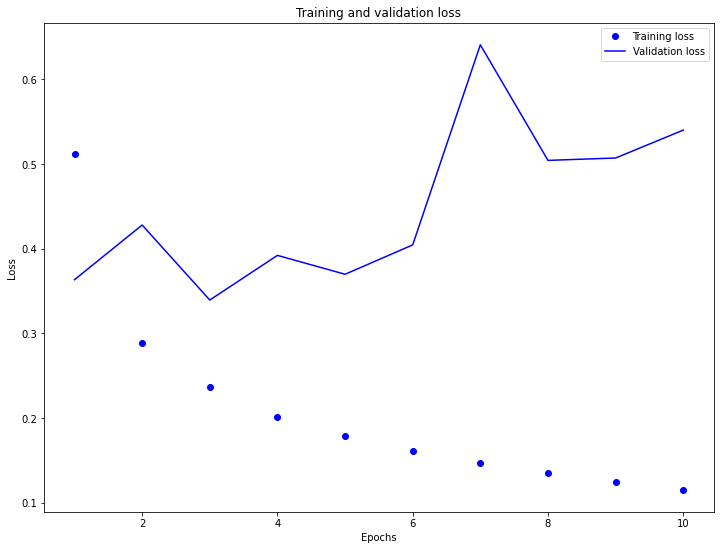

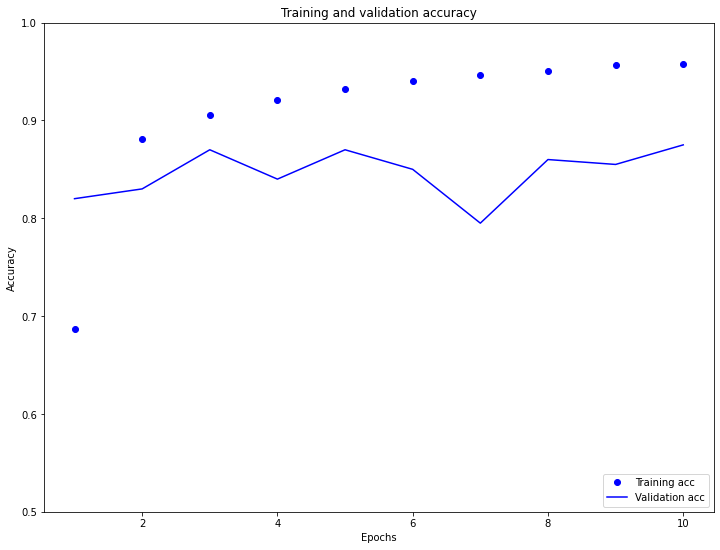

In [15]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

## Retrieve the learned embeddings

Next, let's retrieve the word embeddings learned during training. This will be a matrix of shape `(vocab_size, embedding-dimension)`.

In [16]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


We will now write the weights to disk. To use the [Embedding Projector](http://projector.tensorflow.org), we will upload two files in tab separated format: a file of vectors (containing the embedding), and a file of meta data (containing the words).

In [17]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

If you are running this tutorial in [Colaboratory](https://colab.research.google.com), you can use the following snippet to download these files to your local machine (or use the file browser, *View -> Table of contents -> File browser*).

In [18]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## Visualize the embeddings

To visualize our embeddings we will upload them to the embedding projector.

Open the [Embedding Projector](http://projector.tensorflow.org/) (this can also run in a local TensorBoard instance).

* Click on "Load data".

* Upload the two files we created above: `vecs.tsv` and `meta.tsv`.

The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful". 

Note: your results may be a bit different, depending on how weights were randomly initialized before training the embedding layer.

Note: experimentally, you may be able to produce more interpretable embeddings by using a simpler model. Try deleting the `Dense(16)` layer, retraining the model, and visualizing the embeddings again.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1" alt="Screenshot of the embedding projector" width="400"/>


## Next steps


This tutorial has shown you how to train and visualize word embeddings from scratch on a small dataset.

* To learn about recurrent networks see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).

* To learn more about text classification (including the overall workflow, and if you're curious about when to use embeddings vs one-hot encodings) we recommend this practical text classification [guide](https://developers.google.com/machine-learning/guides/text-classification/step-2-5).